# load module

In [47]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

# 25 candidate maternal factors 
output: `candidate_maternal_tr_ls`

In [2]:
# select ww's 25 maternal factors and turn to transcript format
# output: candidate_maternal_tr_ls
candidate_maternal_gene_ls = ['tbpl2', 'orc1', 'ftr81', 'lmx1a', 'zgc:165514', 
                              'si:dkey-208k4.2', 'CU929037.1', 'zgc:113424', 'zgc:114123', 
                              'mcm3l', 'mcm6l', 'npm2a', 'zgc:152977', 'cita', 
                              'si:ch211-286b5.4', 'zgc:56231', 'si:ch211-119o8.6', 'zglp1', 'figla',
                              'e2f5', 'rnf17', 'pias4b', 'stk31', 'ccdc172', 'kank1b']
        
finame = '/mnt/Storage/home/wangyiman/source/bySpecies/danRer11_2/ensGene/danRer11_2.ensGene.genePredExt'
tr_gene_pd = pd.read_table(finame, header=None, sep="\t", encoding="utf-8")
tr_gene_pd = tr_gene_pd.iloc[:,[0,11]]
tr_gene_pd.columns = ['transcript_id', 'gene_id']
finame = '/mnt/Storage/home/wangyiman/source/bySpecies/danRer11_2/ensGene/danRer11.ensGeneToGeneSymbol.txt'
gene_symbol_pd = pd.read_table(finame, header=None, sep="\t", encoding="utf-8")
gene_symbol_pd.columns = ['gene_id', 'gene_symbol']
tr_gene_symbol_pd = pd.merge(tr_gene_pd, gene_symbol_pd, on="gene_id")

candidate_maternal_trid_geneid_sym = tr_gene_symbol_pd.loc[tr_gene_symbol_pd["gene_symbol"].isin(candidate_maternal_gene_ls)]
tr_gene_symbol_pd.head()

transcript_id               gene_id gene_symbol
0  ENSDART00000164359.1  ENSDARG00000099104.1       rpl24
1  ENSDART00000158290.1  ENSDARG00000099104.1       rpl24
2  ENSDART00000157701.1  ENSDARG00000099104.1       rpl24
3  ENSDART00000167898.1  ENSDARG00000099104.1       rpl24
4  ENSDART00000166393.1  ENSDARG00000102407.2       cep97

In [3]:
tr_gene_pd_clean = pd.DataFrame(zip(list(zip(*tr_gene_symbol_pd['transcript_id'].str.split('.')))[0], list(zip(*tr_gene_symbol_pd['gene_id'].str.split('.')))[0]))
tr_gene_pd_clean.columns = ['transcript_id_clean', 'gene_id_clean']
tr_gene_pd_clean

transcript_id_clean       gene_id_clean
0      ENSDART00000164359  ENSDARG00000099104
1      ENSDART00000158290  ENSDARG00000099104
2      ENSDART00000157701  ENSDARG00000099104
3      ENSDART00000167898  ENSDARG00000099104
4      ENSDART00000166393  ENSDARG00000102407
...                   ...                 ...
65835  ENSDART00000183313  ENSDARG00000114956
65836  ENSDART00000183313  ENSDARG00000114956
65837  ENSDART00000183313  ENSDARG00000114956
65838  ENSDART00000183313  ENSDARG00000114956
65839  ENSDART00000183313  ENSDARG00000114956

[65840 rows x 2 columns]

In [4]:
gene_symbol_clean = pd.read_csv('/mnt/Storage/home/wangyiman/source/bySpecies/danRer11_2/ensGene/danRer11.ensGeneToGeneSymbol.clean.txt', header=None, 
                                sep = '\t')
gene_symbol_clean.columns = ['gene_id_clean', 'gene_symbol']
gene_symbol_clean

gene_id_clean     gene_symbol
0      ENSDARG00000099104           rpl24
1      ENSDARG00000102407           cep97
2      ENSDARG00000102097          nfkbiz
3      ENSDARG00000099319      CU651657.1
4      ENSDARG00000099640             eed
...                   ...             ...
32515  ENSDARG00000109919  CABZ01025162.1
32516  ENSDARG00000116629      CT025651.2
32517  ENSDARG00000114977      CT025651.1
32518  ENSDARG00000102423      FO818711.1
32519  ENSDARG00000112120         RF00001

[32520 rows x 2 columns]

## asign exon

In [5]:
exon_id_ls = pd.DataFrame(zip(*pd.DataFrame(zip(*pd.read_csv('/mnt/Storage/home/wangyiman/source/bySpecies/danRer11_2/ensGene/danRer11_2.ensGene.ExonUniq.gtf', 
                                     sep = '\t', header = 0).iloc[:,8].drop_duplicates().str.split(';'))).T.iloc[:,0].drop_duplicates().str.split('"'))).T.iloc[:,1].tolist()

There is some transcript id like "ENSDART00000139453.3_16.1" in Chr4.

In [6]:
exon_gene_id_dict = {}
exon_gene_id_dict_nonUniq = {}
for exon_id in set(exon_id_ls) :
    trans_ids = [('ENSDART'+x).strip('_') for x in exon_id.split('ENSDART') if x]    
    gene_ids = []
    for trans_id in trans_ids :
        gene_id_series = tr_gene_pd_clean.loc[tr_gene_pd_clean['transcript_id_clean'] == trans_id.split('.')[0]]['gene_id_clean'].tolist()
        if gene_id_series : 
            gene_ids.append(gene_id_series[0])
        else :
            print(exon_id)
        
    if len(set(gene_ids)) == 1 :
        exon_gene_id_dict[exon_id] = gene_ids[0]
    else :
#         print(gene_ids, exon_id)
        exon_gene_id_dict_nonUniq[exon_id] = gene_ids
        

In [7]:
len(exon_gene_id_dict)

320525

In [8]:
len(exon_gene_id_dict_nonUniq)

1890

In [9]:
len(set(exon_id_ls))

322415

In [10]:
320525 + 1890

322415

In [11]:
exon_tr_gene_pd_clean = pd.merge(tr_gene_pd_clean, pd.DataFrame.from_dict(exon_gene_id_dict, orient='index').reset_index(), 
                                  left_on = 'gene_id_clean', right_on = 0).iloc[:,:-1]
exon_tr_gene_pd_clean.columns = ['transcript_id_clean', 'gene_id_clean', 'exon_id']
exon_tr_gene_pd_clean

transcript_id_clean       gene_id_clean  \
0        ENSDART00000164359  ENSDARG00000099104   
1        ENSDART00000164359  ENSDARG00000099104   
2        ENSDART00000164359  ENSDARG00000099104   
3        ENSDART00000164359  ENSDARG00000099104   
4        ENSDART00000164359  ENSDARG00000099104   
...                     ...                 ...   
1130996  ENSDART00000168273  ENSDARG00000104674   
1130997  ENSDART00000168273  ENSDARG00000104674   
1130998  ENSDART00000168273  ENSDARG00000104674   
1130999  ENSDART00000168273  ENSDARG00000104674   
1131000  ENSDART00000168273  ENSDARG00000104674   

                                               exon_id  
0        ENSDART00000164359.1.3_ENSDART00000167898.1.3  
1        ENSDART00000164359.1.4_ENSDART00000167898.1.4  
2                               ENSDART00000167898.1.1  
3                               ENSDART00000164359.1.6  
4        ENSDART00000158290.1.1_ENSDART00000157701.1.1  
...                                                ...  
1130996                         ENSDART00000168273.2.5  
1130997                         ENSDART00000168273.2.7  
1130998                         ENSDART00000168273.2.4  
1130999                         ENSDART00000168273.2.8  
1131000                         ENSDART00000168273.2.1  

[1131001 rows x 3 columns]

In [12]:
set(candidate_maternal_gene_ls) - set(candidate_maternal_trid_geneid_sym['gene_symbol'].sort_values().unique().tolist()) 

set()

# merge FPKM TPM readcnt

## FPKM TPM

In [6]:
# add cmd lines to runned.sh
run = False

if run == True :
    os.chdir('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon')
    with open('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/bin/make1_runned_mergeExpr.sh', 'w') as cmd_fi :
        cmd_fi.write('#!/bin/bash')
        for expression_type in ['FPKM', 'TPM'] :
            column = '13' if expression_type == 'FPKM' else '14'
            for finame in ['ovary_earlyEmbryo_sample_exon_readcnt_prepDE_sorted.txt', 'lateEmbryo_tissue_sample_exon_readcnt_prepDE_sorted.txt'] :
                with open(f'{finame}') as samplefi :
                    sample_ls = []
                    firstline = samplefi.readline()
                    gtffi = firstline.strip().split('\t')[1]
                    cmd = 'paste' +f' <(gtf_to_table.py -l 9 -f transcript {gtffi} | grep -v ' + "'#'" +f' | cut -f 10,{column} | sort -k1,1 - )'
                    cmd2 = 'cat <(echo exon_id' + "$'\\t'" + firstline.strip().split("\t")[0]+"$'\\t'"

                    for line in samplefi :
                        gtffi = line.strip().split('\t')[1]
                        cmd += f' <(gtf_to_table.py -l 9 -f transcript {gtffi} | grep -v ' + "'#'" + f' | cut -f 10,{column} | sort -k1,1 - | cut -f 2 ) | paste -'
                        cmd2 += line.strip().split("\t")[0] + "$'\\t'"

                    cmd = cmd[:-10] + f' > ../analysis_embryoExon_tissueExon/{"_".join(finame.split("_")[0:4])}_{expression_type}.tmp'
                    cmd2 = cmd2[:-5] + f') {"_".join(finame.split("_")[0:4])}_{expression_type}.tmp > {"_".join(finame.split("_")[0:4])}_{expression_type}.tsv'
                    cmd_fi.write('\ncd ~/maternal_loading/2.public_data/2_expression_value_ExonUniq_merge_oldNew')
                    cmd_fi.write('\n' + cmd)
                    cmd_fi.write('\ncd ~/maternal_loading/2.public_data/analysis_embryoExon_tissueExon')
                    cmd_fi.write('\n' + cmd2 + '\n')


In [97]:
%%bash
cd ~/maternal_loading/2.public_data
# mkdir 2_expression_value_ExonUniq_merge_oldNew
cd 2_expression_value_ExonUniq_merge_oldNew
ln -f -s ../2_expression_value_ExonUniq/*ExonUniq.* .
ln -f -s ../2_expression_value_trans/tissue_exon/*ExonUniq.* .

In [98]:
import glob
os.chdir('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/2_expression_value_ExonUniq_merge_oldNew')

readcnt_fis = glob.glob('*.read_cnt')
txt_fis = glob.glob('*.txt')
gtf_fis = glob.glob('*.gtf')

readcnt_samples = [x[:-26] for x in readcnt_fis]
txt_samples = [x[8:-30] for x in txt_fis]
gtf_samples = [x[8:-30] for x in gtf_fis]

total_samples = pd.read_csv('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon/ovary_earlyEmbryo_sample_exon_readcnt_prepDE_sorted.txt', 
                            sep = '\t', 
                            header = None).iloc[:,0].tolist() + pd.read_csv('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon/lateEmbryo_tissue_sample_exon_readcnt_prepDE_sorted.txt', 
                                                                           sep = '\t', header = None).iloc[:,0].tolist()

print('.read_cnt', set(total_samples) - set(readcnt_samples))
print('.txt', set(total_samples) - set(txt_samples))
print('.gtf', set(total_samples) - set(gtf_samples))

.read_cnt set()
.txt set()
.gtf set()


In [100]:
%%bash
run=false
cd /mnt/Storage/home/wangyiman/maternal_loading/2.public_data/bin

[ $run == "true" ] && bash make1_runned_mergeExpr.sh


## read count

In [102]:
%%bash
run=false
cd ~/maternal_loading/2.public_data/2_expression_value_ExonUniq_merge_oldNew/
[ $run == "true" ] && sample_list_fi=../analysis_embryoExon_tissueExon/ovary_earlyEmbryo_sample_exon_readcnt_prepDE_sorted.txt && prepDE.py3 -i $sample_list_fi -g ../analysis_embryoExon_tissueExon/ovary_earlyEmbryo_exon_count_matrix.csv -t ../analysis_embryoExon_tissueExon/ovary_earlyEmbryo_exon_count_matrix.csv
[ $run == "true" ] && sample_list_fi=../analysis_embryoExon_tissueExon/lateEmbryo_tissue_sample_exon_readcnt_prepDE_sorted.txt && prepDE.py3 -i $sample_list_fi -g ../analysis_embryoExon_tissueExon/lateEmbryo_tissue_exon_count_matrix.csv -t ../analysis_embryoExon_tissueExon/lateEmbryo_tissue_exon_count_matrix.csv


In [83]:
run = False
os.chdir('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon')
if run == True :
    overay_early_df = pd.read_table('ovary_earlyEmbryo_exon_count_matrix.csv', header=0, sep=',', index_col=0)
    late_tissue_df = pd.read_table('lateEmbryo_tissue_exon_count_matrix.csv', header=0, sep=',', index_col=0)
    overay_early_df_reorder = overay_early_df[expr_3id_dict_T['ovary_earlyEmbryo_FPKM'].index.tolist()]
    overay_early_df_reorder.to_csv('ovary_earlyEmbryo_exon_count_matrix_reorder.csv', index=True)
    late_tissue_df_reorder = late_tissue_df[expr_3id_dict_T['lateEmbryo_tissue_FPKM'].index.tolist()]
    late_tissue_df_reorder.to_csv('lateEmbryo_tissue_exon_count_matrix_reorder.csv', index=True)

# remove batch effect (CombatSeq)

## remove batch effect (readcnt)

make1_1_remove_batch_effect.R

## readcnt to FPKM

make1_2_ComBat_readcnt2FPKMandTPM.R

# read in .csv

## raw

In [13]:
# read in .tsv

os.chdir('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon')
expr_3id_dict = {}
for expression_type in ['FPKM', 'TPM'] :
    for finame in [f'ovary_earlyEmbryo_sample_exon_{expression_type}.tsv', f'lateEmbryo_tissue_sample_exon_{expression_type}.tsv'] :
        expr_pd = pd.read_table(finame, header=0, sep="\t", encoding="utf-8")
        expr_3id = pd.merge(expr_pd, exon_tr_gene_pd_clean, on="exon_id")
        expr_3id['transcript_id_clean'] = expr_3id['transcript_id_clean'].astype('category')
        expr_3id['gene_id_clean'] = expr_3id['gene_id_clean'].astype('category')
        expr_3id_dict[f'{finame[:17]}_{expression_type}'] = expr_3id
        

In [14]:
expr_3id_dict['ovary_earlyEmbryo_TPM'].head()

exon_id  5mpf_ovary_rep1  ovary_rep2  oocyte_rep1  \
0  ENSDART00000000004.5.1         1.598116    0.443765     1.869867   
1  ENSDART00000000004.5.2         8.935889    2.805869     1.089710   
2  ENSDART00000000004.5.3        21.444956    7.343146     7.703125   
3  ENSDART00000000004.5.4         0.000000    1.075339     0.000000   
4  ENSDART00000000004.5.5         0.000000    2.441845     0.000000   

   oocyte_rep2  oocyte_stage1  oocyte_stage2  oocyte_stage3  oocyte_stage4  \
0     1.825394       0.172480       0.313268       0.156636       0.235801   
1     2.277718       2.261301       4.601290       6.237452       0.000000   
2     6.468347       4.130007       8.499166       5.400085       1.601061   
3     0.000000       0.832566       0.420243       1.254364       0.000000   
4     0.447126       4.415289       4.383535       2.336897       0.388471   

   1cell_rep1  ...  elife_30860_16hpf_somites_5  elife_30860_19hpf_somites_1  \
0    0.300328  ...                     0.342244                     0.524553   
1    4.576962  ...                     1.827976                     0.272658   
2    9.136024  ...                     1.112506                     0.378897   
3    1.490353  ...                     0.000000                     0.000000   
4    9.125546  ...                     0.000000                     1.087209   

   elife_30860_19hpf_somites_2  elife_30860_19hpf_somites_3  \
0                     0.133667                     0.129435   
1                     1.650726                     1.652978   
2                     1.294312                     1.179526   
3                     0.000000                     0.046316   
4                     0.000000                     0.465374   

   elife_30860_19hpf_somites_4  elife_30860_19hpf_somites_5  \
0                     0.000000                     0.003082   
1                     1.238611                     1.324941   
2                     1.156829                     1.268553   
3                     0.000000                     0.674387   
4                     0.847983                     0.477121   

   20ss_allskin_rep1  20ss_allskin_rep2  transcript_id_clean  \
0           0.154407           0.048470   ENSDART00000000004   
1           0.278723           0.339015   ENSDART00000000004   
2           0.673836           1.009955   ENSDART00000000004   
3           0.551872           0.000000   ENSDART00000000004   
4           0.000000           0.126448   ENSDART00000000004   

        gene_id_clean  
0  ENSDARG00000000001  
1  ENSDARG00000000001  
2  ENSDARG00000000001  
3  ENSDARG00000000001  
4  ENSDARG00000000001  

[5 rows x 119 columns]

In [15]:
expr_3id_dict['ovary_earlyEmbryo_FPKM'].head()

exon_id  5mpf_ovary_rep1  ovary_rep2  oocyte_rep1  \
0  ENSDART00000000004.5.1         2.898963    1.608466     3.356548   
1  ENSDART00000000004.5.2        16.209595   10.170124     1.956110   
2  ENSDART00000000004.5.3        38.900887   26.615896    13.827671   
3  ENSDART00000000004.5.4         0.000000    3.897664     0.000000   
4  ENSDART00000000004.5.5         0.000000    8.850687     0.000000   

   oocyte_rep2  oocyte_stage1  oocyte_stage2  oocyte_stage3  oocyte_stage4  \
0     4.193082       0.735718       1.318437       0.662098       0.998386   
1     5.232107       9.645643      19.365229      26.365660       0.000000   
2    14.858332      17.616663      35.770039      22.826115       6.778923   
3     0.000000       3.551336       1.768656       5.302185       0.000000   
4     1.027086      18.833542      18.448778       9.878043       1.644792   

   1cell_rep1  ...  elife_30860_16hpf_somites_5  elife_30860_19hpf_somites_1  \
0    1.123512  ...                     0.730702                     1.160784   
1   17.122173  ...                     3.902787                     0.603365   
2   34.177383  ...                     2.375237                     0.838463   
3    5.575330  ...                     0.000000                     0.000000   
4   34.138187  ...                     0.000000                     2.405886   

   elife_30860_19hpf_somites_2  elife_30860_19hpf_somites_3  \
0                     0.291579                     0.281427   
1                     3.600861                     3.594024   
2                     2.823385                     2.564610   
3                     0.000000                     0.100703   
4                     0.000000                     1.011849   

   elife_30860_19hpf_somites_4  elife_30860_19hpf_somites_5  \
0                     0.000000                     0.006771   
1                     2.743334                     2.911186   
2                     2.562198                     2.787289   
3                     0.000000                     1.481776   
4                     1.878152                     1.048338   

   20ss_allskin_rep1  20ss_allskin_rep2  transcript_id_clean  \
0           0.571280           0.187402   ENSDART00000000004   
1           1.031229           1.310755   ENSDART00000000004   
2           2.493079           3.904857   ENSDART00000000004   
3           2.041833           0.000000   ENSDART00000000004   
4           0.000000           0.488893   ENSDART00000000004   

        gene_id_clean  
0  ENSDARG00000000001  
1  ENSDARG00000000001  
2  ENSDARG00000000001  
3  ENSDARG00000000001  
4  ENSDARG00000000001  

[5 rows x 119 columns]

In [16]:
expr_3id_dict['lateEmbryo_tissue_TPM'].head()

exon_id  24hpf_pgc_rep1  24hpf_pgc_rep2  24hpf_pgc_rep3  \
0  ENSDART00000000004.5.1        0.409856        0.221467        0.405261   
1  ENSDART00000000004.5.2        0.066284        0.000000        0.000000   
2  ENSDART00000000004.5.3        0.789260        0.364873        0.531433   
3  ENSDART00000000004.5.4        0.000000        0.000000        0.000000   
4  ENSDART00000000004.5.5        0.000000        0.000000        0.000000   

   24hpf_pgc_rep4  24hpf_rep1  24hpf_rep2  24hpf_rep3  24hpf_rep4  24hpf_rep5  \
0        0.234795    0.048692    0.242575    0.000000    0.104251    0.165486   
1        0.000000    0.365912    0.758942    0.923232    1.198394    0.677705   
2        0.051315    1.030213    0.876635    0.466255    0.668134    0.971908   
3        0.000000    0.466020    0.437540    0.000000    0.228559    0.708509   
4        0.050825    1.156162    1.083502    0.623839    0.308247    0.128185   

   ...  ventricle_rep3  ventricle_rep4  ventricle_rep5  testis_rep1  \
0  ...        0.191853        0.552912        0.166538     0.128866   
1  ...        2.077567        1.095901        0.333522     1.548524   
2  ...        1.358157        1.535385        0.608713     1.051416   
3  ...        0.000000        0.000000        0.000000     0.000000   
4  ...        0.000000        0.000000        0.000000     0.661474   

   testis_rep2  testis_rep3  testis_rep4  testis_rep5  transcript_id_clean  \
0     0.085461     0.142070     0.054256     0.025338   ENSDART00000000004   
1     0.546727     2.052305     1.898496     1.361721   ENSDART00000000004   
2     0.759317     1.334506     1.397835     1.384735   ENSDART00000000004   
3     0.000000     0.000000     0.374180     0.000000   ENSDART00000000004   
4     0.342329     0.808159     1.451543     1.097929   ENSDART00000000004   

        gene_id_clean  
0  ENSDARG00000000001  
1  ENSDARG00000000001  
2  ENSDARG00000000001  
3  ENSDARG00000000001  
4  ENSDARG00000000001  

[5 rows x 211 columns]

In [17]:
expr_3id_dict['lateEmbryo_tissue_FPKM'].head()

exon_id  24hpf_pgc_rep1  24hpf_pgc_rep2  24hpf_pgc_rep3  \
0  ENSDART00000000004.5.1        0.990854        0.554260        0.977126   
1  ENSDART00000000004.5.2        0.160246        0.000000        0.000000   
2  ENSDART00000000004.5.3        1.908090        0.913157        1.281340   
3  ENSDART00000000004.5.4        0.000000        0.000000        0.000000   
4  ENSDART00000000004.5.5        0.000000        0.000000        0.000000   

   24hpf_pgc_rep4  24hpf_rep1  24hpf_rep2  24hpf_rep3  24hpf_rep4  24hpf_rep5  \
0        0.586080    0.175776    0.886157    0.000000    0.437372    0.696602   
1        0.000000    1.320931    2.772516    3.436745    5.027730    2.852748   
2        0.128089    3.719038    3.202463    1.735640    2.803082    4.091176   
3        0.000000    1.682317    1.598390    0.000000    0.958895    2.982418   
4        0.126866    4.173709    3.958174    2.322251    1.293215    0.539583   

   ...  ventricle_rep3  ventricle_rep4  ventricle_rep5  testis_rep1  \
0  ...        0.346140        0.989893        0.291738     0.504345   
1  ...        3.748337        1.962022        0.584258     6.060466   
2  ...        2.450380        2.748842        1.066333     4.114933   
3  ...        0.000000        0.000000        0.000000     0.000000   
4  ...        0.000000        0.000000        0.000000     2.588814   

   testis_rep2  testis_rep3  testis_rep4  testis_rep5  transcript_id_clean  \
0     0.298533     0.554091     0.205357     0.096904   ENSDART00000000004   
1     1.909833     8.004222     7.185793     5.207912   ENSDART00000000004   
2     2.652457     5.204724     5.290793     5.295929   ENSDART00000000004   
3     0.000000     0.000000     1.416267     0.000000   ENSDART00000000004   
4     1.195830     3.151910     5.494078     4.199038   ENSDART00000000004   

        gene_id_clean  
0  ENSDARG00000000001  
1  ENSDARG00000000001  
2  ENSDARG00000000001  
3  ENSDARG00000000001  
4  ENSDARG00000000001  

[5 rows x 211 columns]

In [18]:
expr_3id_dict['lateEmbryo_tissue_FPKM'].memory_usage(deep=True)

Index                    9048008
exon_id                107672937
24hpf_pgc_rep1           9048008
24hpf_pgc_rep2           9048008
24hpf_pgc_rep3           9048008
                         ...    
testis_rep3              9048008
testis_rep4              9048008
testis_rep5              9048008
transcript_id_clean     11028680
gene_id_clean            5700810
Length: 212, dtype: int64

In [19]:
ovary_earlyEmbryo_TPM_stages = ['ovary'] * 2 + ['oocyte'] * 6 + ['1_cell'] * 12 + ['2_cell'] * 5 + ['4_cell'] * 2 + ['24_cell'] * 2 + ['64_cell'] * 2 + ['128_cell'] * 5 + ['256_cell'] * 3 + ['1k_cell'] * 9 + ['high'] * 5 + ['oblong'] * 1 + ['4hpf'] * 4 + ['sphere'] * 2 + ['dome'] * 9 + ['50epi'] * 5 + ['6hpf'] * 5 + ['shield'] * 5 + ['7hpf'] * 8 + ['8hpf'] * 5 + ['bud'] * 2 + ['10.33hpf'] * 5 + ['16hpf'] * 5 + ['19hpf'] * 5 + ['20ss'] * 2
ovary_earlyEmbryo_TPM_stages_uniq = ['ovary'] + ['oocyte'] + ['1_cell'] + ['2_cell'] + ['4_cell'] + ['24_cell'] + ['64_cell'] + ['128_cell'] + ['256_cell'] + ['1k_cell'] + ['high'] + ['oblong'] + ['4hpf'] + ['sphere'] + ['dome'] + ['50epi'] + ['6hpf'] + ['shield'] + ['7hpf'] + ['8hpf'] + ['bud'] + ['10.33hpf'] + ['16hpf'] + ['19hpf'] + ['20ss']

lateEmbryo_tissue_TPM_stages = ['24hpf'] * 19 + ['28hpf'] * 5 + ['30hpf'] * 5 + ['36hpf'] * 24 + ['48hpf'] * 7 + ['52hpf'] * 8 + ['56hpf'] * 2 + ['3dpf'] * 23 + ['4dpf'] * 28 + ['5dpf'] * 18 + ['6dpf'] * 7 + ['3wpf'] * 3 + ['2mpf'] * 2 + ['3mpf'] * 5 + ['epidermis_cLCs'] * 4 + ['epidermis_Keratinocytes'] * 3 + ['epidermis_MLCs'] * 4 + ['epidermis_Neutrophils'] * 3 + ['epidermis_T_cell'] * 3 + ['kidney'] * 7 + ['liver'] * 9 + ['muscle'] * 3 + ['retina_muller'] * 3 + ['valve'] * 3 + ['ventricle'] * 5 + ['testis'] * 5
lateEmbryo_tissue_TPM_stages_uniq = ['24hpf'] + ['28hpf'] + ['30hpf'] + ['36hpf'] + ['48hpf'] + ['52hpf'] + ['56hpf'] + ['3dpf'] + ['4dpf'] + ['5dpf'] + ['6dpf'] + ['3wpf'] + ['2mpf'] + ['3mpf'] + ['epidermis_cLCs'] + ['epidermis_Keratinocytes'] + ['epidermis_MLCs'] + ['epidermis_Neutrophils'] + ['epidermis_T_cell'] + ['kidney'] + ['liver'] + ['muscle'] + ['retina_muller'] + ['valve'] + ['ventricle'] + ['testis']

lateEmbryo_tissue_TPM_samples = ['_'.join(x.split('_')[:-1]) for x in expr_3id_dict['lateEmbryo_tissue_TPM'].columns[1:-2].tolist()]
lateEmbryo_tissue_TPM_samples = lateEmbryo_tissue_TPM_samples[:38] + ['36hpf_sample1'] * 3 + ['36hpf_sample2'] * 3 + lateEmbryo_tissue_TPM_samples[44:121] + ['5dpf_sample1'] * 2 + lateEmbryo_tissue_TPM_samples[123:125] + ['5dpf_sample2'] * 3 + lateEmbryo_tissue_TPM_samples[128:]
lateEmbryo_tissue_TPM_samples_uniq = pd.Series(lateEmbryo_tissue_TPM_samples).drop_duplicates().tolist()
len(lateEmbryo_tissue_TPM_samples_uniq)

71

In [20]:
expr_3id_dict_T = {}
for k in ['ovary_earlyEmbryo_FPKM', 'lateEmbryo_tissue_FPKM', 'ovary_earlyEmbryo_TPM', 'lateEmbryo_tissue_TPM'] :
    expr_3id_dict_T[k] = expr_3id_dict[k].copy()
    expr_3id_dict_T[k].index = expr_3id_dict[k]['exon_id']
    expr_3id_dict_T[k] = expr_3id_dict_T[k].T.iloc[1:-2,:]
    expr_3id_dict_T[k]['stage'] = ovary_earlyEmbryo_TPM_stages if k.split('_')[0] == 'ovary' else lateEmbryo_tissue_TPM_samples
    expr_3id_dict_T[k]['stage'] = expr_3id_dict_T[k]['stage'].astype('category')
    

In [21]:
expr_3id_dict_T[k]

exon_id        ENSDART00000000004.5.1 ENSDART00000000004.5.2  \
24hpf_pgc_rep1               0.409856               0.066284   
24hpf_pgc_rep2               0.221467                    0.0   
24hpf_pgc_rep3               0.405261                    0.0   
24hpf_pgc_rep4               0.234795                    0.0   
24hpf_rep1                   0.048692               0.365912   
...                               ...                    ...   
testis_rep1                  0.128866               1.548524   
testis_rep2                  0.085461               0.546727   
testis_rep3                   0.14207               2.052305   
testis_rep4                  0.054256               1.898496   
testis_rep5                  0.025338               1.361721   

exon_id        ENSDART00000000004.5.3 ENSDART00000000004.5.4  \
24hpf_pgc_rep1                0.78926                    0.0   
24hpf_pgc_rep2               0.364873                    0.0   
24hpf_pgc_rep3               0.531433                    0.0   
24hpf_pgc_rep4               0.051315                    0.0   
24hpf_rep1                   1.030213                0.46602   
...                               ...                    ...   
testis_rep1                  1.051416                    0.0   
testis_rep2                  0.759317                    0.0   
testis_rep3                  1.334506                    0.0   
testis_rep4                  1.397835                0.37418   
testis_rep5                  1.384735                    0.0   

exon_id        ENSDART00000000004.5.5 ENSDART00000000004.5.6  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2                    0.0                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.050825               0.190424   
24hpf_rep1                   1.156162               0.533491   
...                               ...                    ...   
testis_rep1                  0.661474               4.096805   
testis_rep2                  0.342329               0.454269   
testis_rep3                  0.808159               1.458495   
testis_rep4                  1.451543               0.548292   
testis_rep5                  1.097929               1.369583   

exon_id        ENSDART00000000004.5.7 ENSDART00000000004.5.8  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2               0.583165                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.403734                    0.0   
24hpf_rep1                   0.525419                    0.0   
...                               ...                    ...   
testis_rep1                   1.16439                    0.0   
testis_rep2                  0.461378                    0.0   
testis_rep3                  0.576373                    0.0   
testis_rep4                  0.726558                    0.0   
testis_rep5                  0.825528                    0.0   

exon_id        ENSDART00000000005.7.1 ENSDART00000000005.7.2  ...  \
24hpf_pgc_rep1               2.735469               0.066072  ...   
24hpf_pgc_rep2               2.829005               0.061696  ...   
24hpf_pgc_rep3               2.112854                    0.0  ...   
24hpf_pgc_rep4               2.703464               1.081931  ...   
24hpf_rep1                   0.787556               0.222027  ...   
...                               ...                    ...  ...   
testis_rep1                  0.324935               0.855409  ...   
testis_rep2                   0.13796                    0.0  ...   
testis_rep3                    0.2251                    0.0  ...   
testis_rep4                  0.390267               0.446579  ...   
testis_rep5                  0.500334                0.46897  ...   

exon_id        ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
24hpf_pg

## batch effect removed

In [22]:
# read in .tsv

os.chdir('/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/analysis_embryoExon_tissueExon')
expr_combat_dict = {}
for expression_type in ['FPKM', 'TPM'] :
    # lateEmbryo_tissue_exon_FPKM_matrix_exOvary_ComBatSeq.csv
    for finame in [f'ovary_earlyEmbryo_exon_{expression_type}_matrix_exOvary_ComBatSeq.csv', 
                   f'lateEmbryo_tissue_exon_{expression_type}_matrix_exOvary_ComBatSeq.csv'] :
        expr_pd = pd.read_table(finame, header=0, sep=",", encoding="utf-8")
        expr_pd['exon_id'] = list(zip(*expr_pd['Unnamed: 0'].str.split('|').tolist()))[0]
        expr_3id = pd.merge(expr_pd.drop('Unnamed: 0', axis = 1), exon_tr_gene_pd_clean, on="exon_id").drop_duplicates()
        expr_3id.index = expr_3id['exon_id'].astype('category')
        expr_3id['transcript_id_clean'] = expr_3id['transcript_id_clean'].astype('category')
        expr_3id['gene_id_clean'] = expr_3id['gene_id_clean'].astype('category')
        expr_combat_dict[f'{finame[:17]}_{expression_type}'] = expr_3id.drop('exon_id', axis = 1)


In [23]:
expr_combat_dict['ovary_earlyEmbryo_TPM']

oocyte_rep1  oocyte_rep2  \
exon_id                                                                        
ENSDART00000000004.5.1                                 0.577795     1.385141   
ENSDART00000000004.5.2                                 0.311120     0.846475   
ENSDART00000000004.5.3                                 7.289109     7.695227   
ENSDART00000000004.5.4                                 0.000000     0.000000   
ENSDART00000000004.5.5                                 0.000000     0.230857   
...                                                         ...          ...   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.000000   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   

                                                    X1cell_rep1  X1cell_rep2  \
exon_id                                                                        
ENSDART00000000004.5.1                                 1.480533     1.266204   
ENSDART00000000004.5.2                                 2.391630     3.271026   
ENSDART00000000004.5.3                                10.135955     9.918596   
ENSDART00000000004.5.4                                 0.569436     0.633102   
ENSDART00000000004.5.5                                 6.149905     6.331019   
...                                                         ...          ...   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.105517   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.105517   
ENSDART00000195003.1.4                                 0.341661     0.211034   
ENSDART00000195003.1.4                                 0.341661     0.211034   
ENSDART00000195003.1.4                                 0.341661     0.211034   

                                                    X1cell_rep3  X1cell_rep4  \
exon_id                                                                        
ENSDART00000000004.5.1                                 1.068887     0.934058   
ENSDART00000000004.5.2                                 5.077211     4.255151   
ENSDART00000000004.5.3                                 9.619979     7.472461   
ENSDART00000000004.5.4                                 0.534443     0.000000   
ENSDART00000000004.5.5                                 4.275546     2.387036   
...                                                         ...          ...   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.000000   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   

                                                    X1cell_rep5  X1cell_rep6  \
exon_id                                                                        
ENSDART00000000004.5.1                                 0.865138     2.285655   
ENSDART00000000004.5.2                                 5.731538     0.425898   
ENSDART00000000004.5.3                                 8.218810     7.126701   
ENSDART00000000004.5.4                                 0.540711     0.000000   
ENSDART00000000004.5.5                                 3.460551     0.255539   
...                                                         ...          ...   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.216284     0.000000   
ENSDART00000195003.1.3_ENSDART00000194969.1.3_E...     0.216284     0.000000   
ENSDART00000195003.1.4                                 0.000000     0.000000   
ENSDART00000195003.1.4                           

In [24]:
322416

322416

In [25]:
expr_combat_dict['ovary_earlyEmbryo_FPKM'].head()

oocyte_rep1  oocyte_rep2  X1cell_rep1  X1cell_rep2  \
exon_id                                                                      
ENSDART00000000004.5.1     0.544063    13.714266     1.927777    18.898563   
ENSDART00000000004.5.2     0.292957     8.380940     3.114101    48.821287   
ENSDART00000000004.5.3     6.863567    76.190368    13.197858   148.038743   
ENSDART00000000004.5.4     0.000000     0.000000     0.741453     9.449281   
ENSDART00000000004.5.5     0.000000     2.285711     8.007689    94.492815   

                        X1cell_rep3  X1cell_rep4  X1cell_rep5  X1cell_rep6  \
exon_id                                                                      
ENSDART00000000004.5.1     8.036741     9.531200     4.505926    48.630957   
ENSDART00000000004.5.2    38.174519    43.419912    29.851763     9.061669   
ENSDART00000000004.5.3    72.330667    76.249601    42.806301   151.631929   
ENSDART00000000004.5.4     4.018370     0.000000     2.816204     0.000000   
ENSDART00000000004.5.5    32.146963    24.357511    18.023706     5.437001   

                        X1cell_rep7  elife_30860_1cell_1  ...  \
exon_id                                                   ...   
ENSDART00000000004.5.1     1.453836             4.594876  ...   
ENSDART00000000004.5.2     0.323075             2.756926  ...   
ENSDART00000000004.5.3     4.092278            40.434909  ...   
ENSDART00000000004.5.4     0.000000             0.000000  ...   
ENSDART00000000004.5.5     0.026923             0.000000  ...   

                        elife_30860_16hpf_somites_5  \
exon_id                                               
ENSDART00000000004.5.1                    23.403566   
ENSDART00000000004.5.2                     7.801189   
ENSDART00000000004.5.3                    95.564559   
ENSDART00000000004.5.4                     0.000000   
ENSDART00000000004.5.5                     0.000000   

                        elife_30860_19hpf_somites_1  \
exon_id                                               
ENSDART00000000004.5.1                     2.451198   
ENSDART00000000004.5.2                     0.175086   
ENSDART00000000004.5.3                     2.451198   
ENSDART00000000004.5.4                     0.000000   
ENSDART00000000004.5.5                     0.525257   

                        elife_30860_19hpf_somites_2  \
exon_id                                               
ENSDART00000000004.5.1                    10.309773   
ENSDART00000000004.5.2                     6.873182   
ENSDART00000000004.5.3                    82.478182   
ENSDART00000000004.5.4                     0.000000   
ENSDART00000000004.5.5                     0.000000   

                        elife_30860_19hpf_somites_3  \
exon_id                                               
ENSDART00000000004.5.1                    10.041503   
ENSDART00000000004.5.2                     6.694335   
ENSDART00000000004.5.3                    83.679193   
ENSDART00000000004.5.4                     1.673584   
ENSDART00000000004.5.5                     3.347168   

                        elife_30860_19hpf_somites_4  \
exon_id                                               
ENSDART00000000004.5.1                     0.000000   
ENSDART00000000004.5.2                     7.300089   
ENSDART00000000004.5.3                    97.334514   
ENSDART00000000004.5.4                     0.000000   
ENSDART00000000004.5.5                     7.300089   

                        elife_30860_19hpf_somites_5  X20ss_allskin_rep1  \
exon_id                                                                   
ENSDART00000000004.5.1                     1.494206            7.234149   
ENSDART00000000004.5.2                     4.482617            0.904269   
ENSDART00000000004.5.3                    76.204493           23.510986   
ENSDART00000000004.5.4                     1.494206            1.808537   
ENSDART00000000004.5.5                     2.988412            0.000000   

                  

In [26]:
expr_combat_dict['lateEmbryo_tissue_TPM'].head()

X24hpf_pgc_rep1  X24hpf_pgc_rep2  X24hpf_pgc_rep3  \
exon_id                                                                     
ENSDART00000000004.5.1         1.457431         0.780506         1.597509   
ENSDART00000000004.5.2         0.026499         0.000000         0.000000   
ENSDART00000000004.5.3         2.040403         0.936608         1.542423   
ENSDART00000000004.5.4         0.000000         0.000000         0.000000   
ENSDART00000000004.5.5         0.000000         0.000000         0.000000   

                        X24hpf_pgc_rep4  X24hpf_rep1  X24hpf_rep2  \
exon_id                                                             
ENSDART00000000004.5.1         0.896384     0.220342     1.285405   
ENSDART00000000004.5.2         0.000000     0.220342     0.395509   
ENSDART00000000004.5.3         0.158185     3.415308     3.262952   
ENSDART00000000004.5.4         0.000000     0.220342     0.197755   
ENSDART00000000004.5.5         0.052728     0.661027     0.791019   

                        X24hpf_rep3  X24hpf_rep4  X24hpf_rep5  X24hpf_rep6  \
exon_id                                                                      
ENSDART00000000004.5.1     0.000000     0.613507     0.917635     0.483964   
ENSDART00000000004.5.2     0.560882     0.613507     0.458817     0.604954   
ENSDART00000000004.5.3     1.869608     2.576729     3.670540     2.056845   
ENSDART00000000004.5.4     0.000000     0.122701     0.305878     0.000000   
ENSDART00000000004.5.5     0.560882     0.245403     0.152939     0.483964   

                        ...  ventricle_rep3  ventricle_rep4  ventricle_rep5  \
exon_id                 ...                                                   
ENSDART00000000004.5.1  ...        0.549512        1.702183        0.502903   
ENSDART00000000004.5.2  ...        0.571492        0.325417        0.114296   
ENSDART00000000004.5.3  ...        2.791519        3.379334        1.280116   
ENSDART00000000004.5.4  ...        0.000000        0.000000        0.000000   
ENSDART00000000004.5.5  ...        0.000000        0.000000        0.000000   

                        testis_rep1  testis_rep2  testis_rep3  testis_rep4  \
exon_id                                                                      
ENSDART00000000004.5.1     0.951127     0.593875     0.781464     0.391247   
ENSDART00000000004.5.2     0.951127     0.296938     1.041952     0.978119   
ENSDART00000000004.5.3     4.121549     2.672439     4.949271     5.086217   
ENSDART00000000004.5.4     0.000000     0.000000     0.000000     0.195624   
ENSDART00000000004.5.5     0.634084     0.296938     0.520976     0.978119   

                        testis_rep5  transcript_id_clean       gene_id_clean  
exon_id                                                                       
ENSDART00000000004.5.1     0.136971   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.2     0.639197   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.3     4.839632   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.4     0.000000   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.5     0.684854   ENSDART00000000004  ENSDARG00000000001  

[5 rows x 210 columns]

In [27]:
expr_combat_dict['lateEmbryo_tissue_FPKM'].head()

X24hpf_pgc_rep1  X24hpf_pgc_rep2  X24hpf_pgc_rep3  \
exon_id                                                                     
ENSDART00000000004.5.1         1.372345         7.727785         2.080090   
ENSDART00000000004.5.2         0.024952         0.000000         0.000000   
ENSDART00000000004.5.3         1.921283         9.273342         2.008363   
ENSDART00000000004.5.4         0.000000         0.000000         0.000000   
ENSDART00000000004.5.5         0.000000         0.000000         0.000000   

                        X24hpf_pgc_rep4  X24hpf_rep1  X24hpf_rep2  \
exon_id                                                             
ENSDART00000000004.5.1        13.378862     1.656710    13.116380   
ENSDART00000000004.5.2         0.000000     1.656710     4.035809   
ENSDART00000000004.5.3         2.360976    25.679005    33.295426   
ENSDART00000000004.5.4         0.000000     1.656710     2.017905   
ENSDART00000000004.5.5         0.786992     4.970130     8.071619   

                        X24hpf_rep3  X24hpf_rep4  X24hpf_rep5  X24hpf_rep6  \
exon_id                                                                      
ENSDART00000000004.5.1     0.000000    13.053341     0.554462     3.102330   
ENSDART00000000004.5.2     2.921263    13.053341     0.277231     3.877913   
ENSDART00000000004.5.3     9.737543    54.824032     2.217849    13.184903   
ENSDART00000000004.5.4     0.000000     2.610668     0.184821     0.000000   
ENSDART00000000004.5.5     2.921263     5.221336     0.092410     3.102330   

                        ...  ventricle_rep3  ventricle_rep4  ventricle_rep5  \
exon_id                 ...                                                   
ENSDART00000000004.5.1  ...        4.778362       17.193769        3.566687   
ENSDART00000000004.5.2  ...        4.969496        3.287044        0.810611   
ENSDART00000000004.5.3  ...       24.274078       34.134688        9.078839   
ENSDART00000000004.5.4  ...        0.000000        0.000000        0.000000   
ENSDART00000000004.5.5  ...        0.000000        0.000000        0.000000   

                        testis_rep1  testis_rep2  testis_rep3  testis_rep4  \
exon_id                                                                      
ENSDART00000000004.5.1     5.435010     6.251320     3.686150     3.835760   
ENSDART00000000004.5.2     5.435010     3.125660     4.914867     9.589399   
ENSDART00000000004.5.3    23.551708    28.130938    23.345619    49.864875   
ENSDART00000000004.5.4     0.000000     0.000000     0.000000     1.917880   
ENSDART00000000004.5.5     3.623340     3.125660     2.457434     9.589399   

                        testis_rep5  transcript_id_clean       gene_id_clean  
exon_id                                                                       
ENSDART00000000004.5.1     0.756744   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.2     3.531473   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.3    26.738298   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.4     0.000000   ENSDART00000000004  ENSDARG00000000001  
ENSDART00000000004.5.5     3.783721   ENSDART00000000004  ENSDARG00000000001  

[5 rows x 210 columns]

In [28]:
expr_combat_dict['lateEmbryo_tissue_FPKM'].memory_usage(deep=True)

Index                  40949534
X24hpf_pgc_rep1         6786024
X24hpf_pgc_rep2         6786024
X24hpf_pgc_rep3         6786024
X24hpf_pgc_rep4         6786024
                         ...   
testis_rep3             6786024
testis_rep4             6786024
testis_rep5             6786024
transcript_id_clean     9897688
gene_id_clean           5135314
Length: 211, dtype: int64

In [35]:
expr_combat_dict_T = {}
for k in ['ovary_earlyEmbryo_FPKM', 'lateEmbryo_tissue_FPKM', 'ovary_earlyEmbryo_TPM', 'lateEmbryo_tissue_TPM'] :
    expr_combat_dict_T[k] = expr_combat_dict[k].copy()
    expr_combat_dict_T[k] = expr_combat_dict_T[k].T.iloc[:-2,:]
    expr_combat_dict_T[k].index = [x.strip('X') for x in expr_combat_dict_T[k].index]
    expr_combat_dict_T[k]['stage'] = ovary_earlyEmbryo_TPM_stages[6:] if k.split('_')[0] == 'ovary' else lateEmbryo_tissue_TPM_samples
    expr_combat_dict_T[k]['stage'] = expr_combat_dict_T[k]['stage'].astype('category')
    

In [36]:
expr_combat_dict_T[k].head()

exon_id        ENSDART00000000004.5.1 ENSDART00000000004.5.2  \
24hpf_pgc_rep1               1.457431               0.026499   
24hpf_pgc_rep2               0.780506                    0.0   
24hpf_pgc_rep3               1.597509                    0.0   
24hpf_pgc_rep4               0.896384                    0.0   
24hpf_rep1                   0.220342               0.220342   

exon_id        ENSDART00000000004.5.3 ENSDART00000000004.5.4  \
24hpf_pgc_rep1               2.040403                    0.0   
24hpf_pgc_rep2               0.936608                    0.0   
24hpf_pgc_rep3               1.542423                    0.0   
24hpf_pgc_rep4               0.158185                    0.0   
24hpf_rep1                   3.415308               0.220342   

exon_id        ENSDART00000000004.5.5 ENSDART00000000004.5.6  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2                    0.0                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.052728               0.105457   
24hpf_rep1                   0.661027               0.330514   

exon_id        ENSDART00000000004.5.7 ENSDART00000000004.5.8  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2               0.390253                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.316371                    0.0   
24hpf_rep1                   0.440685                    0.0   

exon_id        ENSDART00000000005.7.1 ENSDART00000000005.7.2  ...  \
24hpf_pgc_rep1              15.130781               0.052997  ...   
24hpf_pgc_rep2              15.454025               0.052034  ...   
24hpf_pgc_rep3              12.835162                    0.0  ...   
24hpf_pgc_rep4              15.765808               0.632741  ...   
24hpf_rep1                   5.508561               0.220342  ...   

exon_id        ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
24hpf_pgc_rep1                                                0.0                     
24hpf_pgc_rep2                                                0.0                     
24hpf_pgc_rep3                                                0.0                     
24hpf_pgc_rep4                                                0.0                     
24hpf_rep1                                               0.110171                     

exon_id        ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
24hpf_pgc_rep1                                                0.0                     
24hpf_pgc_rep2                                                0.0                     
24hpf_pgc_rep3                                                0.0                     
24hpf_pgc_rep4                                                0.0                     
24hpf_rep1                                               0.110171                     

exon_id        ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
24hpf_pgc_rep1                                                0.0                     
24hpf_pgc_rep2                                                0.0                     
24hpf_pgc_rep3                                                0.0                     
24hpf_pgc_rep4                                                0.0                     
24hpf_rep1                                               0.110171                     

exon_id        ENSDART00000195003.1.3_ENSDART00000194969.1.3_ENSDART00000194711.1.3  \
24hpf_pgc_rep1                                                0.0                     
24hpf_pgc_rep2                                                0.0                     
24hpf_pgc_rep3                                                0.0                     
24hpf_pgc_rep4                                                0.0                     
24hpf_rep1                               

# z-score (not used)

In [175]:
from scipy.stats import zscore

expr_3id_dict_T_z = {}
for k in expr_3id_dict_T.keys() :
    expr_3id_dict_T_z[k] = expr_3id_dict_T[k].iloc[:,:-1].astype('float').T.apply(zscore).T
        
expr_3id_dict_T_z[k]

exon_id         ENSDART00000000004.5.1  ENSDART00000000004.5.2  \
24hpf_pgc_rep1               -0.016279               -0.020248   
24hpf_pgc_rep2               -0.020472               -0.023345   
24hpf_pgc_rep3               -0.015693               -0.020265   
24hpf_pgc_rep4               -0.019593               -0.022550   
24hpf_rep1                   -0.077722               -0.067271   
...                                ...                     ...   
testis_rep1                  -0.205549               -0.075504   
testis_rep2                  -0.097456               -0.077169   
testis_rep3                  -0.200244               -0.028260   
testis_rep4                  -0.202173               -0.041471   
testis_rep5                  -0.192332               -0.083646   

exon_id         ENSDART00000000004.5.3  ENSDART00000000004.5.4  \
24hpf_pgc_rep1               -0.011895               -0.021014   
24hpf_pgc_rep2               -0.018611               -0.023345   
24hpf_pgc_rep3               -0.014270               -0.020265   
24hpf_pgc_rep4               -0.021904               -0.022550   
24hpf_rep1                   -0.045384               -0.063972   
...                                ...                     ...   
testis_rep1                  -0.121040               -0.217354   
testis_rep2                  -0.067819               -0.101215   
testis_rep3                  -0.092886               -0.213035   
testis_rep4                  -0.085097               -0.174296   
testis_rep5                  -0.081774               -0.194393   

exon_id         ENSDART00000000004.5.5  ENSDART00000000004.5.6  \
24hpf_pgc_rep1               -0.021014               -0.021014   
24hpf_pgc_rep2               -0.023345               -0.023345   
24hpf_pgc_rep3               -0.020265               -0.020265   
24hpf_pgc_rep4               -0.021910               -0.020152   
24hpf_rep1                   -0.041235               -0.061750   
...                                ...                     ...   
testis_rep1                  -0.156760                0.157927   
testis_rep2                  -0.086159               -0.081235   
testis_rep3                  -0.140274               -0.081723   
testis_rep4                  -0.080418               -0.159124   
testis_rep5                  -0.105100               -0.083007   

exon_id         ENSDART00000000004.5.7  ENSDART00000000004.5.8  \
24hpf_pgc_rep1               -0.021014               -0.021014   
24hpf_pgc_rep2               -0.015779               -0.023345   
24hpf_pgc_rep3               -0.020265               -0.020265   
24hpf_pgc_rep4               -0.017466               -0.022550   
24hpf_rep1                   -0.062015               -0.079326   
...                                ...                     ...   
testis_rep1                  -0.110692               -0.217354   
testis_rep2                  -0.080923               -0.101215   
testis_rep3                  -0.161143               -0.213035   
testis_rep4                  -0.143591               -0.206901   
testis_rep5                  -0.127254               -0.194393   

exon_id         ENSDART00000000005.7.1  ENSDART00000000005.7.2  ...  \
24hpf_pgc_rep1                0.010590               -0.020251  ...   
24hpf_pgc_rep2                0.013359               -0.022545  ...   
24hpf_pgc_rep3                0.003570               -0.020265  ...   
24hpf_pgc_rep4                0.011489               -0.008927  ...   
24hpf_rep1                   -0.053379               -0.072011  ...   
...                                ...                     ...  ...   
testis_rep1                  -0.187588               -0.138995  ...   
testis_rep2                  -0.095147               -0.101215  ...   
testis_rep3                  -0.192769               -0.213035  ...   
testis_rep4                  -0.172894               -0.167987  ...   
testis_rep5                  -0.153701         

# expr distribution

## TPM

### before normalization

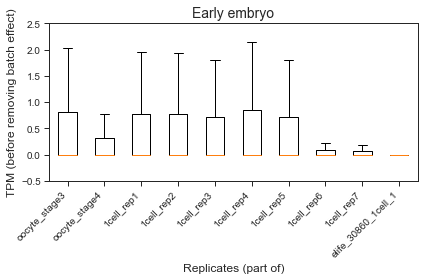

In [67]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_box_repExprDistribution_embryo_TPM_beforeNorm.pdf') as pdf_pages :
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        boxplot_tpm = expr_3id_dict_T['ovary_earlyEmbryo_TPM'].T.iloc[:-1,6:16].astype(float)
        fig, ax = plt.subplots(tight_layout = True, )
        ax.boxplot(x = boxplot_tpm,
                   showfliers = False,
                  )
        ax.set_title('Early embryo')
        ax.set_xlabel('Replicates (part of)')
        ax.set_ylabel('TPM (before removing batch effect)')
        ax.set_xticks(range(1, boxplot_tpm.shape[1] + 1))
        ax.set_xticklabels(boxplot_tpm.columns, ha = 'right', rotation = 45)
        ax.set_ylim(-0.5, 2.5)





In [74]:
expr_3id_dict_T['ovary_earlyEmbryo_TPM'].T.iloc[:-1,6:16].astype(float).mean()

oocyte_stage3          2.441826
oocyte_stage4          2.518794
1cell_rep1             2.305673
1cell_rep2             2.299503
1cell_rep3             2.227717
1cell_rep4             2.262427
1cell_rep5             2.243113
1cell_rep6             1.978279
1cell_rep7             1.976044
elife_30860_1cell_1    2.406064
dtype: float64

In [ ]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_box_repExprDistribution_embryo_TPM_beforeNorm.pdf') as pdf_pages :
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        boxplot_tpm = expr_3id_dict_T['lateEmbryo_tissue_TPM'].T.iloc[:-1,6:16]
        fig, ax = plt.subplots(tight_layout = True, )
        ax.boxplot(x = boxplot_tpm,
                   showfliers = False,
                  )
        ax.set_title('Late embryo & tissue')
        ax.set_xlabel('Replicates (part of)')
        ax.set_ylabel('TPM (before removing batch effect)')
        ax.set_xticks(range(1, boxplot_tpm.shape[1] + 1))
        ax.set_xticklabels(boxplot_tpm.columns, ha = 'right', rotation = 45)



### after normalization

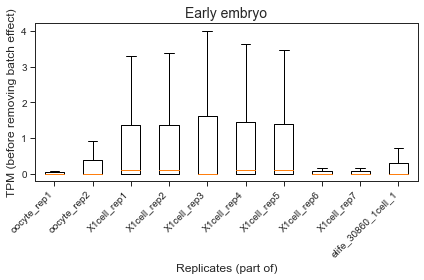

In [29]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_box_repExprDistribution_embryo_TPM_afterNorm.pdf') as pdf_pages :
    with sns.axes_style('white', rc={
            'xtick.bottom': True,
            'ytick.left': True
    }), sns.plotting_context('paper',
                             rc={
                                 'axes.titlesize': 14,
                                 'axes.labelsize': 12,
                                 'xtick.labelsize': 10,
                                 'ytick.labelsize': 10,
                                 'legend.fontsize': 10
                             }):
        boxplot_tpm = expr_combat_dict['ovary_earlyEmbryo_TPM'].iloc[:,:10].astype(float)
        fig, ax = plt.subplots(tight_layout = True, )
        ax.boxplot(x = boxplot_tpm,
                   showfliers = False,
                  )
        ax.set_title('Early embryo')
        ax.set_xlabel('Replicates (part of)')
        ax.set_ylabel('TPM (before removing batch effect)')
        ax.set_xticks(range(1, boxplot_tpm.shape[1] + 1))
        ax.set_xticklabels(boxplot_tpm.columns, ha = 'right', rotation = 45)
#         ax.set_ylim(0, 2.5)





In [75]:
expr_combat_dict['ovary_earlyEmbryo_TPM'].iloc[:,:10].astype(float).mean()

oocyte_rep1            2.022594
oocyte_rep2            2.223389
X1cell_rep1            2.195088
X1cell_rep2            2.196688
X1cell_rep3            2.176703
X1cell_rep4            2.206377
X1cell_rep5            2.220501
X1cell_rep6            1.888276
X1cell_rep7            1.868295
elife_30860_1cell_1    2.111013
dtype: float64

# rep corr

## TPM

### before normalization

<ipython-input-187-f21ef8d68e9d>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


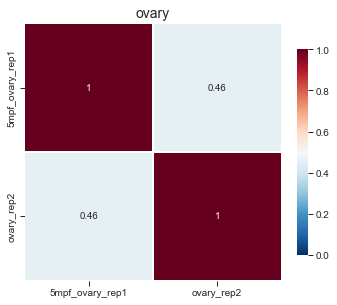

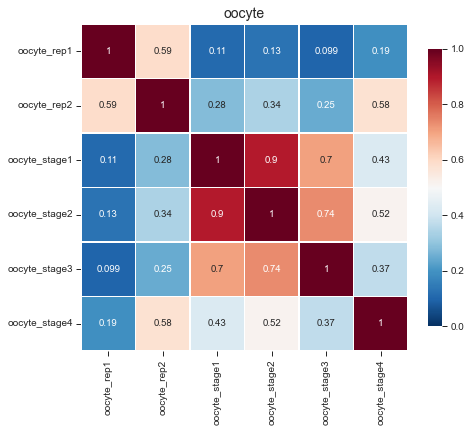

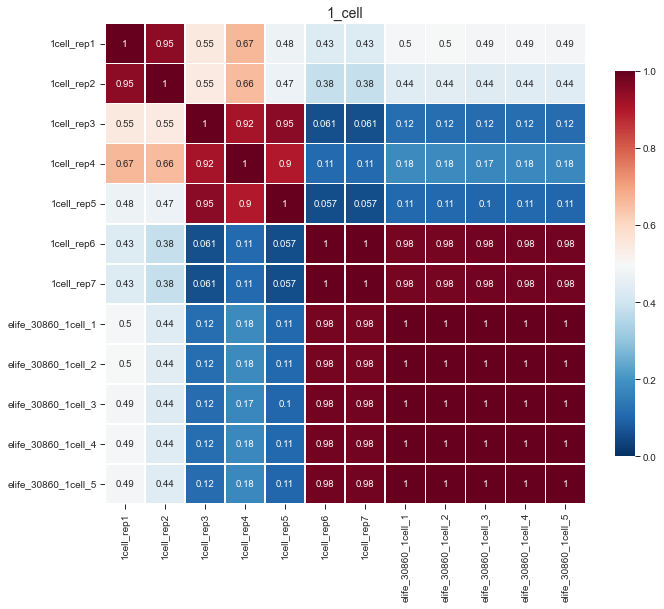

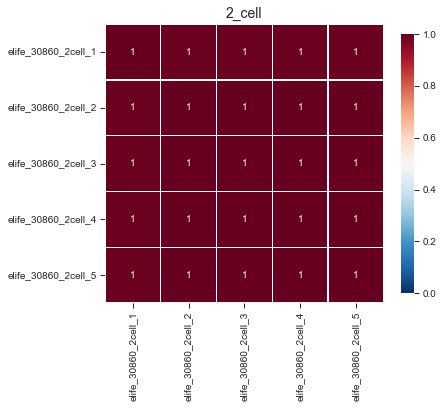

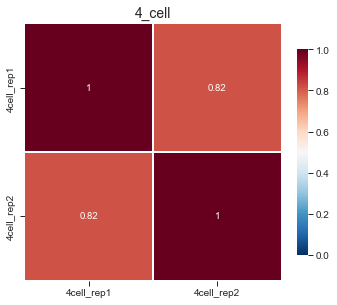

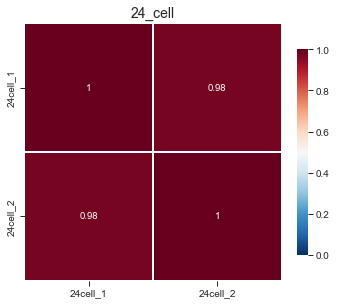

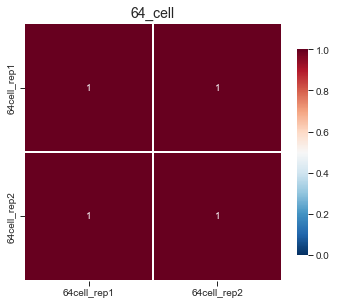

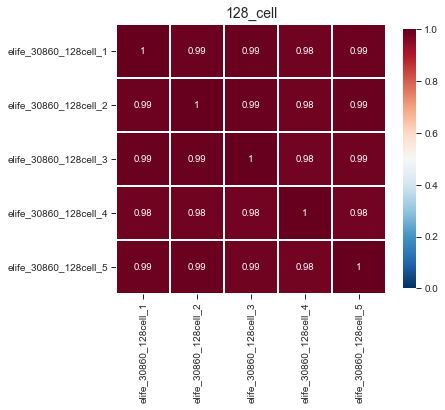

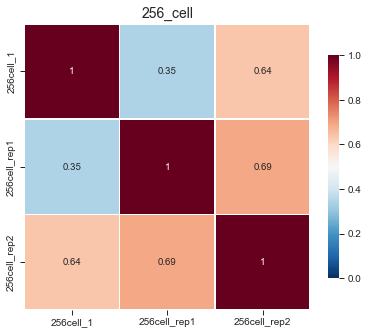

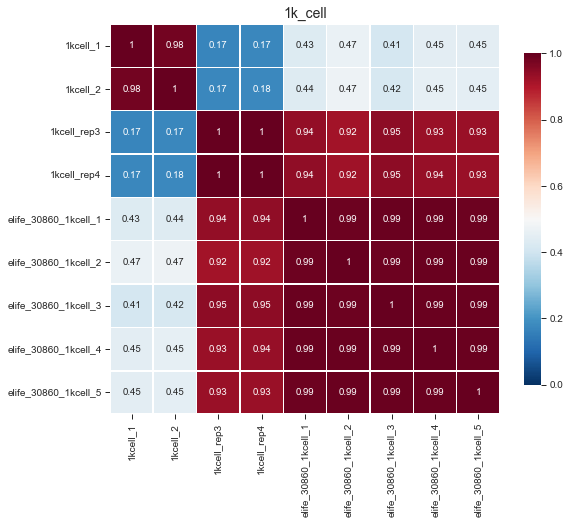

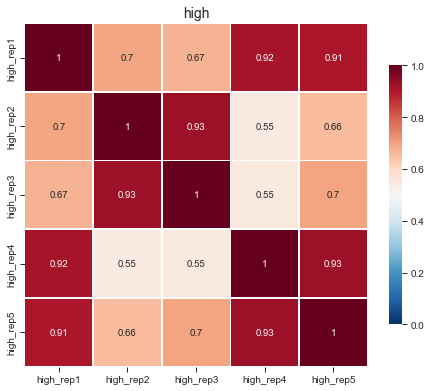

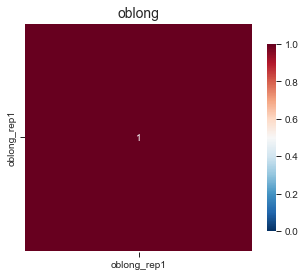

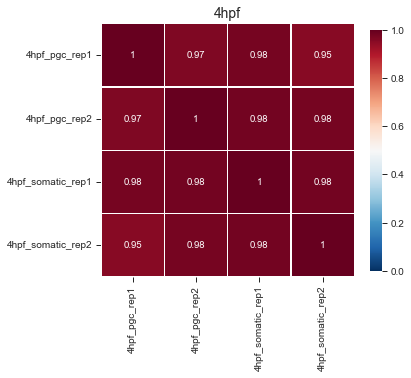

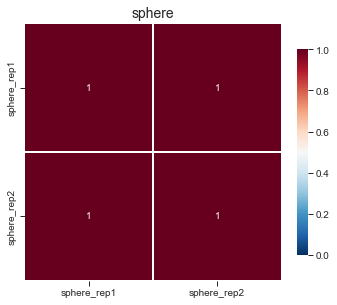

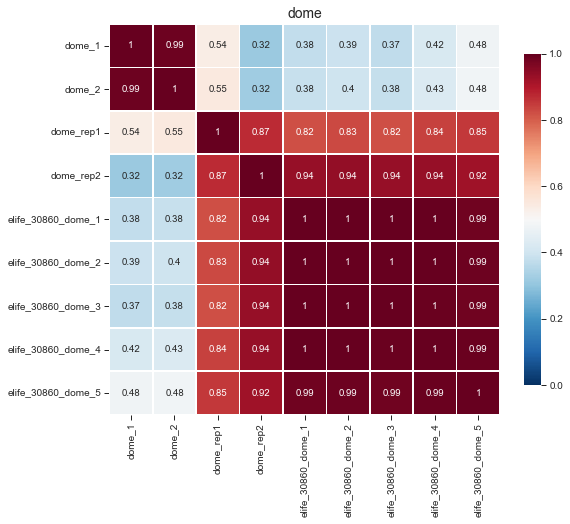

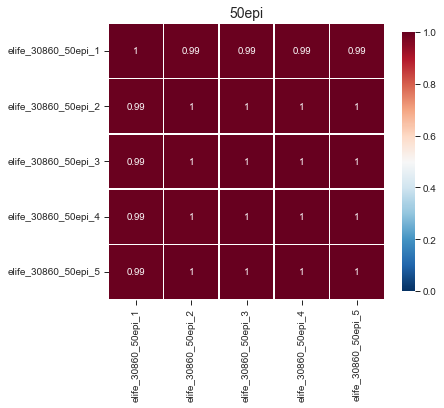

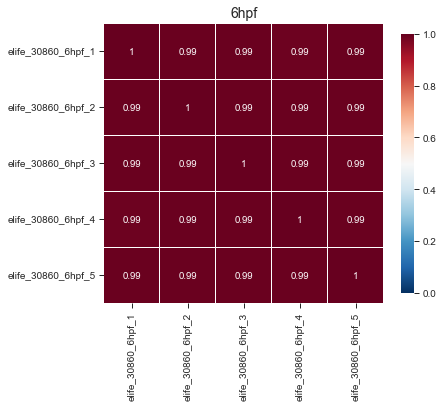

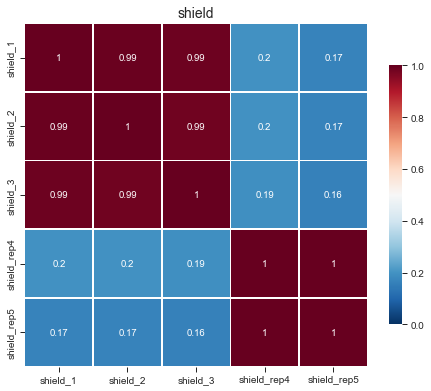

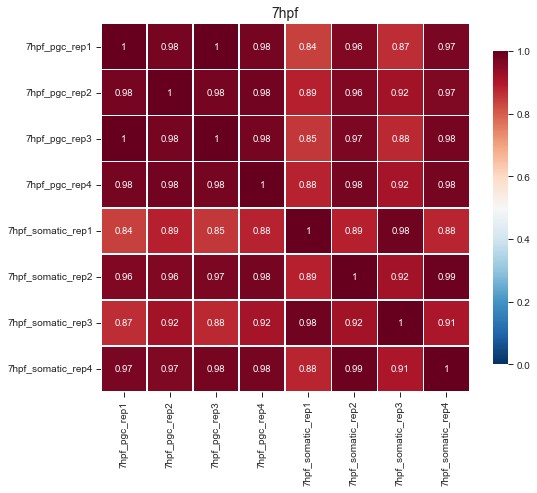

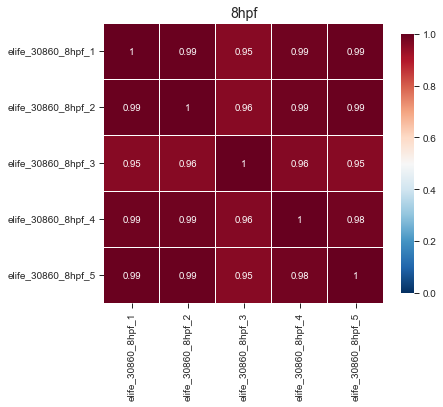

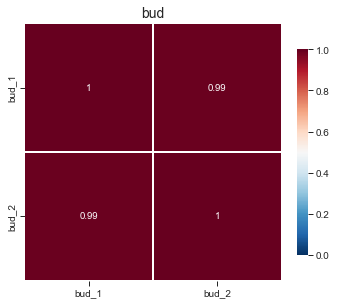

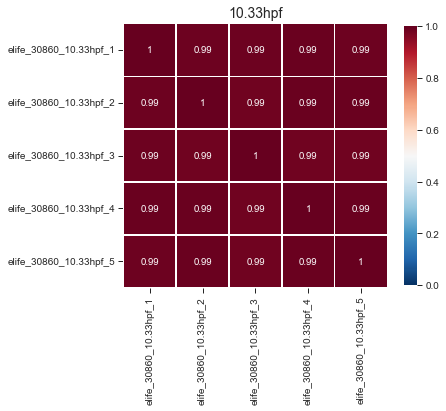

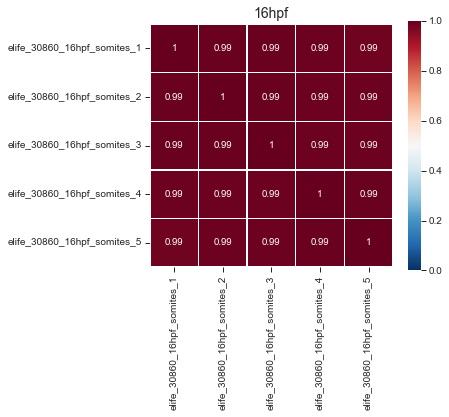

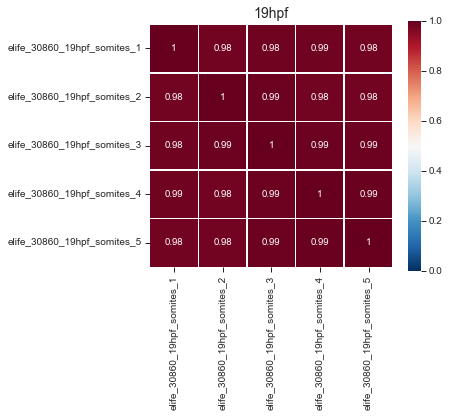

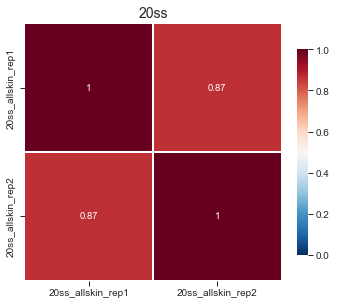

In [187]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_embryo_TPM_beforeNorm.pdf') as pdf_pages :
    for stage in ovary_earlyEmbryo_TPM_stages_uniq :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_3id_dict_T['ovary_earlyEmbryo_TPM'].loc[[x == stage for x in ovary_earlyEmbryo_TPM_stages]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(stage)
            
            pdf_pages.savefig(fig)

<ipython-input-188-4dddc76a4890>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


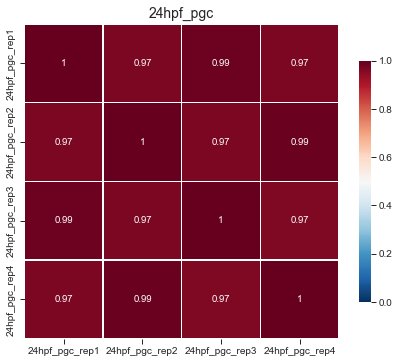

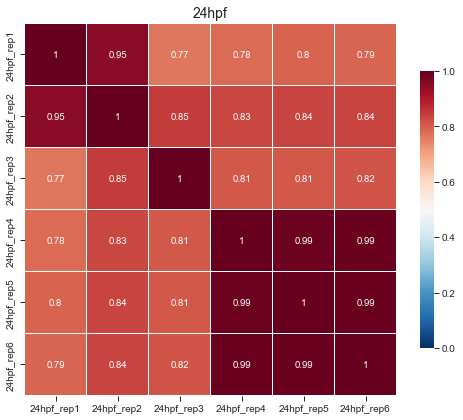

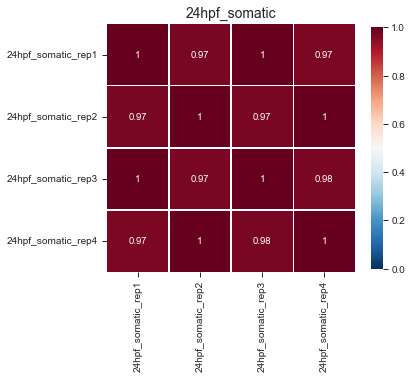

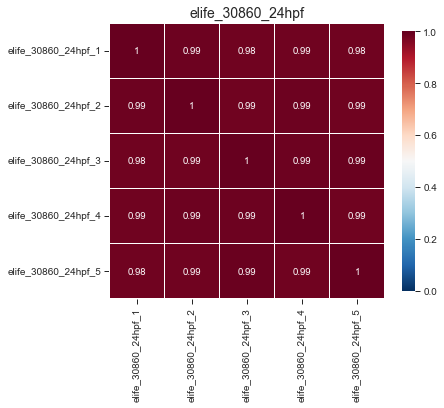

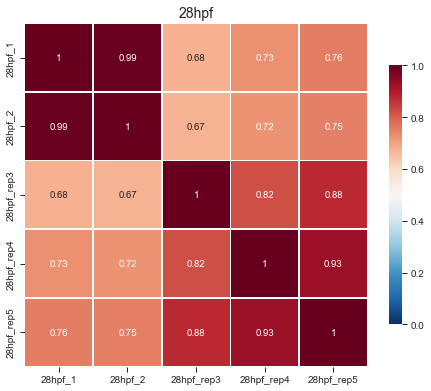

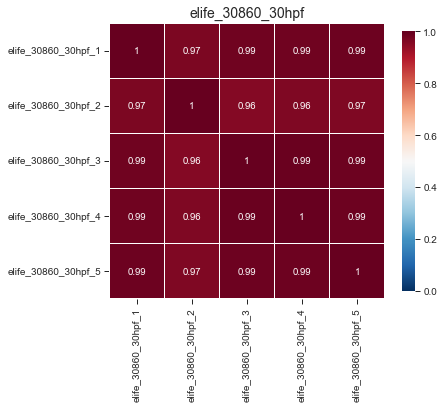

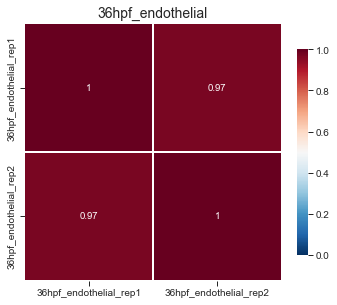

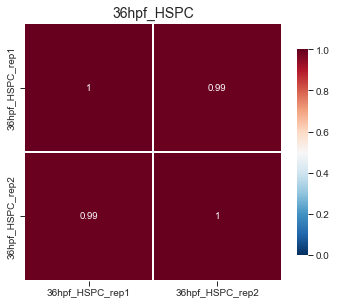

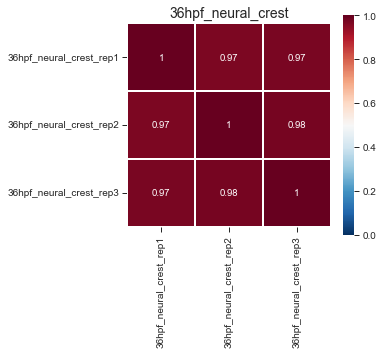

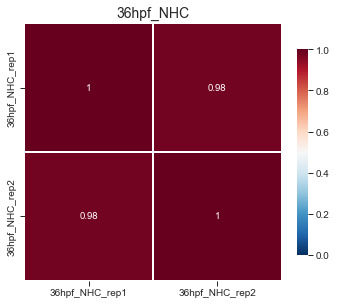

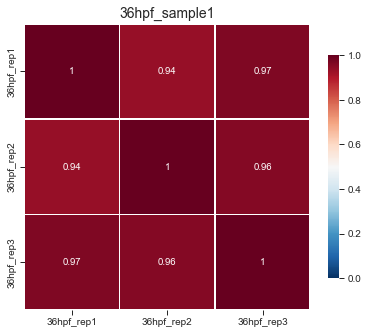

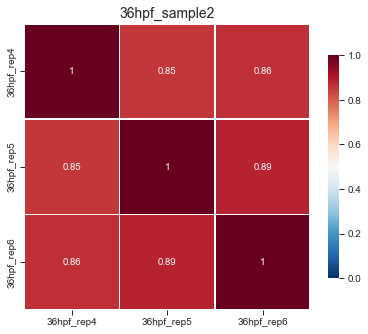

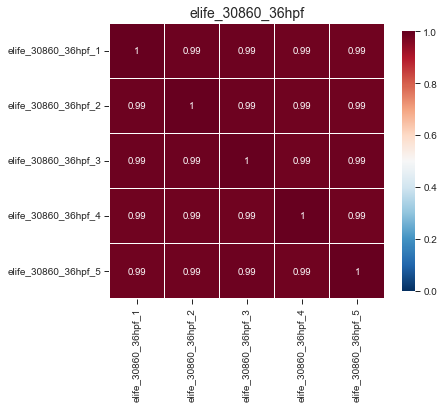

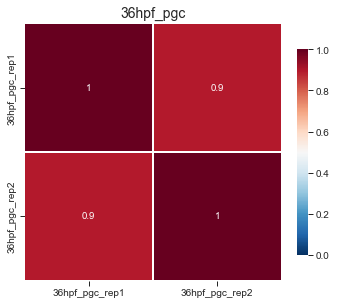

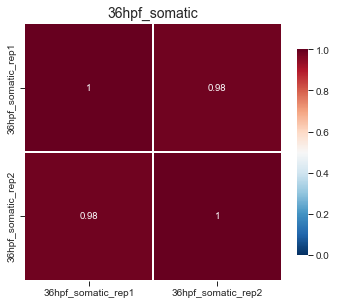

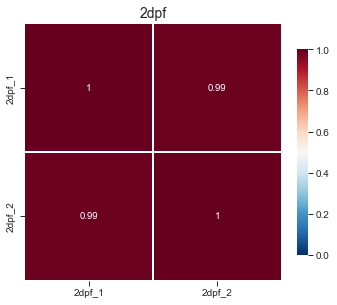

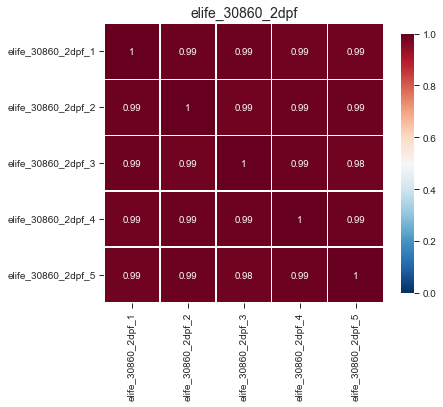

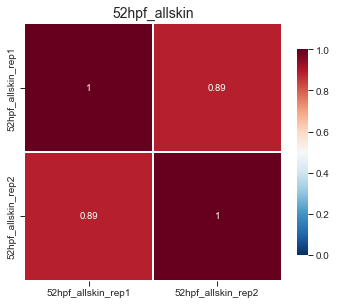

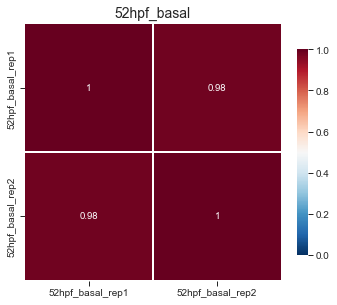

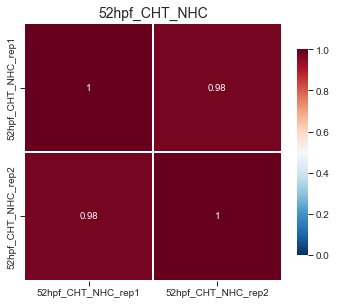

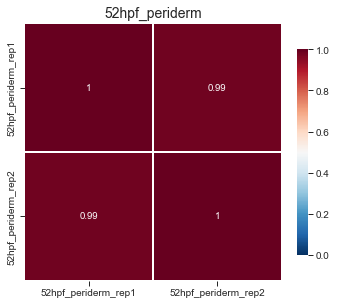

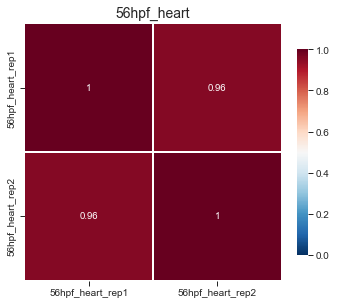

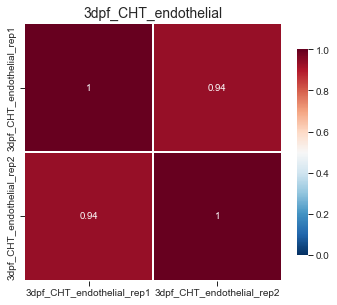

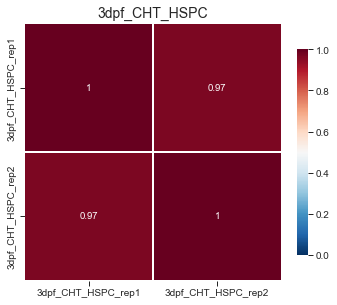

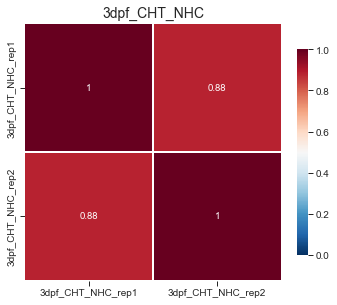

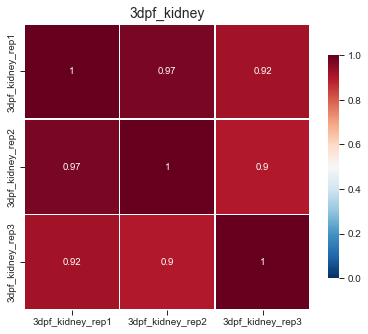

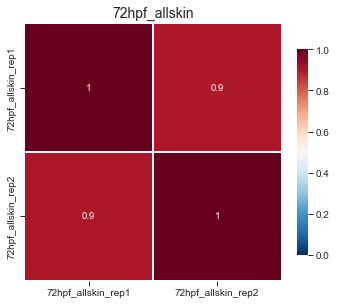

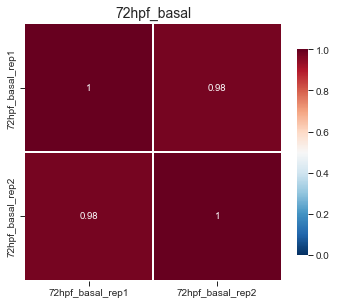

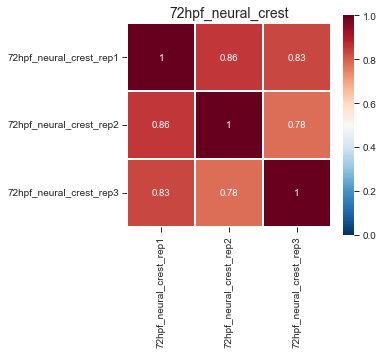

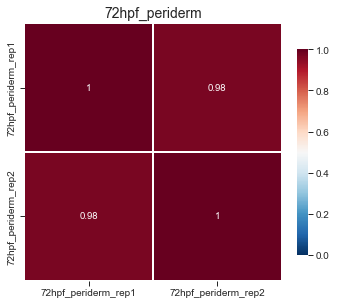

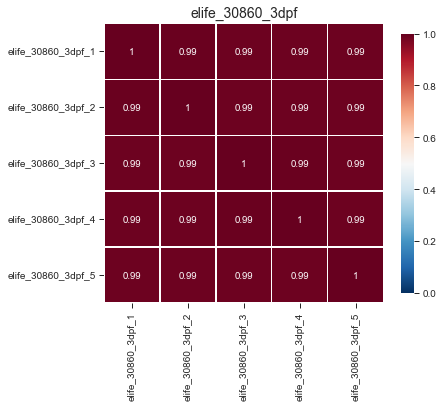

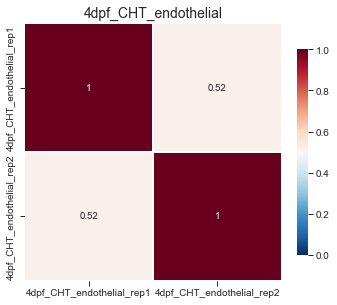

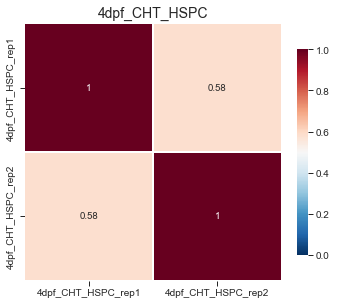

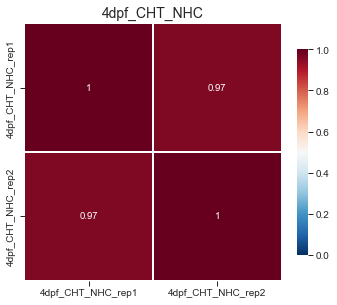

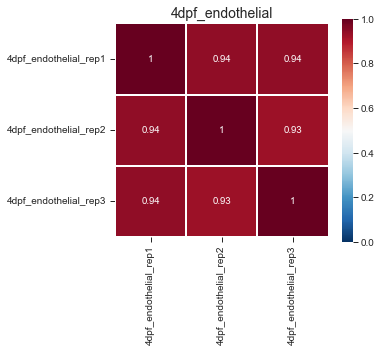

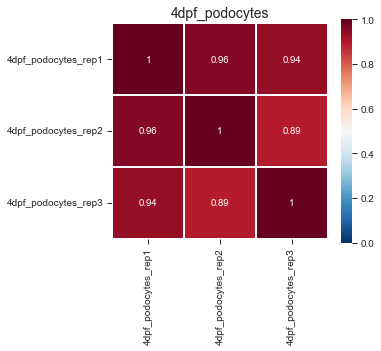

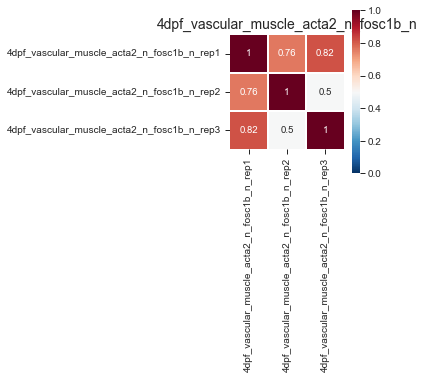

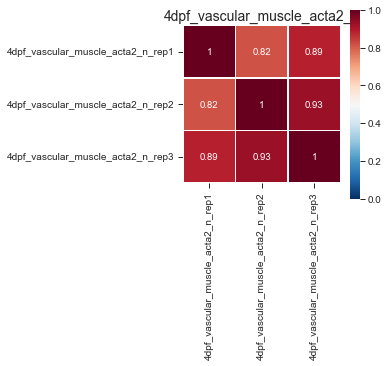

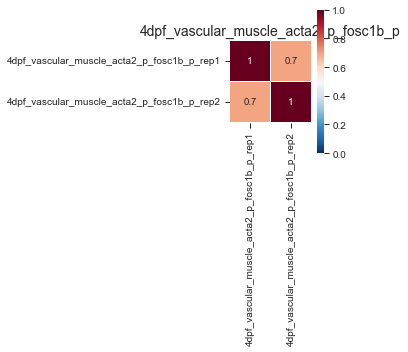

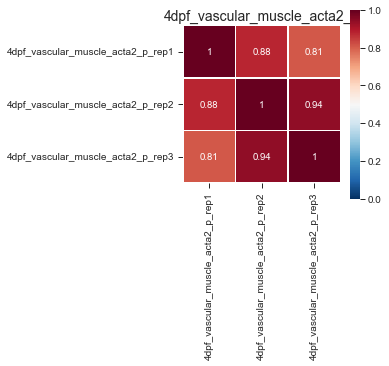

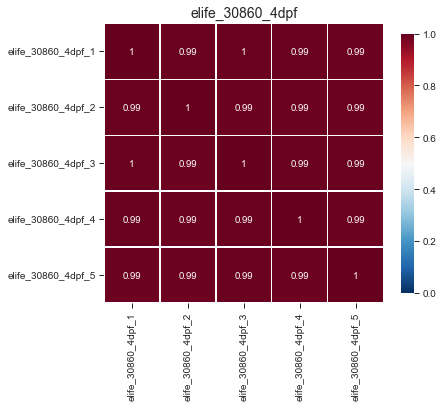

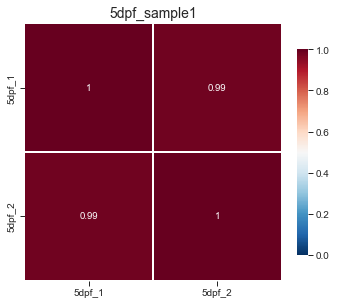

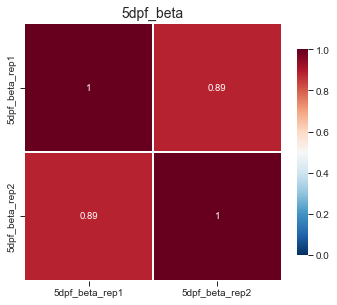

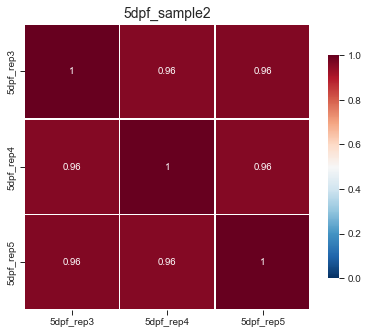

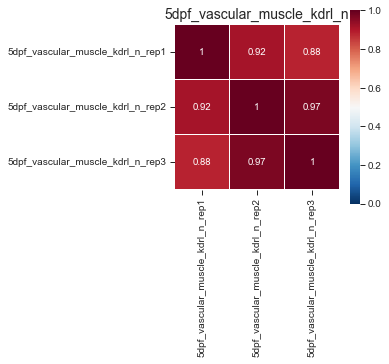

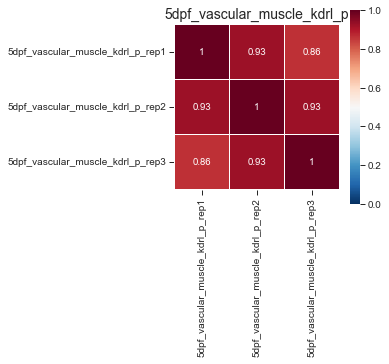

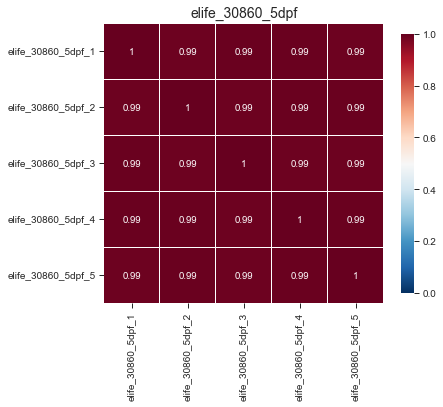

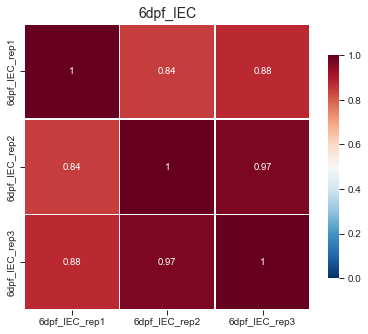

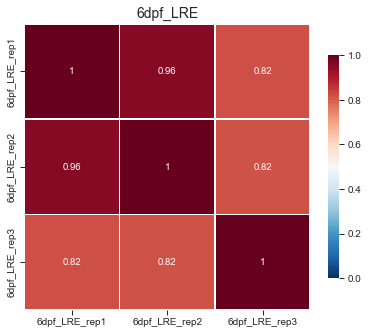

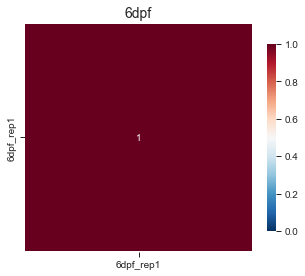

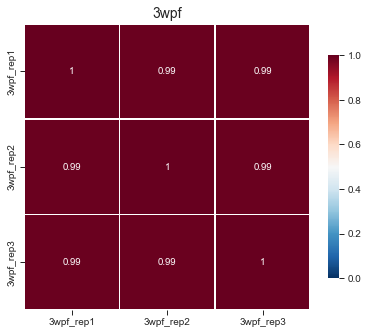

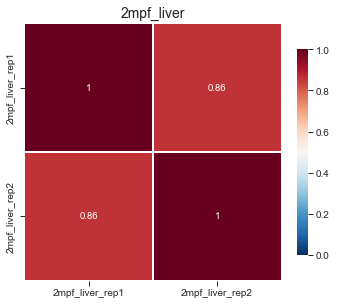

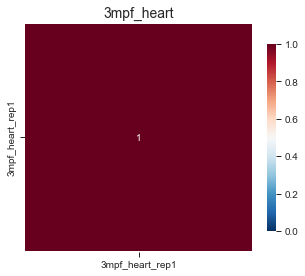

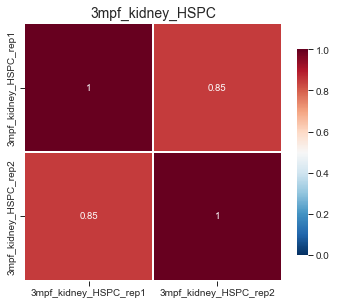

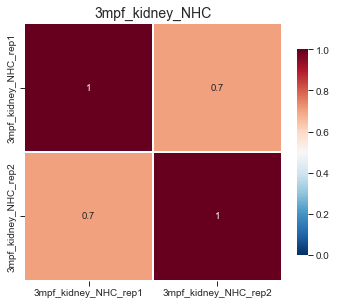

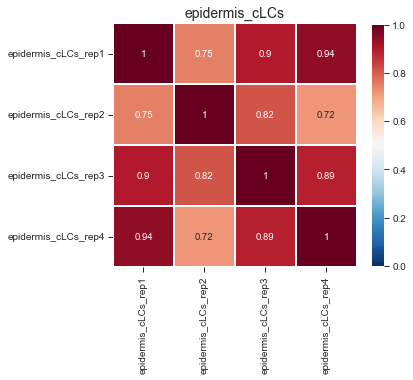

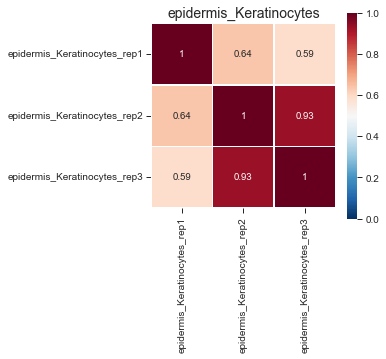

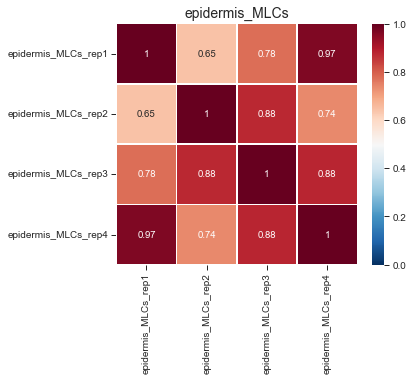

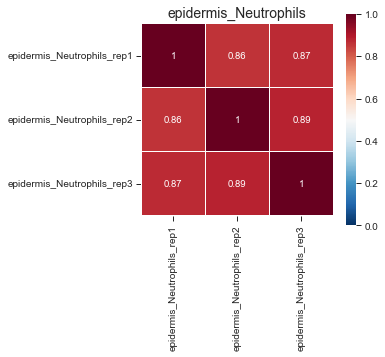

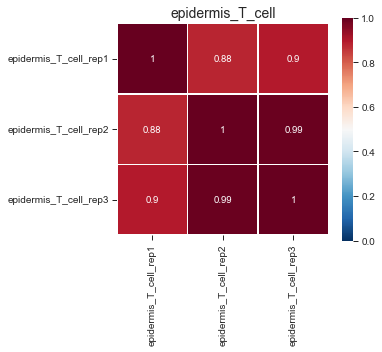

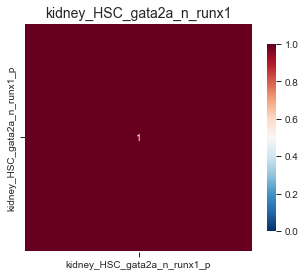

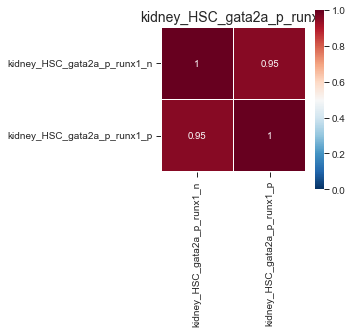

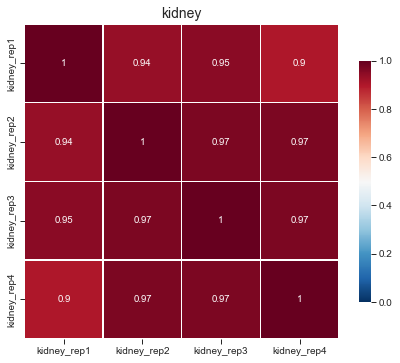

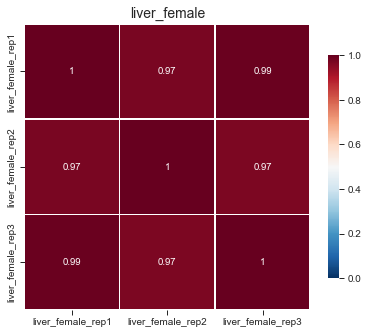

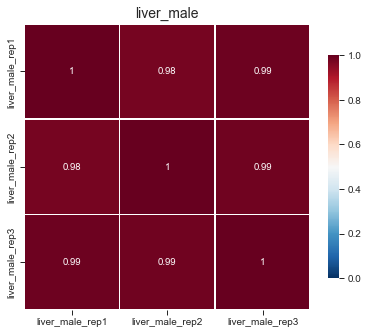

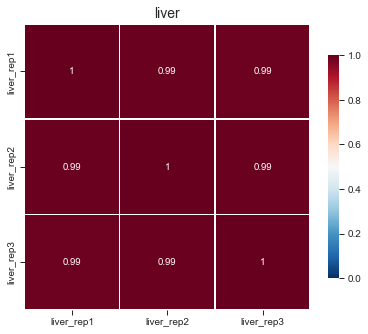

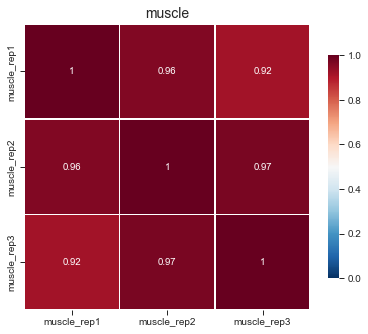

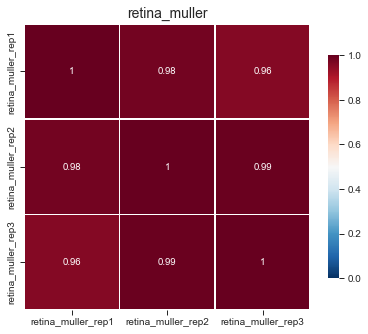

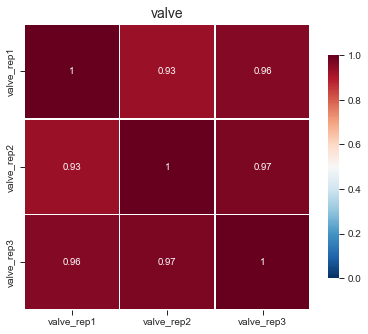

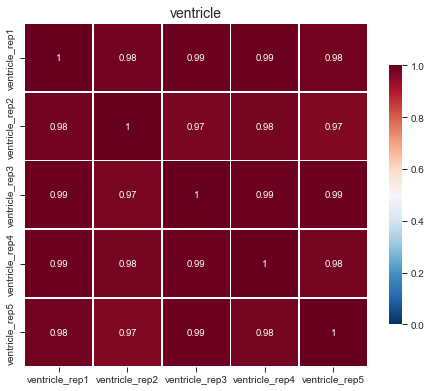

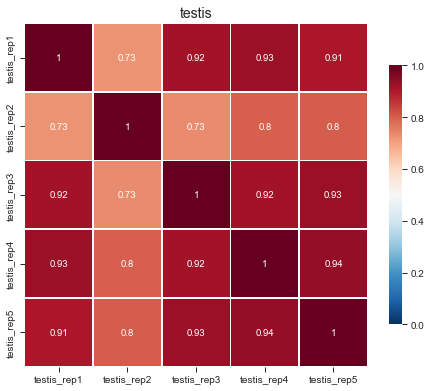

In [188]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_tissueBySamples_TPM_beforeNorm.pdf') as pdf_pages :
    for sample in lateEmbryo_tissue_TPM_samples_uniq :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_3id_dict_T['lateEmbryo_tissue_TPM'].loc[[x == sample for x in lateEmbryo_tissue_TPM_samples]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(sample)
            
            pdf_pages.savefig(fig)

### z-score (not used)

The correlation for z-score is acctually same with raw data.

<ipython-input-186-5eb4cab279ea>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


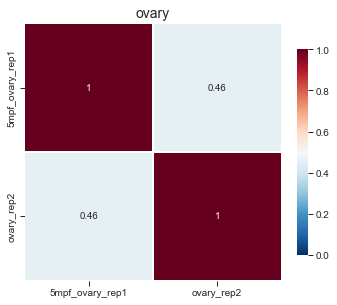

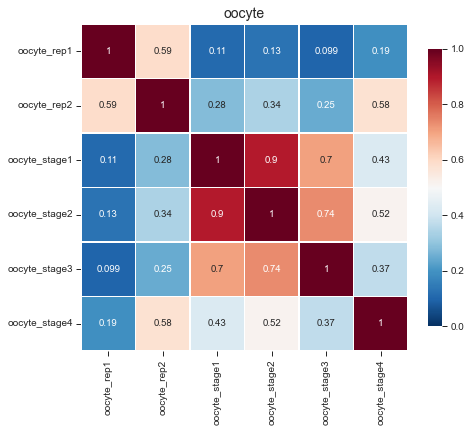

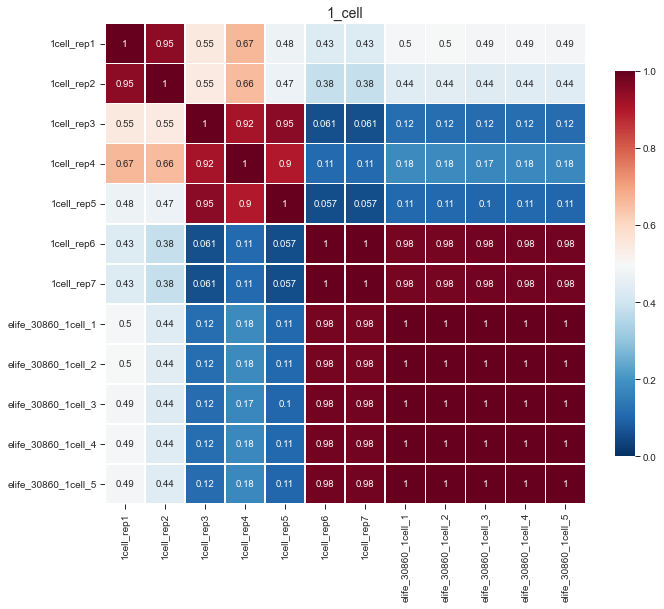

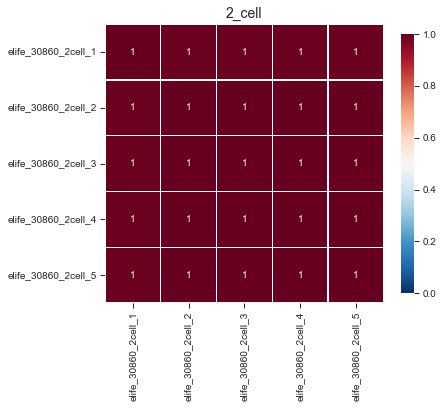

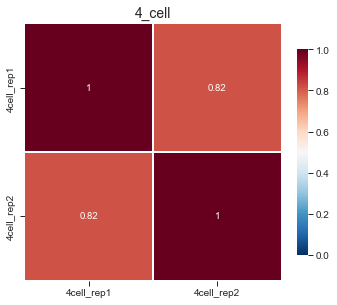

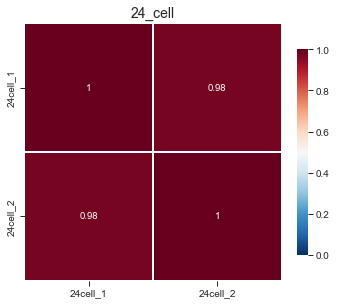

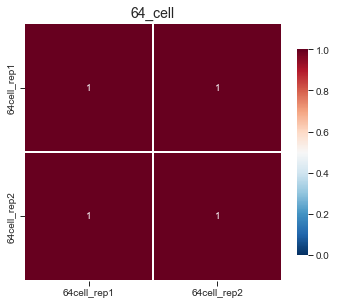

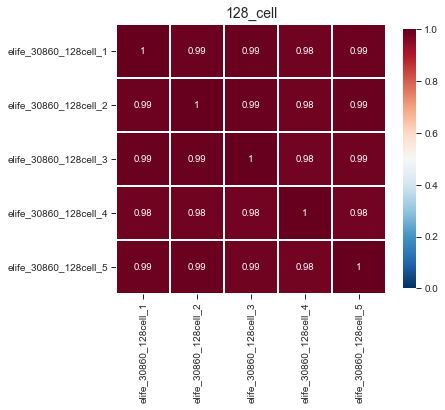

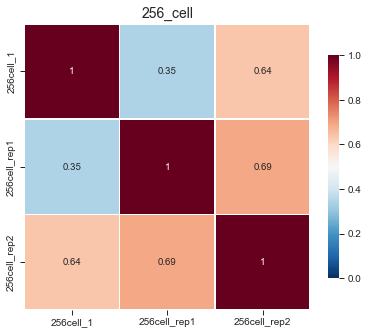

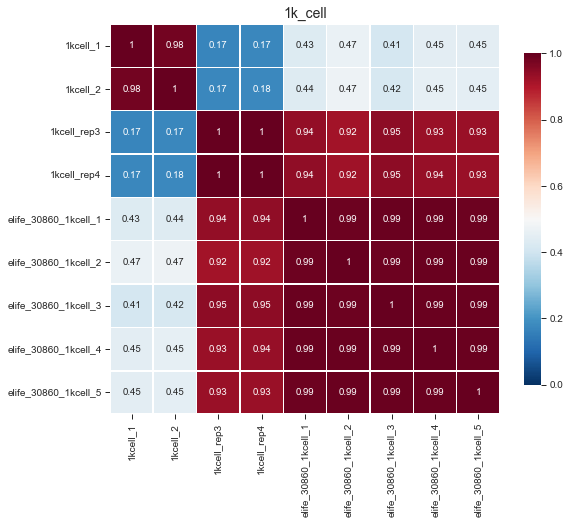

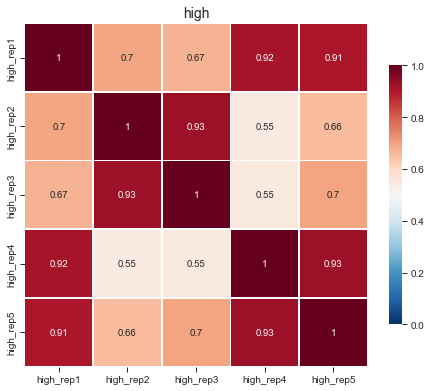

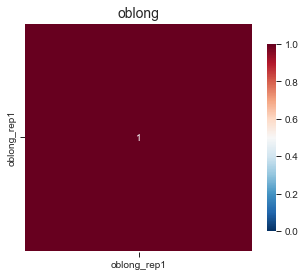

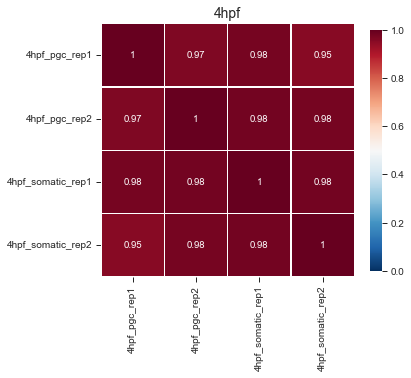

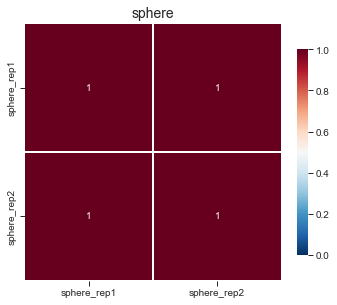

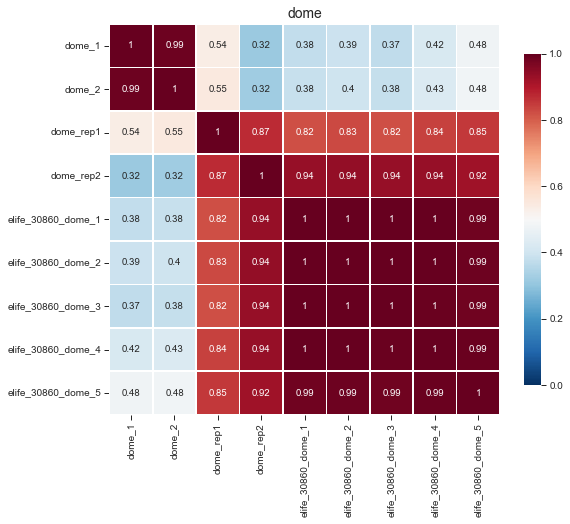

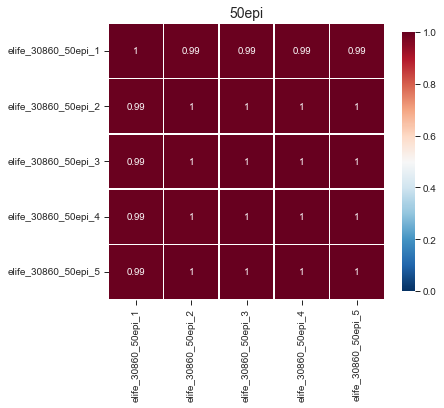

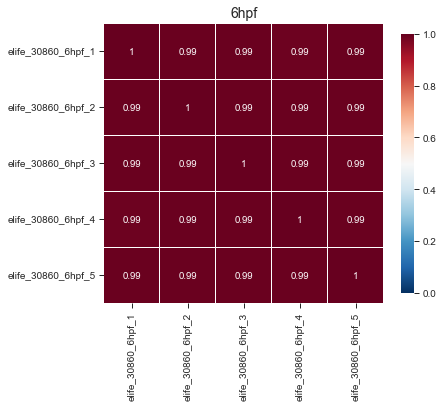

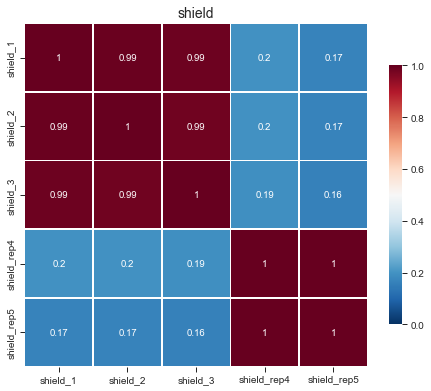

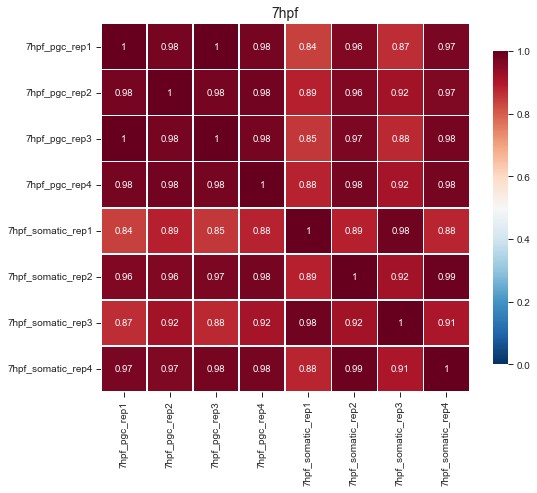

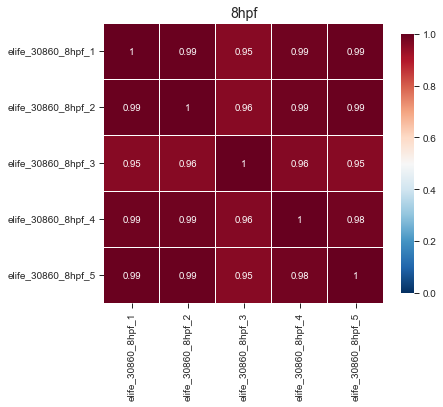

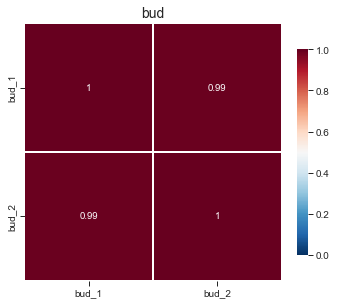

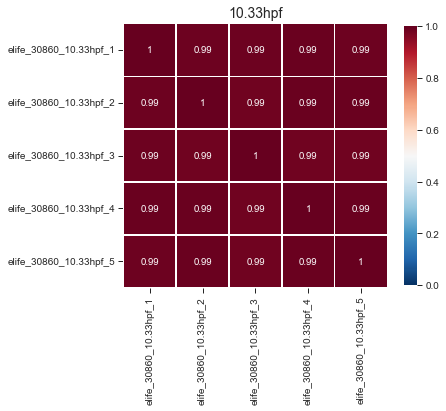

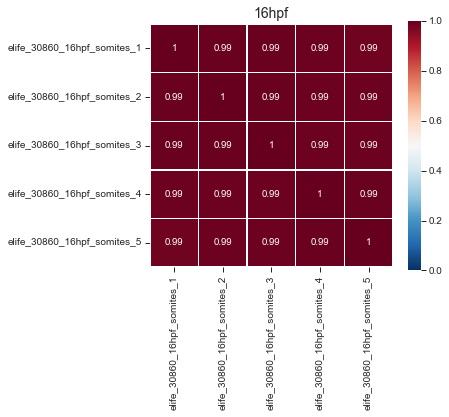

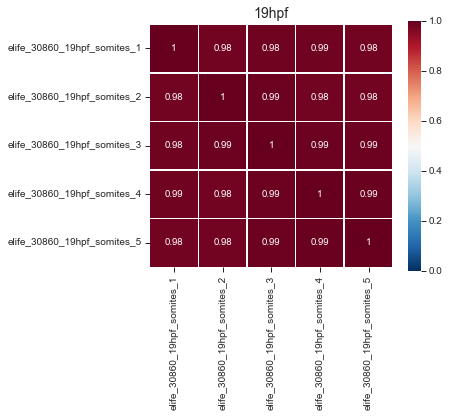

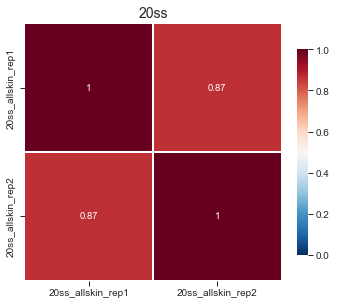

In [186]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_embryo_TPM_zscore.pdf') as pdf_pages :
    for stage in ovary_earlyEmbryo_TPM_stages_uniq :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_3id_dict_T_z['ovary_earlyEmbryo_TPM'].loc[[x == stage for x in ovary_earlyEmbryo_TPM_stages]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(stage)
            
            pdf_pages.savefig(fig)

<ipython-input-177-619ea1c79b6d>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


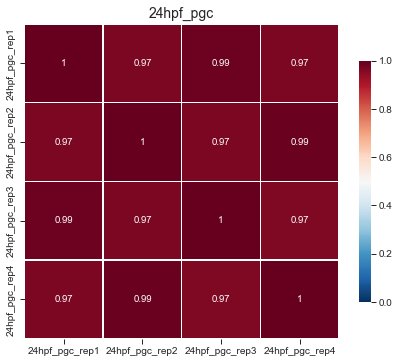

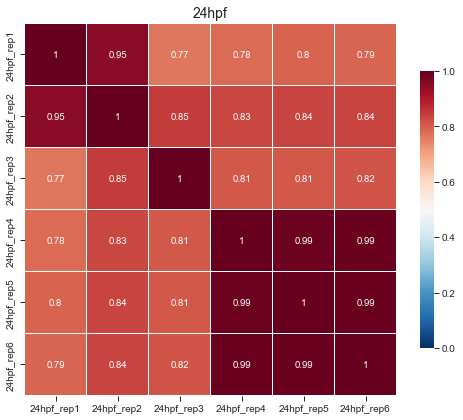

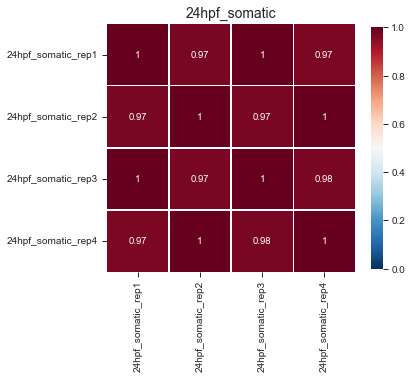

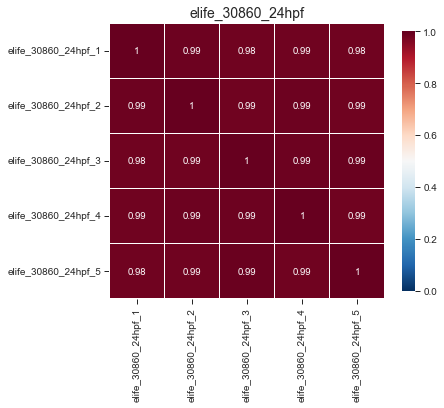

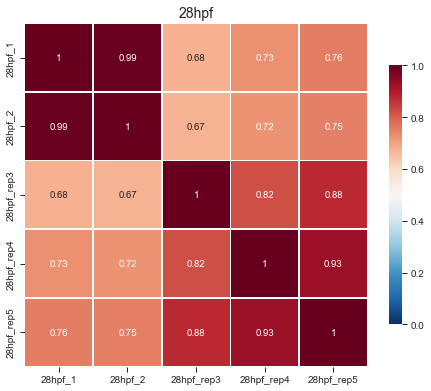

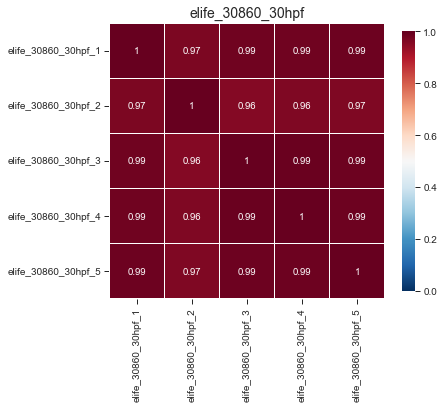

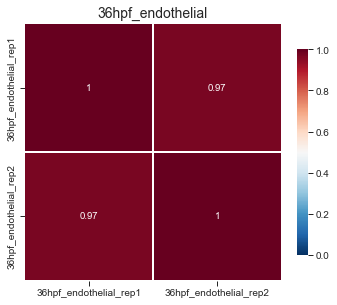

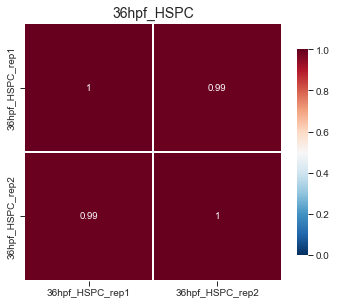

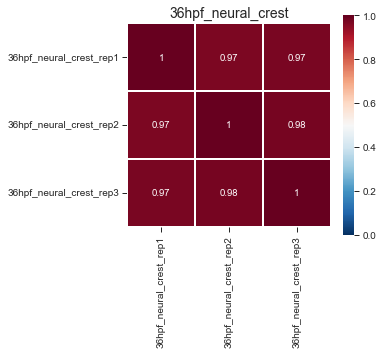

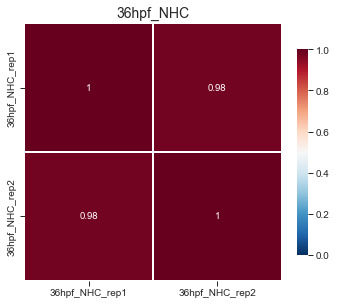

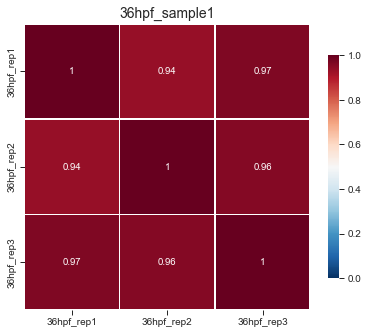

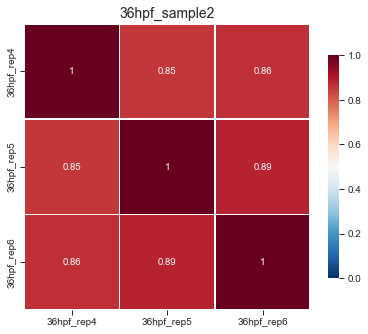

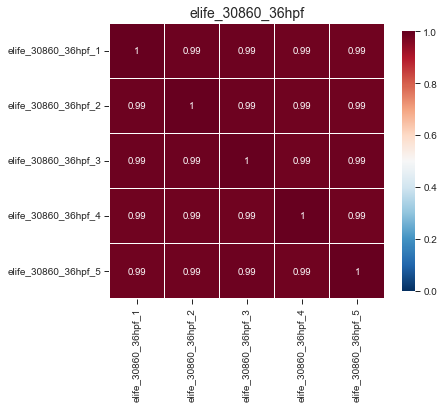

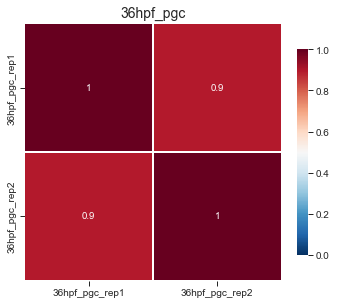

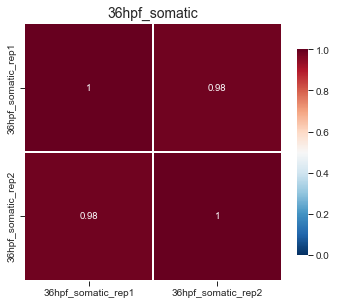

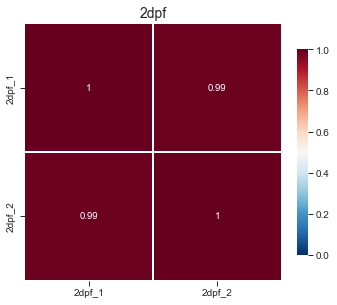

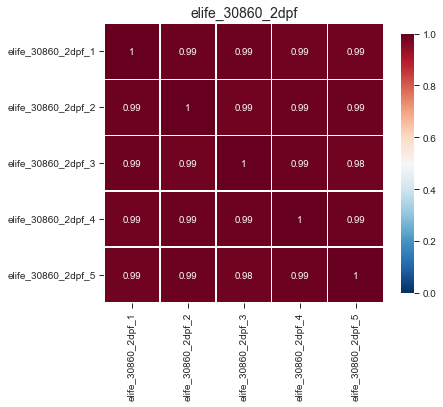

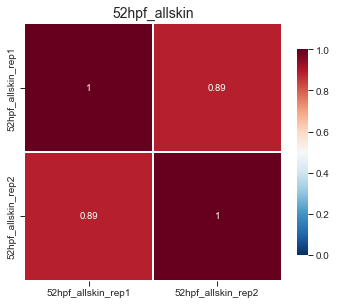

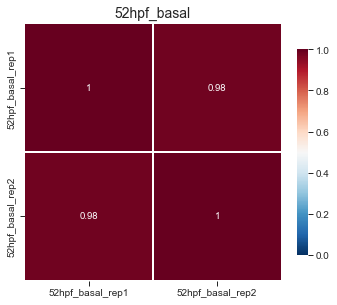

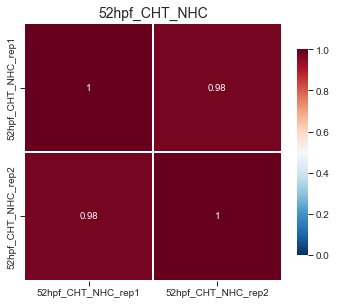

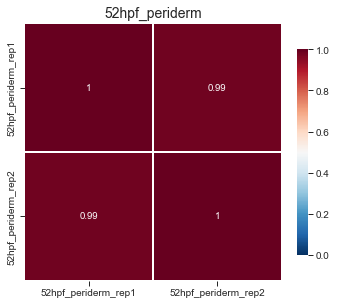

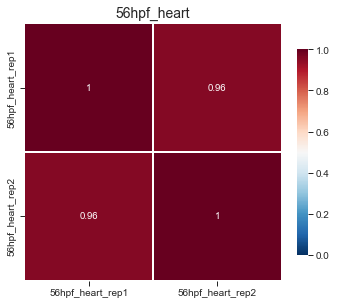

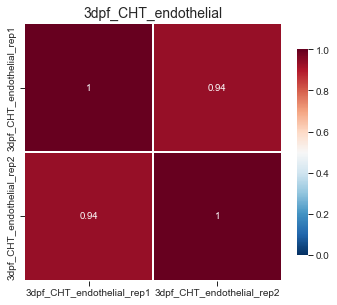

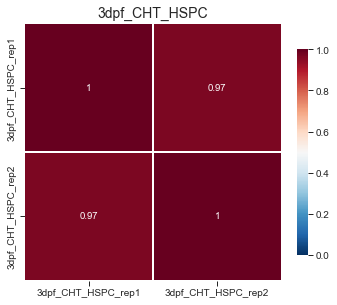

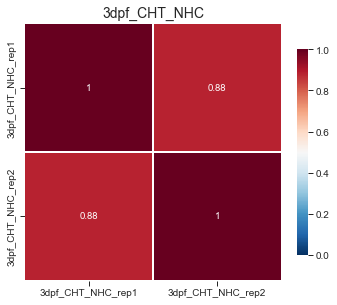

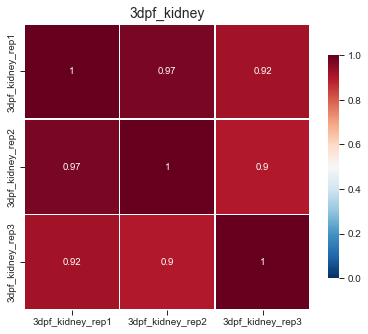

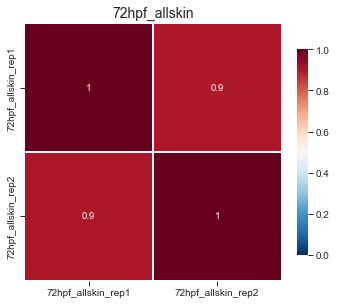

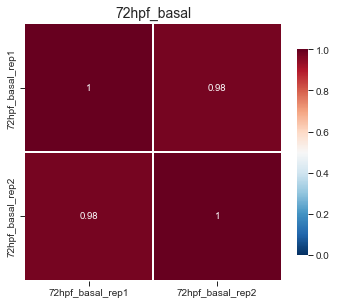

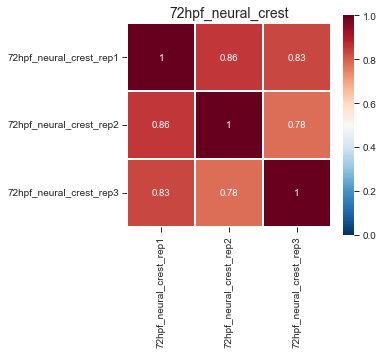

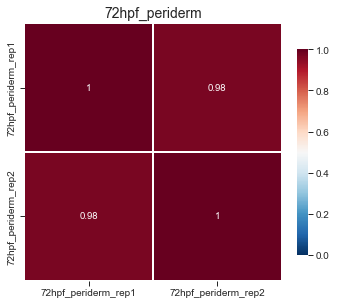

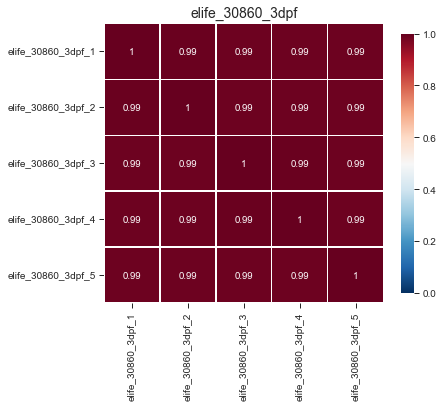

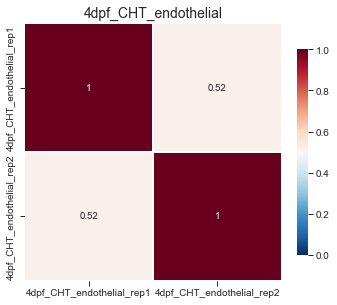

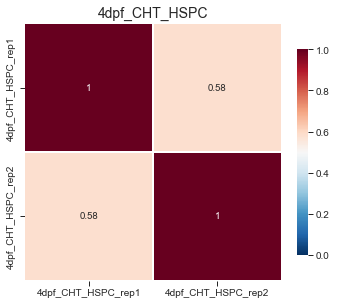

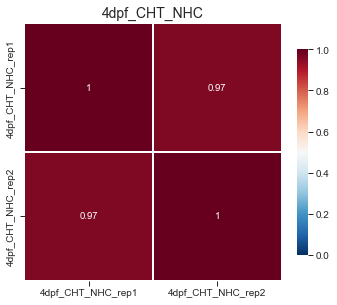

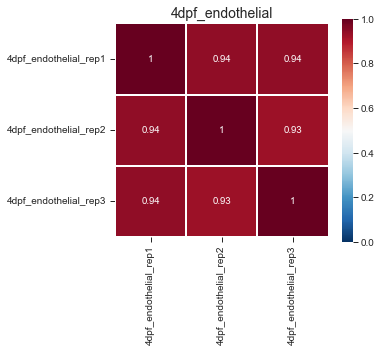

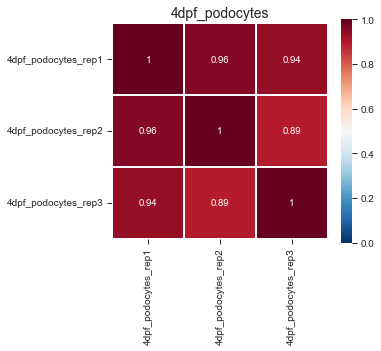

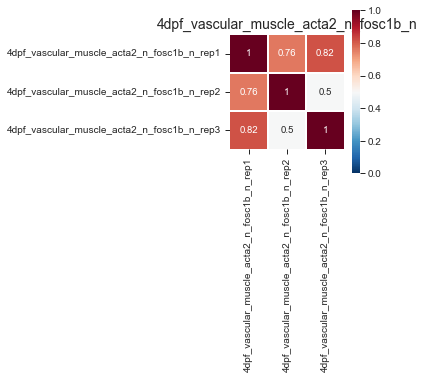

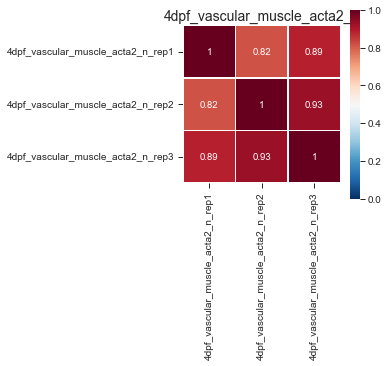

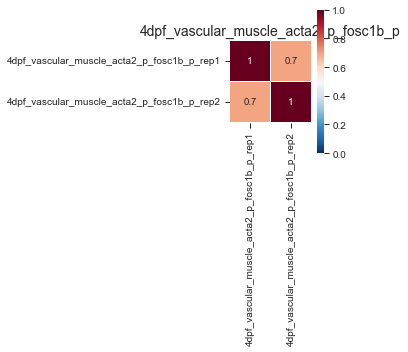

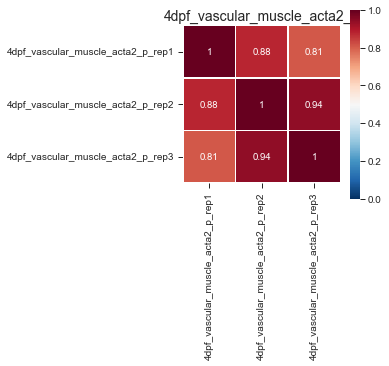

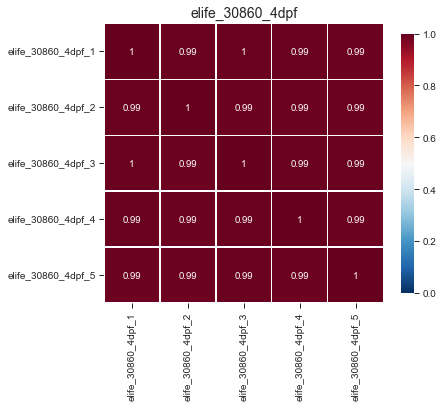

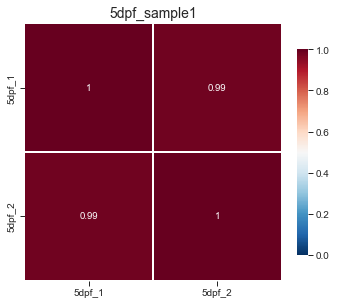

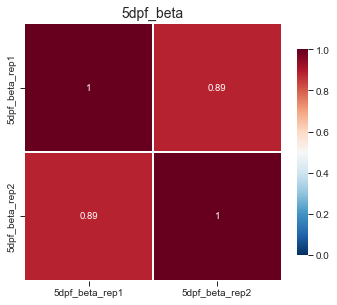

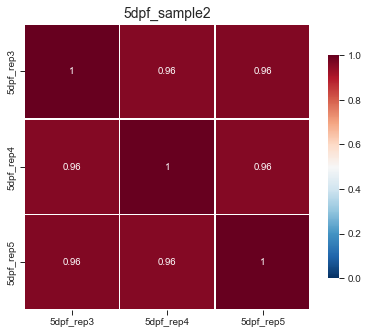

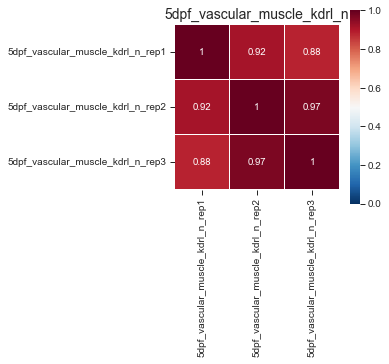

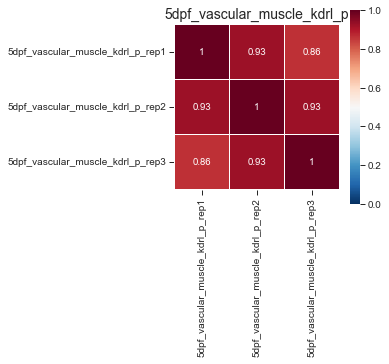

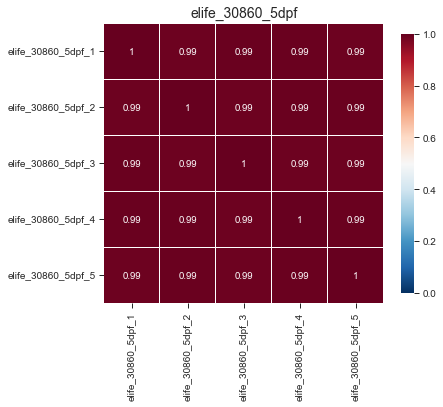

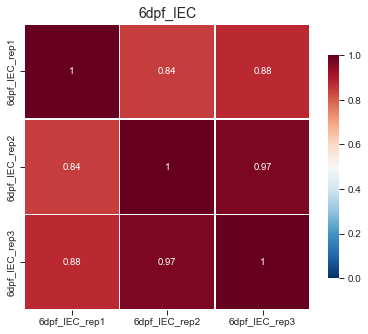

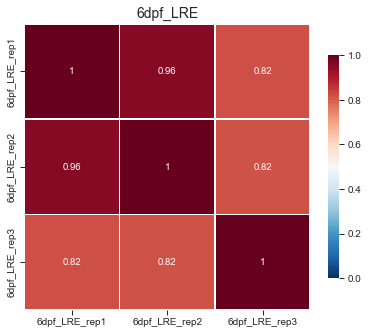

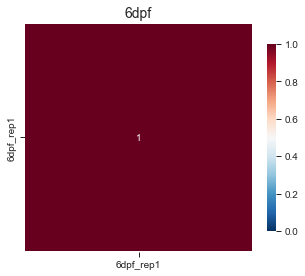

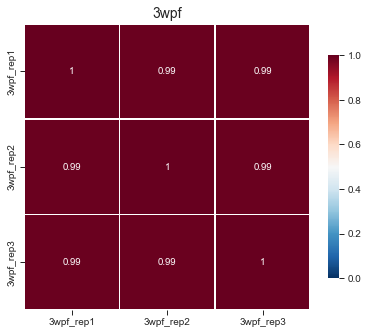

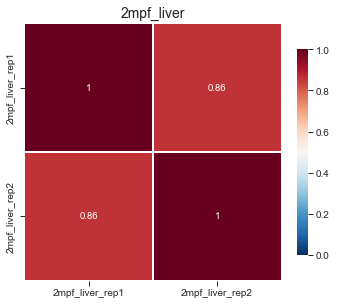

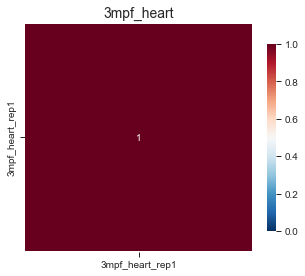

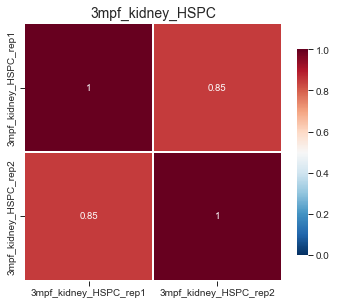

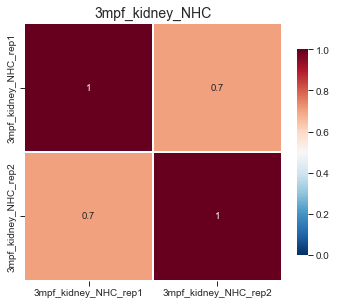

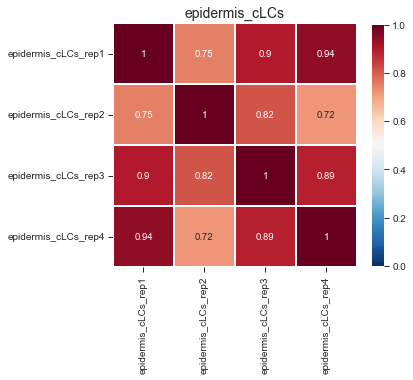

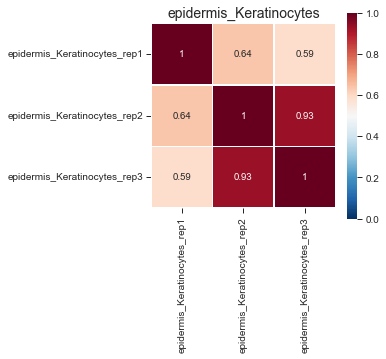

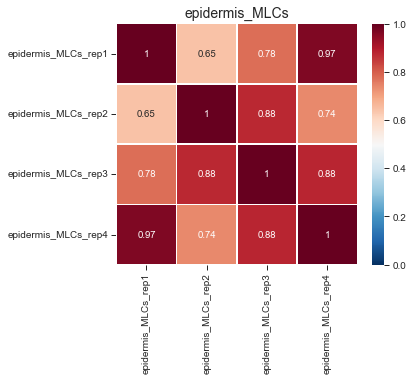

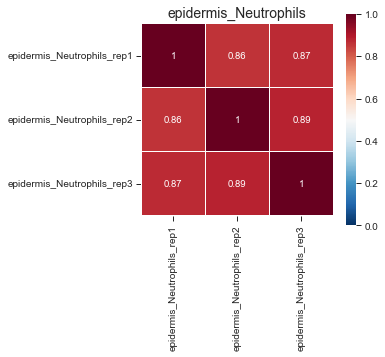

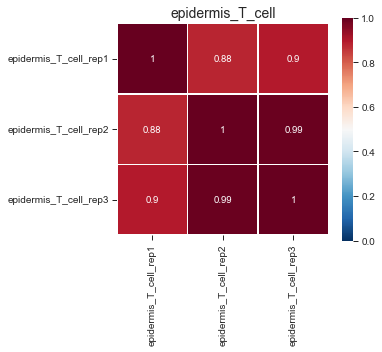

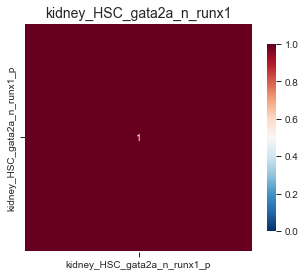

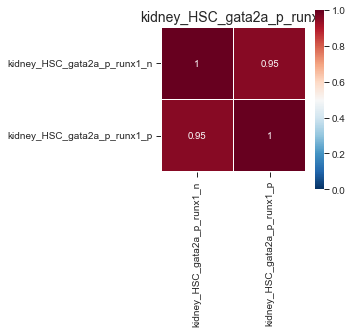

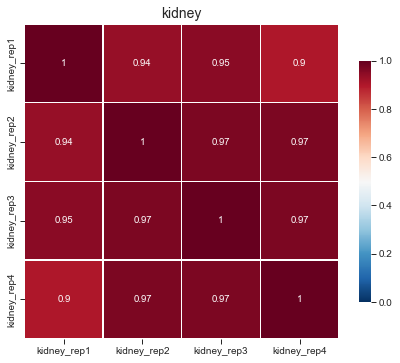

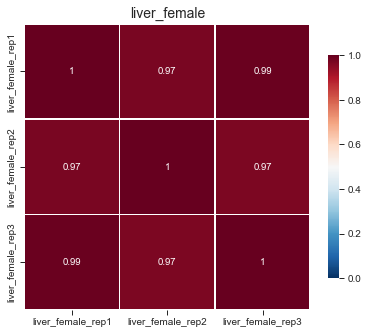

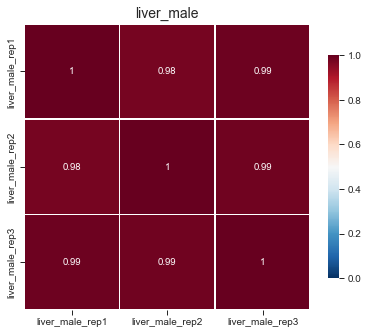

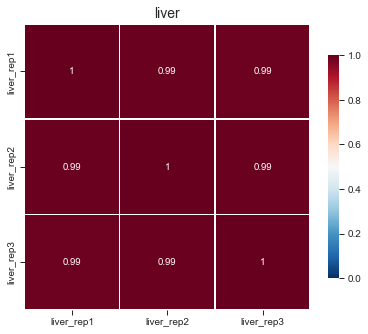

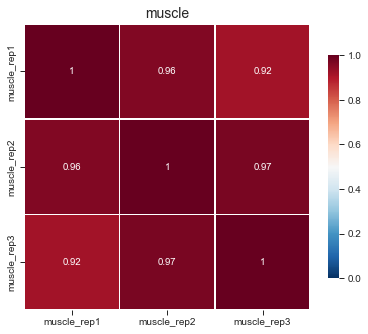

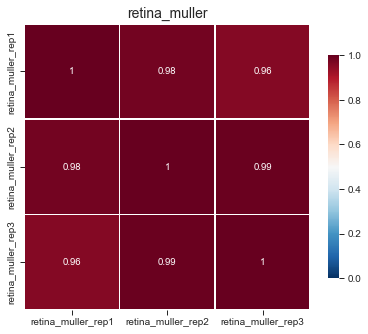

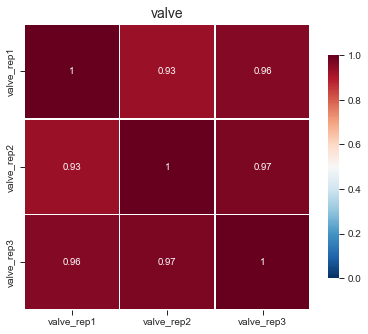

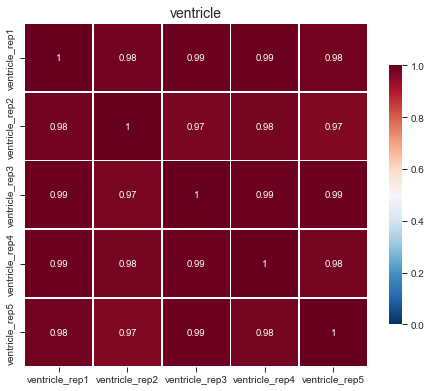

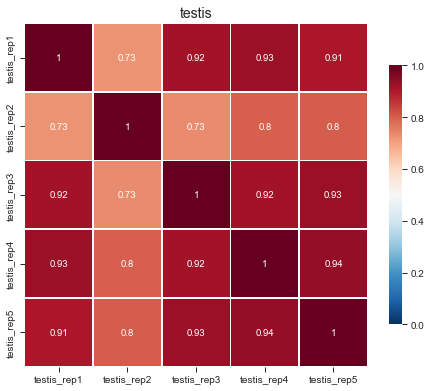

In [177]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_tissueBySamples_TPM_zscore.pdf') as pdf_pages :
    for sample in lateEmbryo_tissue_TPM_samples_uniq :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_3id_dict_T_z['lateEmbryo_tissue_TPM'].loc[[x == sample for x in lateEmbryo_tissue_TPM_samples]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(sample)
            
            pdf_pages.savefig(fig)

### Combat TPM

<ipython-input-153-fecfff82005a>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


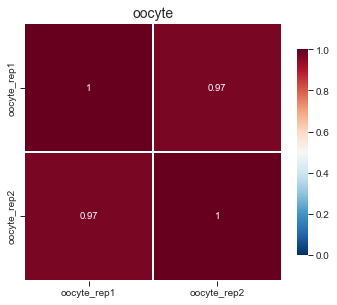

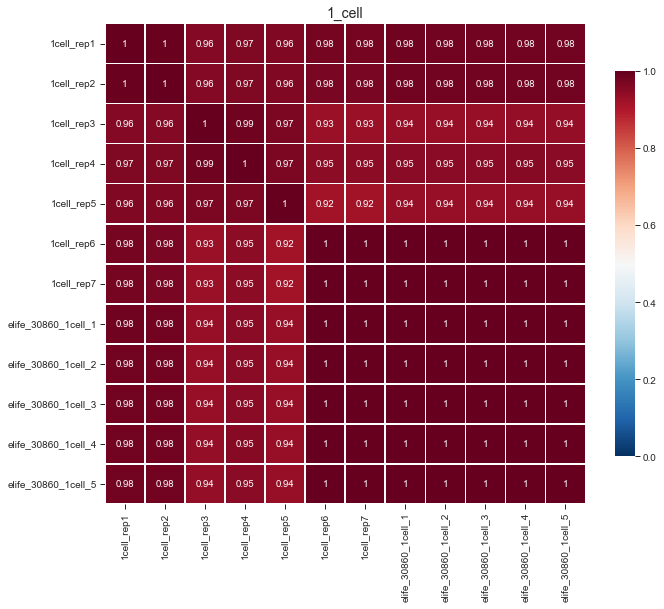

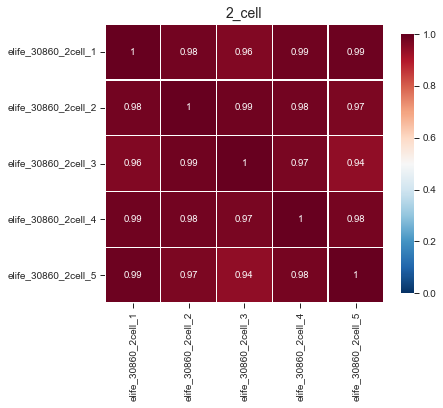

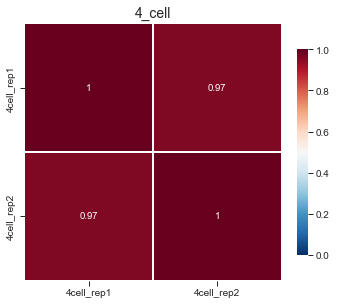

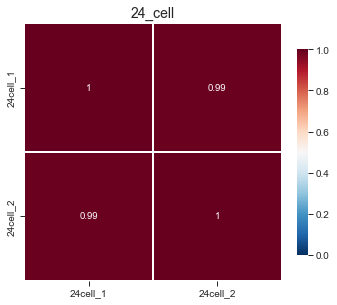

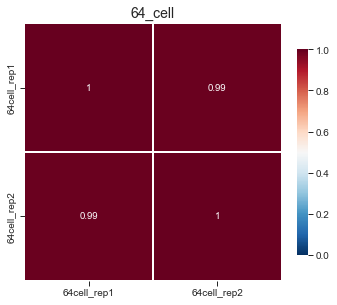

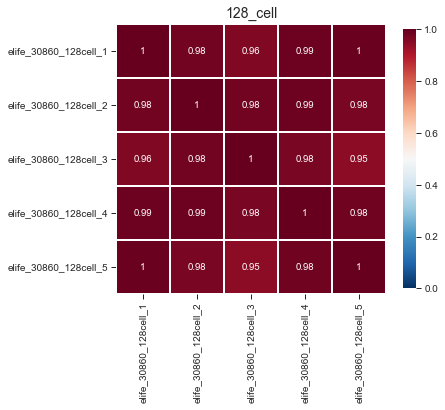

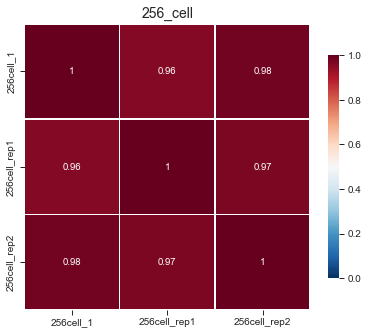

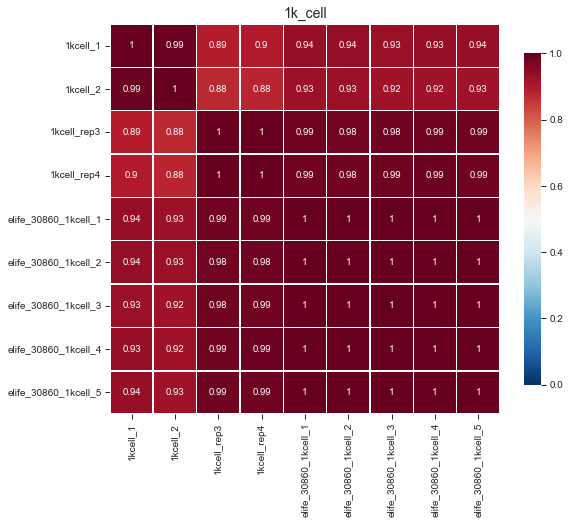

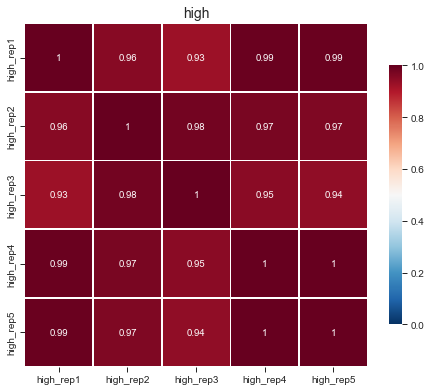

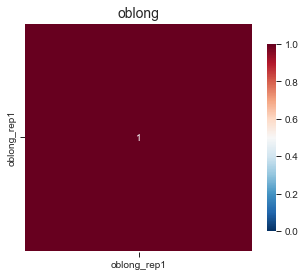

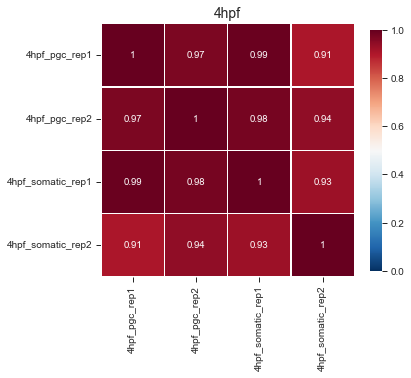

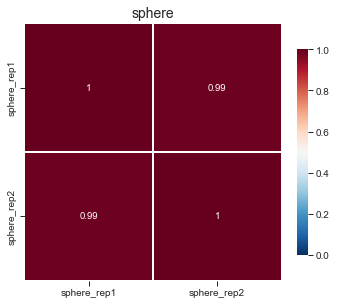

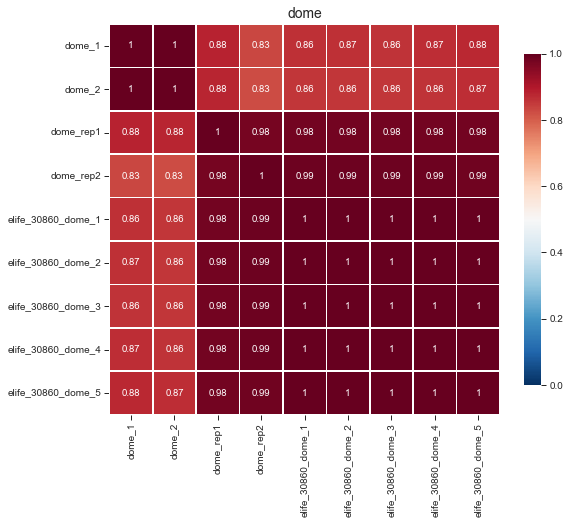

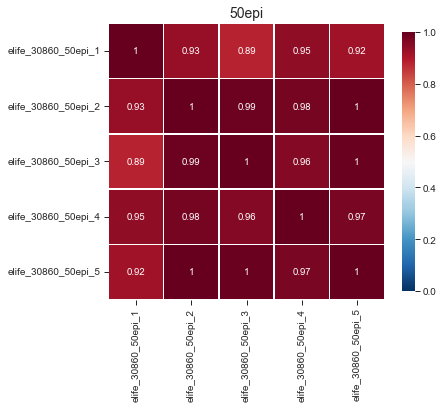

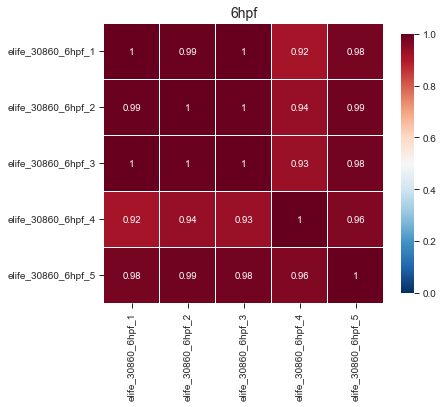

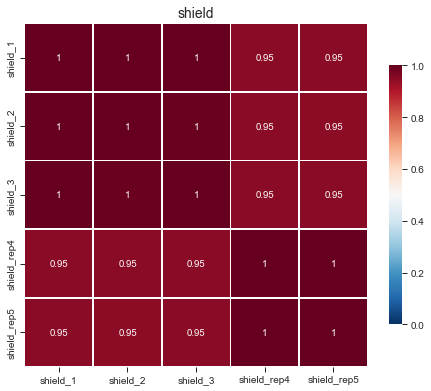

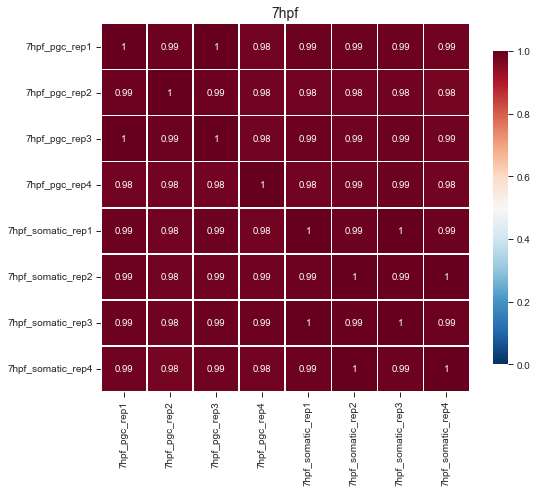

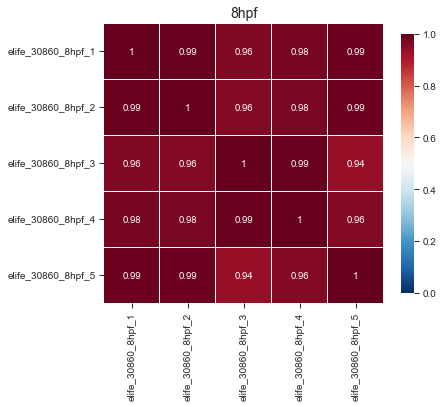

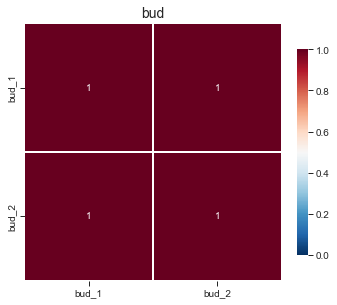

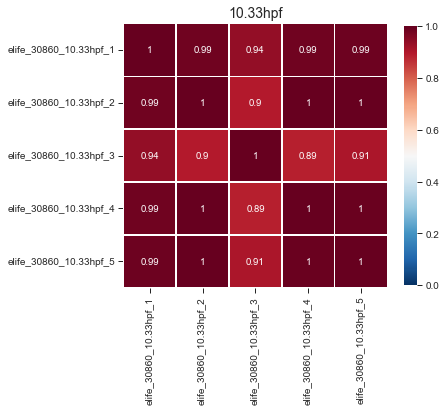

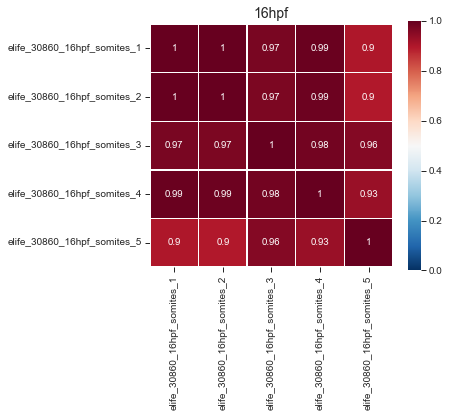

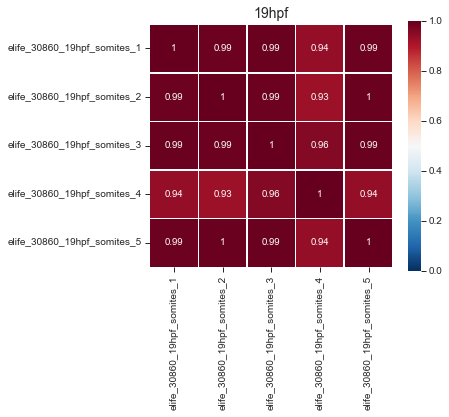

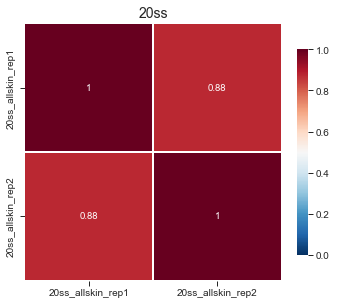

In [153]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_embryo_TPM_combat.pdf') as pdf_pages :
    for stage in ovary_earlyEmbryo_TPM_stages_uniq[1:] :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_combat_dict_T['ovary_earlyEmbryo_TPM'].loc[[x == stage for x in ovary_earlyEmbryo_TPM_stages[6:]]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(stage)
            
            pdf_pages.savefig(fig)

<ipython-input-154-dedca6bc298f>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))


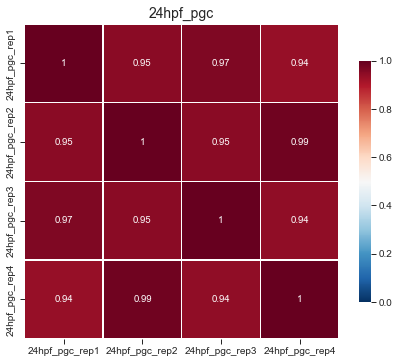

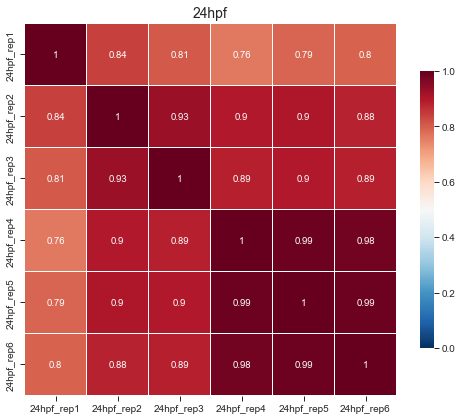

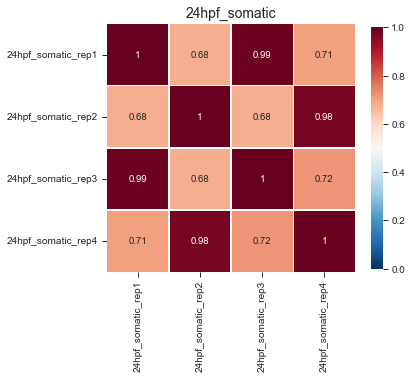

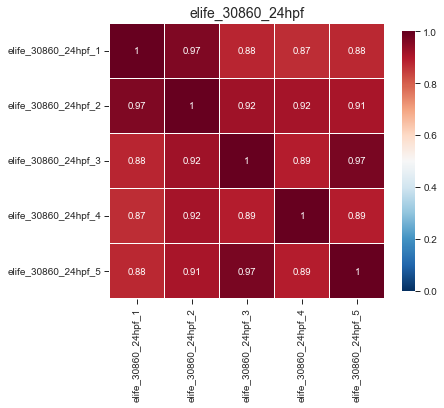

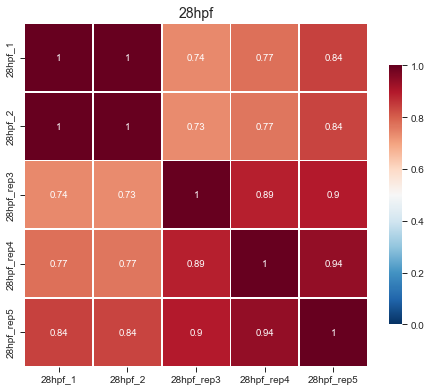

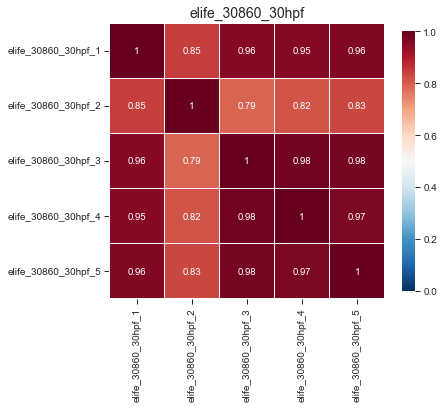

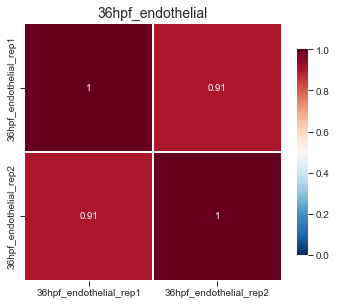

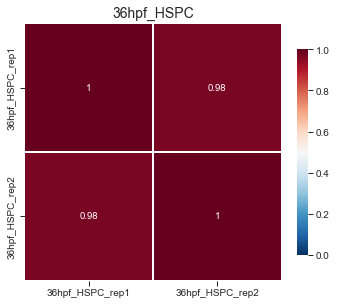

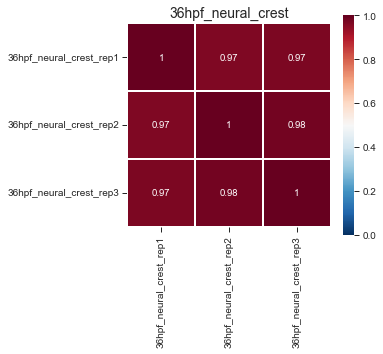

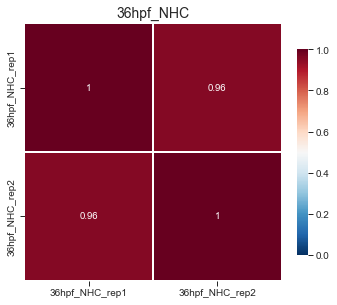

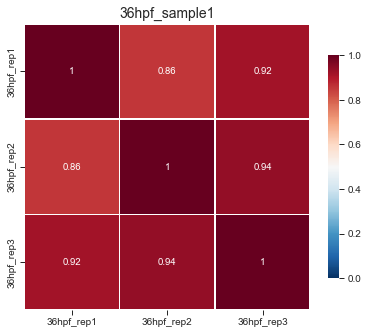

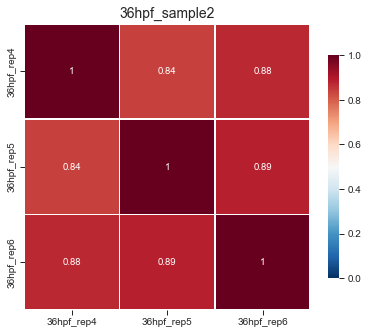

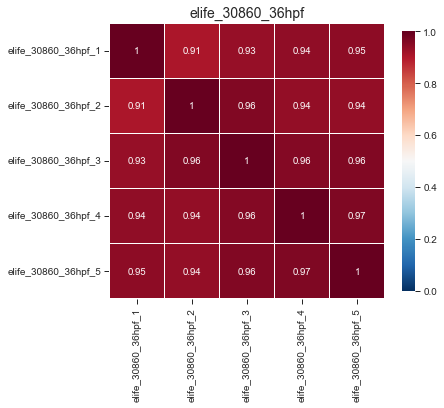

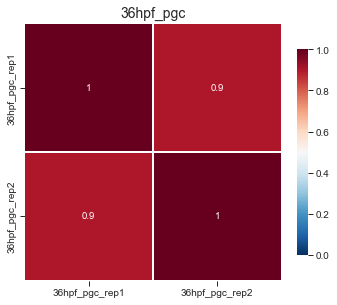

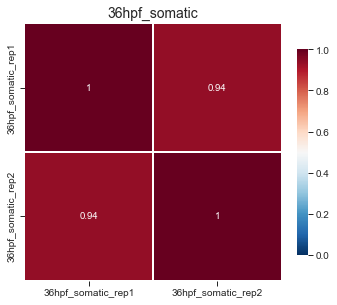

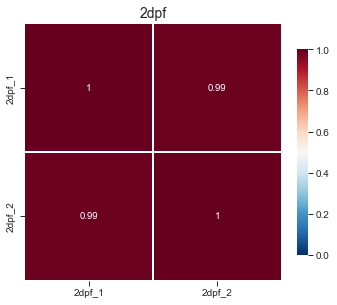

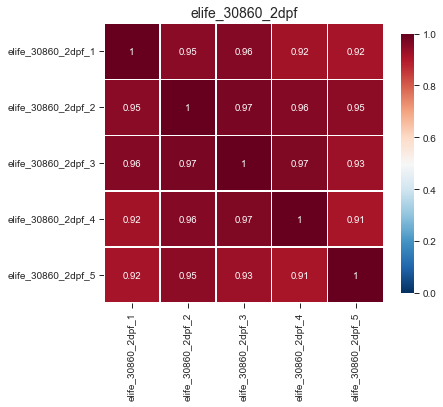

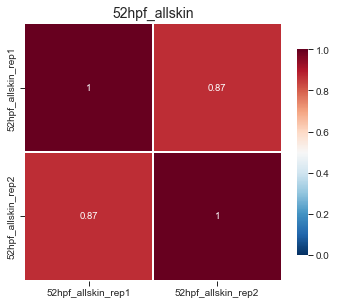

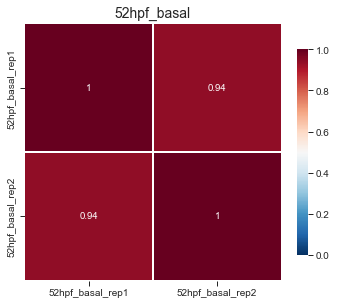

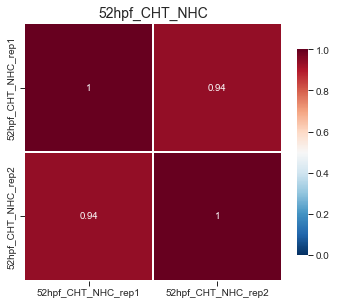

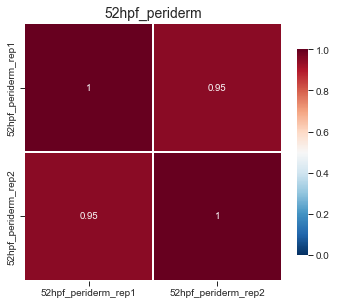

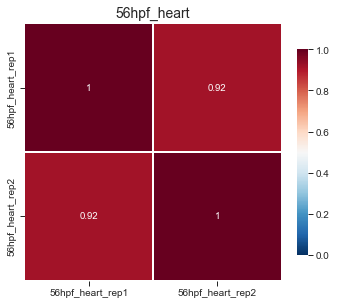

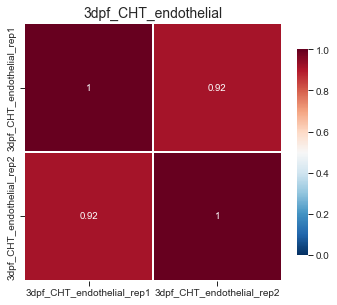

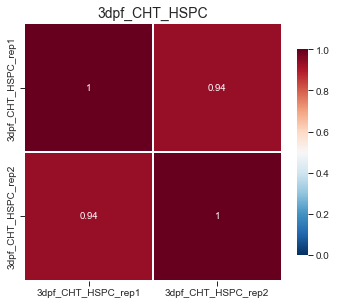

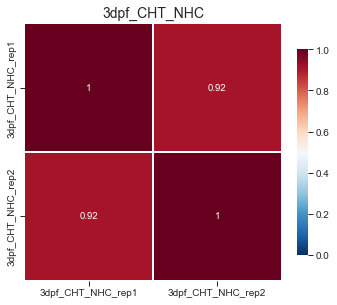

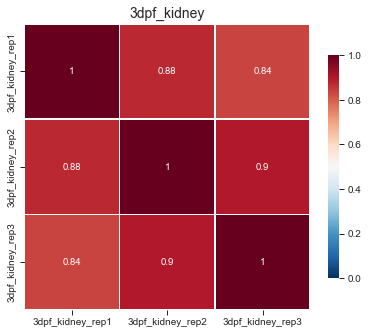

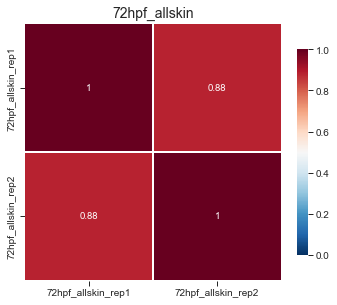

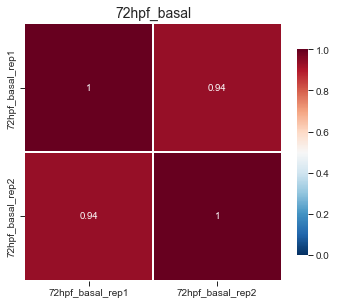

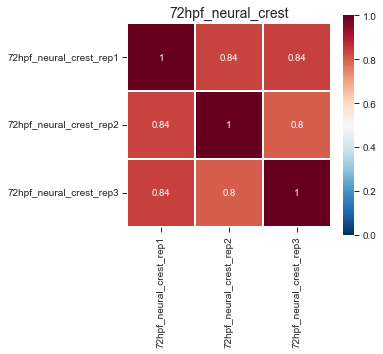

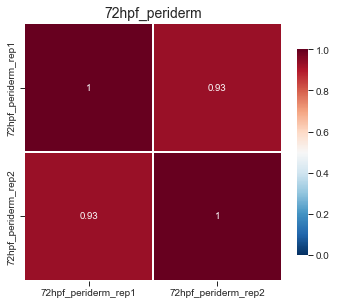

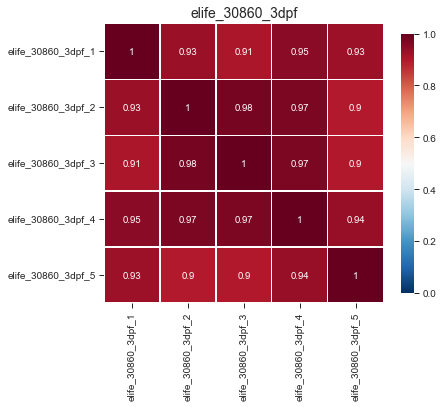

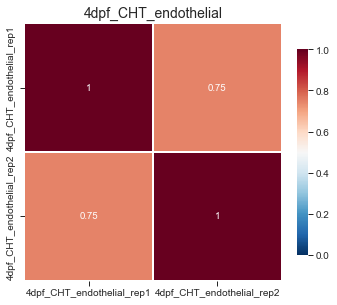

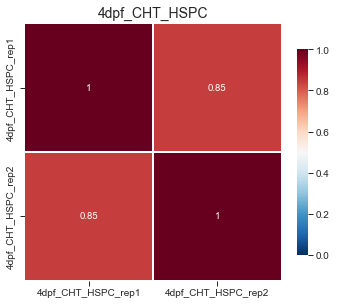

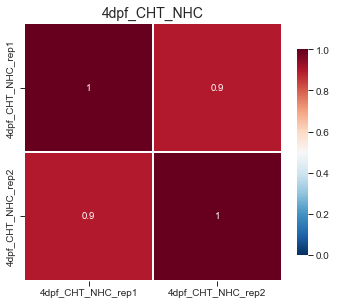

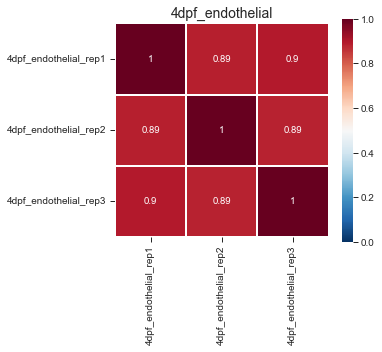

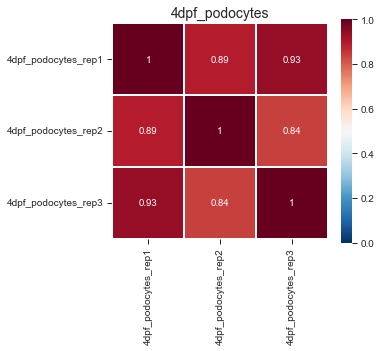

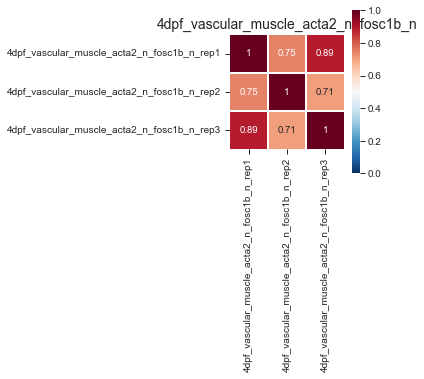

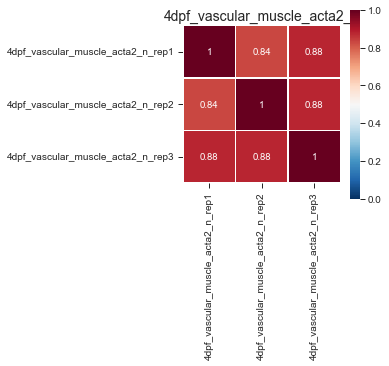

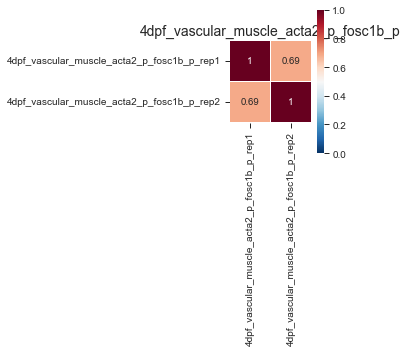

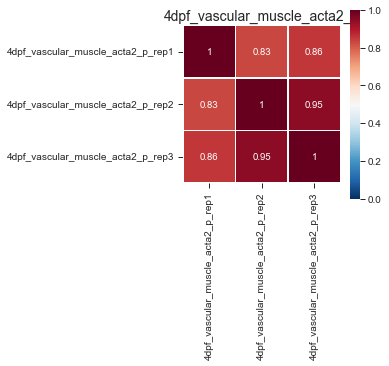

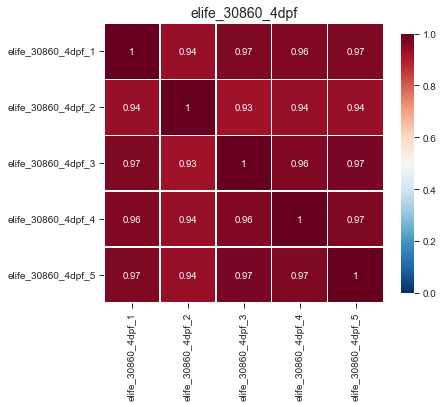

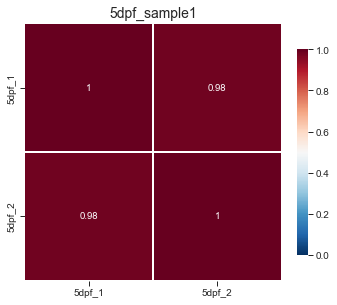

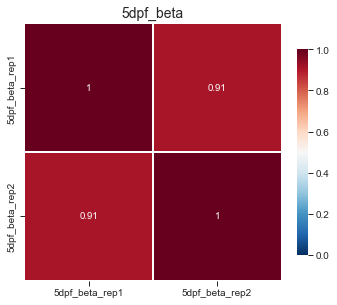

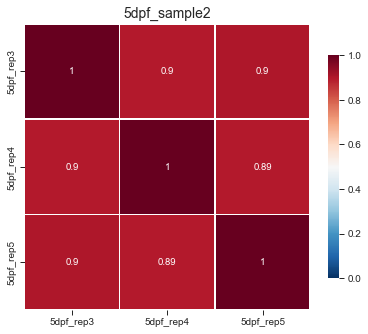

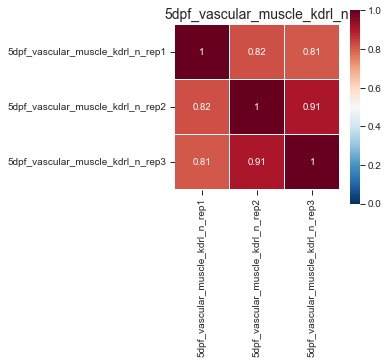

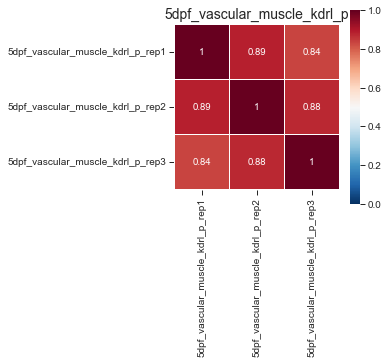

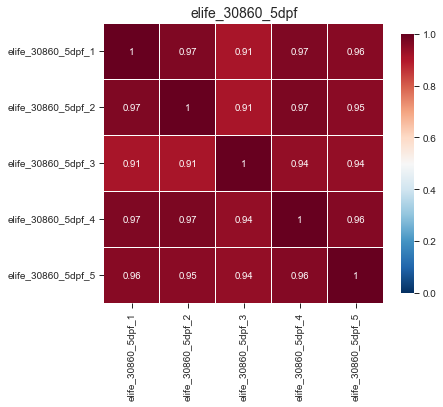

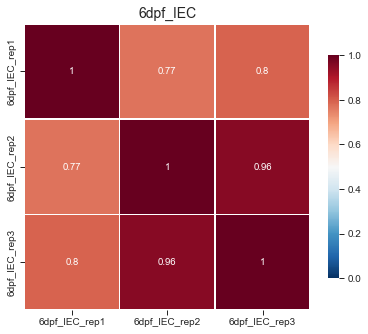

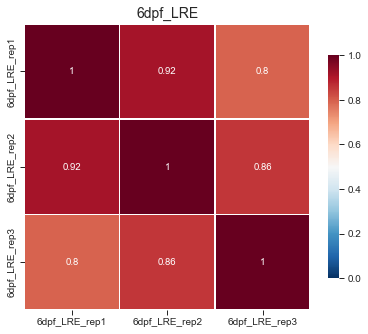

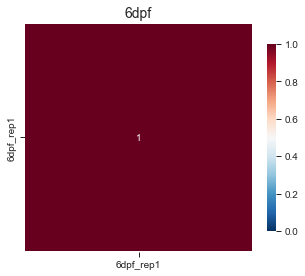

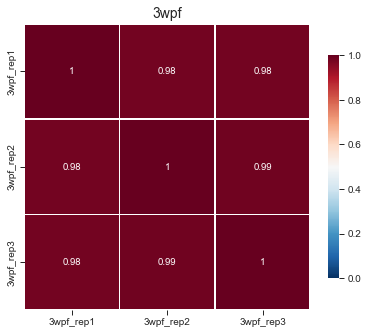

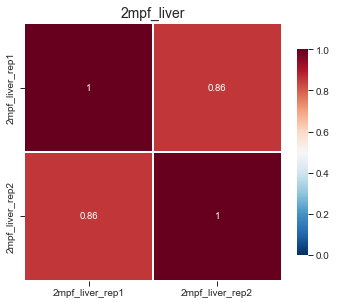

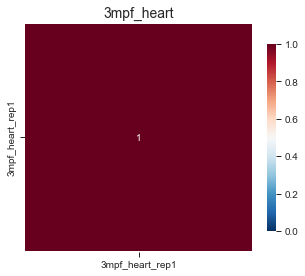

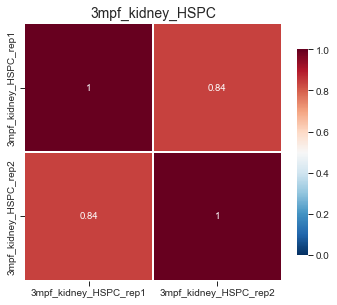

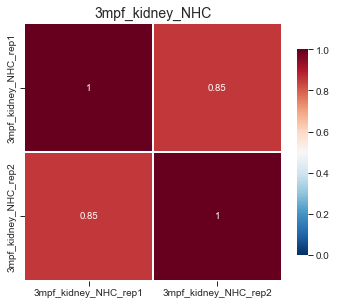

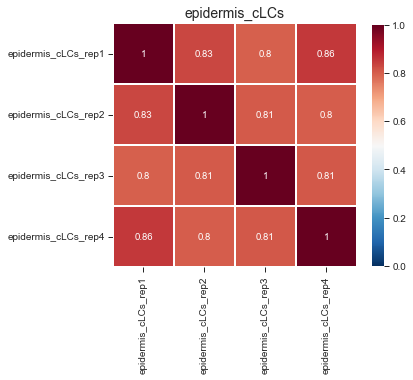

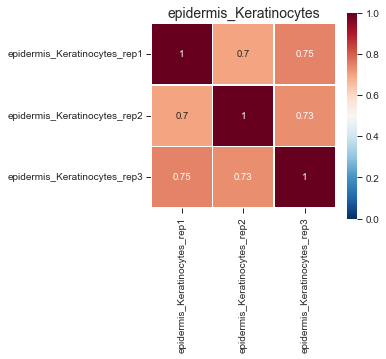

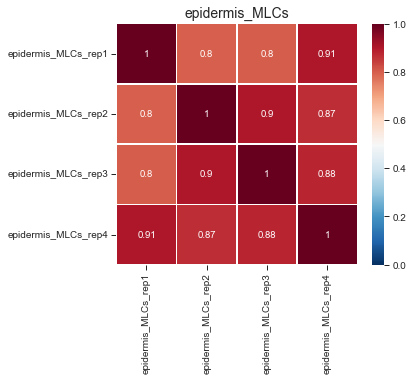

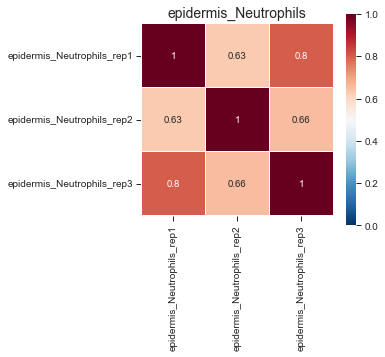

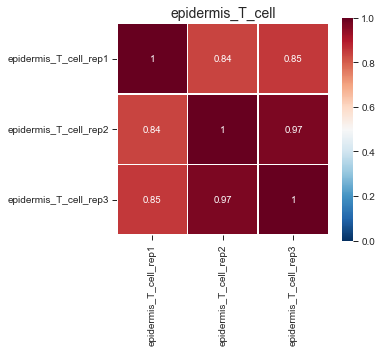

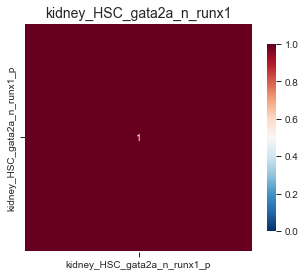

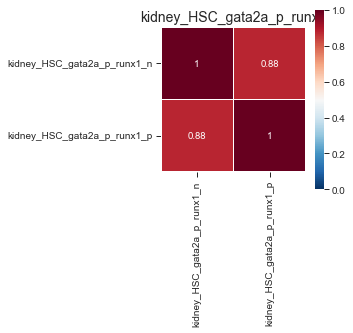

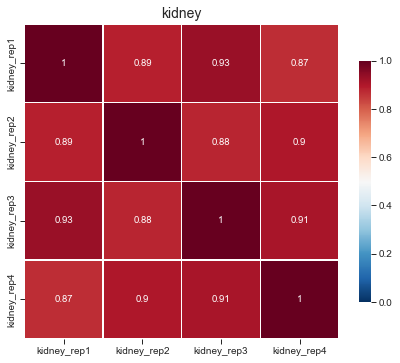

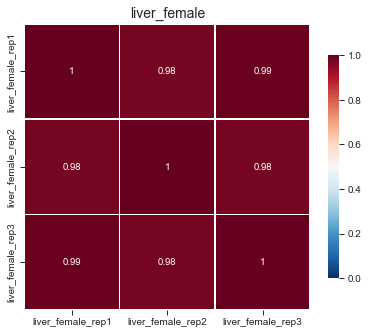

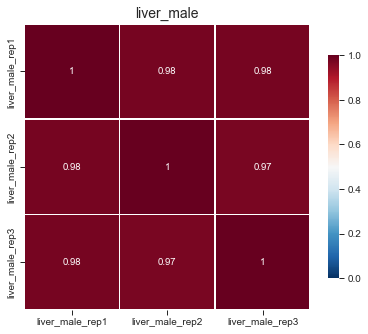

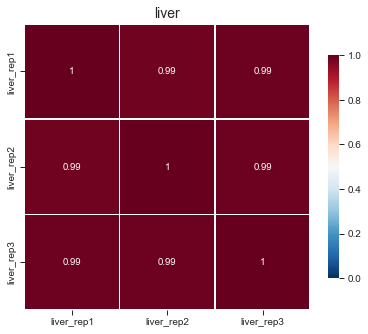

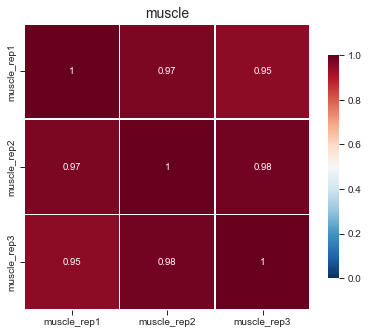

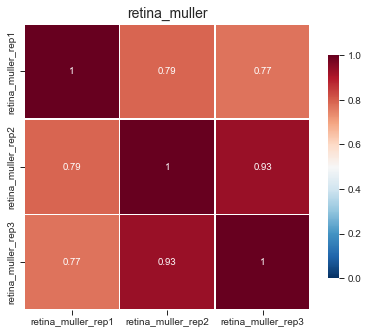

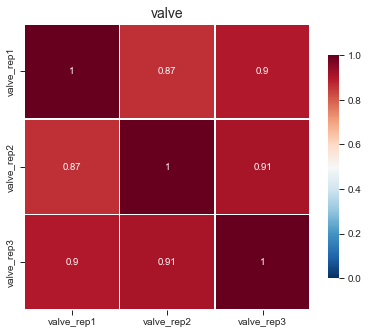

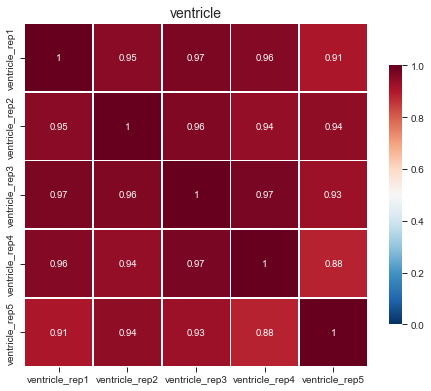

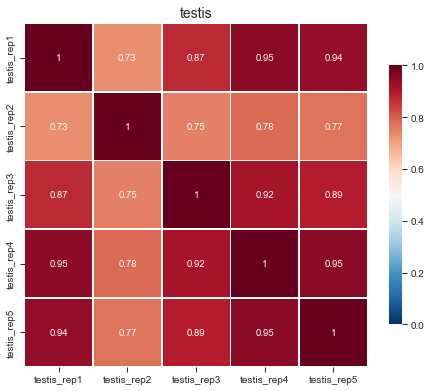

In [154]:
with PdfPages(f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/figures/make1_repCorr_tissueBySamples_TPM_combat.pdf') as pdf_pages :
    for sample in lateEmbryo_tissue_TPM_samples_uniq :
#     for stage in ['oocyte'] :
    
        heatmap_tpm = expr_combat_dict_T['lateEmbryo_tissue_TPM'].loc[[x == sample for x in lateEmbryo_tissue_TPM_samples]].iloc[:,:-1].T
        corr = heatmap_tpm.astype(float).corr()
        with sns.axes_style('white', rc={
                'xtick.bottom': True,
                'ytick.left': True
        }), sns.plotting_context('paper',
                                 rc={
                                     'axes.titlesize': 14,
                                     'axes.labelsize': 12,
                                     'xtick.labelsize': 10,
                                     'ytick.labelsize': 10,
                                     'legend.fontsize': 10
                                 }):
            fig, ax = plt.subplots(tight_layout = True, figsize=(4+corr.shape[0]*.5, 5+corr.shape[1]*.5))
            # Draw the heatmap with the mask and correct aspect ratio
            g = sns.heatmap(corr,
                        #mask=mask,
                        cmap='RdBu_r',
                        vmin=0,
                        vmax=1,
                        square=True,
                        linewidths=.5,
                        cbar_kws={"shrink": .5},
                        annot=True,
                        ax=ax
                        )
            ax.set_title(sample)
            
            pdf_pages.savefig(fig)

# rm low corr reps

In [37]:
expr_combat_dict_T.keys()

dict_keys(['ovary_earlyEmbryo_FPKM', 'lateEmbryo_tissue_FPKM', 'ovary_earlyEmbryo_TPM', 'lateEmbryo_tissue_TPM'])

In [160]:
(corr.sum(axis=1)-1)/(corr.shape[0] - 1)

testis_rep1    0.872922
testis_rep2    0.759602
testis_rep3    0.858026
testis_rep4    0.899066
testis_rep5    0.888691
dtype: float64

In [38]:
rep_low_corr_ls = []
for sample in lateEmbryo_tissue_TPM_samples_uniq :    
    heatmap_tpm = expr_combat_dict_T['lateEmbryo_tissue_TPM'].loc[expr_combat_dict_T['lateEmbryo_tissue_TPM']['stage'] == sample].iloc[:,:-1].T
    corr = heatmap_tpm.astype(float).corr()    
    rep_low_corr_ls += corr.loc[(corr.sum(axis=1) - 1) / (corr.shape[0] - 1) <= 0.8].index.tolist()
    
if rep_low_corr_ls :
    print(rep_low_corr_ls)
    
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr'] = expr_combat_dict_T['lateEmbryo_tissue_TPM'][~expr_combat_dict_T['lateEmbryo_tissue_TPM'].index.isin(rep_low_corr_ls)]
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr']

['4dpf_CHT_endothelial_rep1', '4dpf_CHT_endothelial_rep2', '4dpf_vascular_muscle_acta2_n_fosc1b_n_rep2', '4dpf_vascular_muscle_acta2_p_fosc1b_p_rep1', '4dpf_vascular_muscle_acta2_p_fosc1b_p_rep2', '6dpf_IEC_rep1', 'epidermis_Keratinocytes_rep1', 'epidermis_Keratinocytes_rep2', 'epidermis_Keratinocytes_rep3', 'epidermis_Neutrophils_rep1', 'epidermis_Neutrophils_rep2', 'epidermis_Neutrophils_rep3', 'retina_muller_rep1', 'testis_rep2']


exon_id        ENSDART00000000004.5.1 ENSDART00000000004.5.2  \
24hpf_pgc_rep1               1.457431               0.026499   
24hpf_pgc_rep2               0.780506                    0.0   
24hpf_pgc_rep3               1.597509                    0.0   
24hpf_pgc_rep4               0.896384                    0.0   
24hpf_rep1                   0.220342               0.220342   
...                               ...                    ...   
ventricle_rep5               0.502903               0.114296   
testis_rep1                  0.951127               0.951127   
testis_rep3                  0.781464               1.041952   
testis_rep4                  0.391247               0.978119   
testis_rep5                  0.136971               0.639197   

exon_id        ENSDART00000000004.5.3 ENSDART00000000004.5.4  \
24hpf_pgc_rep1               2.040403                    0.0   
24hpf_pgc_rep2               0.936608                    0.0   
24hpf_pgc_rep3               1.542423                    0.0   
24hpf_pgc_rep4               0.158185                    0.0   
24hpf_rep1                   3.415308               0.220342   
...                               ...                    ...   
ventricle_rep5               1.280116                    0.0   
testis_rep1                  4.121549                    0.0   
testis_rep3                  4.949271                    0.0   
testis_rep4                  5.086217               0.195624   
testis_rep5                  4.839632                    0.0   

exon_id        ENSDART00000000004.5.5 ENSDART00000000004.5.6  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2                    0.0                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.052728               0.105457   
24hpf_rep1                   0.661027               0.330514   
...                               ...                    ...   
ventricle_rep5                    0.0                    0.0   
testis_rep1                  0.634084               2.219296   
testis_rep3                  0.520976               0.781464   
testis_rep4                  0.978119               0.391247   
testis_rep5                  0.684854               0.639197   

exon_id        ENSDART00000000004.5.7 ENSDART00000000004.5.8  \
24hpf_pgc_rep1                    0.0                    0.0   
24hpf_pgc_rep2               0.390253                    0.0   
24hpf_pgc_rep3                    0.0                    0.0   
24hpf_pgc_rep4               0.316371                    0.0   
24hpf_rep1                   0.440685                    0.0   
...                               ...                    ...   
ventricle_rep5               0.091437                    0.0   
testis_rep1                  1.268169                    0.0   
testis_rep3                  0.781464                    0.0   
testis_rep4                  0.782495                    0.0   
testis_rep5                   0.73051                    0.0   

exon_id        ENSDART00000000005.7.1 ENSDART00000000005.7.2  ...  \
24hpf_pgc_rep1              15.130781               0.052997  ...   
24hpf_pgc_rep2              15.454025               0.052034  ...   
24hpf_pgc_rep3              12.835162                    0.0  ...   
24hpf_pgc_rep4              15.765808               0.632741  ...   
24hpf_rep1                   5.508561               0.220342  ...   
...                               ...                    ...  ...   
ventricle_rep5              13.486939               0.160015  ...   
testis_rep1                   2.85338               0.634084  ...   
testis_rep3                  1.823416                    0.0  ...   
testis_rep4                   3.12998               0.391247  ...   
testis_rep5                  3.789523               0.365255  ...   

exon_id        ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
24hpf_pg

In [39]:
rep_low_corr_ls = []
for stage in ovary_earlyEmbryo_TPM_stages_uniq :    
    heatmap_tpm = expr_combat_dict_T['ovary_earlyEmbryo_TPM'].loc[expr_combat_dict_T['ovary_earlyEmbryo_TPM']['stage'] == stage].iloc[:,:-1].T
    corr = heatmap_tpm.astype(float).corr()
    rep_low_corr_ls += corr.loc[(corr.sum(axis=1) - 1) / (corr.shape[0] - 1) <= 0.8].index.tolist()
    
if rep_low_corr_ls :
    print(rep_low_corr_ls)
    
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr'] = expr_combat_dict_T['ovary_earlyEmbryo_TPM'][~expr_combat_dict_T['ovary_earlyEmbryo_TPM'].index.isin(rep_low_corr_ls)]
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr']

exon_id                     ENSDART00000000004.5.1 ENSDART00000000004.5.2  \
oocyte_rep1                               0.577795                0.31112   
oocyte_rep2                               1.385141               0.846475   
1cell_rep1                                1.480533                2.39163   
1cell_rep2                                1.266204               3.271026   
1cell_rep3                                1.068887               5.077211   
...                                            ...                    ...   
elife_30860_19hpf_somites_3               0.893694               0.595796   
elife_30860_19hpf_somites_4                    0.0               0.569407   
elife_30860_19hpf_somites_5               0.153903                0.46171   
20ss_allskin_rep1                         1.092357               0.136545   
20ss_allskin_rep2                         0.257754               0.257754   

exon_id                     ENSDART00000000004.5.3 ENSDART00000000004.5.4  \
oocyte_rep1                               7.289109                    0.0   
oocyte_rep2                               7.695227                    0.0   
1cell_rep1                               10.135955               0.569436   
1cell_rep2                                9.918596               0.633102   
1cell_rep3                                9.619979               0.534443   
...                                            ...                    ...   
elife_30860_19hpf_somites_3               7.447448               0.148949   
elife_30860_19hpf_somites_4               7.592092                    0.0   
elife_30860_19hpf_somites_5               7.849063               0.153903   
20ss_allskin_rep1                         3.550159               0.273089   
20ss_allskin_rep2                         5.928337                    0.0   

exon_id                     ENSDART00000000004.5.5 ENSDART00000000004.5.6  \
oocyte_rep1                                    0.0                    0.0   
oocyte_rep2                               0.230857               0.461714   
1cell_rep1                                6.149905               3.644388   
1cell_rep2                                6.331019                2.11034   
1cell_rep3                                4.275546               4.008324   
...                                            ...                    ...   
elife_30860_19hpf_somites_3               0.297898                    0.0   
elife_30860_19hpf_somites_4               0.569407                    0.0   
elife_30860_19hpf_somites_5               0.307806               0.307806   
20ss_allskin_rep1                              0.0               0.273089   
20ss_allskin_rep2                         0.128877               0.257754   

exon_id                     ENSDART00000000004.5.7 ENSDART00000000004.5.8  \
oocyte_rep1                               0.400012                    0.0   
oocyte_rep2                               1.385141                    0.0   
1cell_rep1                                1.480533                    0.0   
1cell_rep2                                1.793789               0.105517   
1cell_rep3                                 1.60333               1.336108   
...                                            ...                    ...   
elife_30860_19hpf_somites_3               1.638439                    0.0   
elife_30860_19hpf_somites_4                    0.0                    0.0   
elife_30860_19hpf_somites_5               1.231226                    0.0   
20ss_allskin_rep1                         0.409634                    0.0   
20ss_allskin_rep2                         0.386631                    0.0   

exon_id                     ENSDART00000000005.7.1 ENSDART00000000005.7.2  \
oocyte_rep1                               2.800084               0.088892   
oocyte_rep2                                0.69257               0.153905   
1cell_rep1                                1.138871                   

In [41]:
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'] = expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr'].groupby('stage').mean()
# df.Tm = df.Tm.astype("category")
# df.Tm.cat.set_categories(sorter, inplace=True)
# resort by stage
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean']['cate'] = expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].index
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].cate = expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].cate.astype('category')
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].cate.cat.set_categories(ovary_earlyEmbryo_TPM_stages_uniq, inplace = True)
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'] = expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].sort_values(['cate'])
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].drop('cate', 1, inplace = True)
expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean']

<ipython-input-41-5b5f2fe20525>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean']['cate'] = expr_combat_dict_T['ovary_earlyEmbryo_TPM_highCorr_mean'].index
/mnt/Storage/home/wangyiman/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
<ipython-input-41-5b5f2fe20525>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  expr_combat_dict_T['ovary_earlyEmbryo_TPM_hi

exon_id   ENSDART00000000004.5.1  ENSDART00000000004.5.2  \
stage                                                      
oocyte                  0.981468                0.578798   
1_cell                  1.030695                1.985944   
2_cell                  1.241026                0.479589   
4_cell                  1.171709                1.186875   
24_cell                 0.950061                0.367711   
64_cell                 1.028837                0.942206   
128_cell                1.185902                1.739533   
256_cell                1.134168                1.460107   
1k_cell                 1.099172                1.973924   
high                    0.890083                3.331471   
oblong                  0.484289                0.927067   
4hpf                    0.975892                0.000000   
sphere                  1.056117                0.763983   
dome                    1.109834                0.895280   
50epi                   1.078691                0.431784   
6hpf                    1.060050                0.377092   
shield                  0.943997                0.259037   
7hpf                    1.012991                0.052552   
8hpf                    1.026796                0.174025   
bud                     0.727088                0.254777   
10.33hpf                0.885956                0.482791   
16hpf                   0.981644                0.546722   
19hpf                   0.886330                0.490325   
20ss                    0.675055                0.197149   

exon_id   ENSDART00000000004.5.3  ENSDART00000000004.5.4  \
stage                                                      
oocyte                  7.492168                0.000000   
1_cell                  7.136148                0.189808   
2_cell                  8.239759                0.000000   
4_cell                  8.234212                0.000000   
24_cell                 7.337348                0.030250   
64_cell                 8.451621                0.000000   
128_cell                7.938488                0.000000   
256_cell                7.681845                0.027076   
1k_cell                 7.332074                0.017800   
high                    6.156129                0.212572   
oblong                 13.947523                0.041510   
4hpf                    7.418125                0.000000   
sphere                  8.046162                0.000000   
dome                    7.654342                0.014085   
50epi                   7.591212                0.000000   
6hpf                    7.350795                0.000000   
shield                  7.187259                0.000000   
7hpf                    7.621802                0.000000   
8hpf                    7.204263                0.036271   
bud                     6.421683                0.062765   
10.33hpf                6.954139                0.000000   
16hpf                   7.259465                0.030017   
19hpf                   6.625731                0.060570   
20ss                    4.739248                0.136545   

exon_id   ENSDART00000000004.5.5  ENSDART00000000004.5.6  \
stage                                                      
oocyte                  0.115428                0.230857   
1_cell                  1.988302                1.307413   
2_cell                  0.219553                0.067396   
4_cell                  0.083336                0.000000   
24_cell                 0.342173                0.248156   
64_cell                 0.054536                0.000000   
128_cell                0.606006                0.301353   
256_cell                0.986014                0.313629   
1k_cell                 0.662612                0.213382   
high                    2.129195                1.726626   
oblong                  1.819543                0.581147   
4hpf                    0.239506                0.000000   
sphere                  0.137718      

In [42]:
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'] = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr'].groupby('stage').mean()
# resort by sample
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean']['cate'] = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].index
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].cate = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].cate.astype('category')
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].cate.cat.set_categories(lateEmbryo_tissue_TPM_samples_uniq, inplace = True)
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'] = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].sort_values(['cate'])
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].drop('cate', 1, inplace = True)
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean']

<ipython-input-42-859acb2ee126>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean']['cate'] = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].index
/mnt/Storage/home/wangyiman/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
<ipython-input-42-859acb2ee126>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  expr_combat_dict_T['lateEmbryo_tissue_TPM_hi

exon_id            ENSDART00000000004.5.1  ENSDART00000000004.5.2  \
stage                                                               
24hpf_pgc                        1.182958                0.006625   
24hpf                            0.586809                0.475669   
24hpf_somatic                    1.130975                0.120300   
elife_30860_24hpf                1.120714                0.572350   
28hpf                            0.671991                0.500423   
...                                   ...                     ...   
muscle                           0.835516                0.138240   
retina_muller                    0.421748                0.000000   
valve                            3.066535                2.083555   
ventricle                        0.912311                0.374233   
testis                           0.565202                0.902598   

exon_id            ENSDART00000000004.5.3  ENSDART00000000004.5.4  \
stage                                                               
24hpf_pgc                        1.169405                0.000000   
24hpf                            2.808664                0.141113   
24hpf_somatic                    1.031448                0.000000   
elife_30860_24hpf                3.236860                0.000000   
28hpf                            2.772274                0.008888   
...                                   ...                     ...   
muscle                           2.256389                0.000000   
retina_muller                    1.531205                0.000000   
valve                            5.527524                0.000000   
ventricle                        2.249246                0.000000   
testis                           4.749167                0.048906   

exon_id            ENSDART00000000004.5.5  ENSDART00000000004.5.6  \
stage                                                               
24hpf_pgc                        0.013182                0.026364   
24hpf                            0.482539                0.326789   
24hpf_somatic                    0.000000                0.443702   
elife_30860_24hpf                0.203386                0.131732   
28hpf                            0.099775                0.025689   
...                                   ...                     ...   
muscle                           0.029818                0.059637   
retina_muller                    0.000000                0.000000   
valve                            0.730134                0.878160   
ventricle                        0.000000                0.000000   
testis                           0.704508                1.007801   

exon_id            ENSDART00000000004.5.7  ENSDART00000000004.5.8  \
stage                                                               
24hpf_pgc                        0.176656                0.000000   
24hpf                            0.551048                0.031160   
24hpf_somatic                    0.226805                0.000000   
elife_30860_24hpf                0.337975                0.000000   
28hpf                            0.431569                0.036121   
...                                   ...                     ...   
muscle                           0.152653                0.011899   
retina_muller                    0.000000                0.000000   
valve                            1.344888                0.000000   
ventricle                        0.200634                0.000000   
testis                           0.890660                0.000000   

exon_id            ENSDART00000000005.7.1  ENSDART00000000005.7.2  ...  \
stage                                                              ...   
24hpf_pgc                       14.796444                0.184443  ...   
24hpf                            3.905752                0.505752  ...   
24hpf_somatic                   17.268700                0.080007  ...   
elife_30860_24hpf               12.655

In [43]:
len(lateEmbryo_tissue_TPM_samples_uniq)

71

In [44]:
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean_exTestis'] = expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].drop('testis')
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean_Testis'] = pd.DataFrame(expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean'].T.testis).T
expr_combat_dict_T['lateEmbryo_tissue_TPM_highCorr_mean_Testis']

exon_id  ENSDART00000000004.5.1  ENSDART00000000004.5.2  \
testis                 0.565202                0.902598   

exon_id  ENSDART00000000004.5.3  ENSDART00000000004.5.4  \
testis                 4.749167                0.048906   

exon_id  ENSDART00000000004.5.5  ENSDART00000000004.5.6  \
testis                 0.704508                1.007801   

exon_id  ENSDART00000000004.5.7  ENSDART00000000004.5.8  \
testis                  0.89066                     0.0   

exon_id  ENSDART00000000005.7.1  ENSDART00000000005.7.2  ...  \
testis                 2.899075                0.347647  ...   

exon_id  ENSDART00000195003.1.1_ENSDART00000194969.1.1_ENSDART00000194711.1.1  \
testis                                                 0.0                      

exon_id  ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
testis                                            0.102089                      

exon_id  ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
testis                                            0.102089                      

exon_id  ENSDART00000195003.1.2_ENSDART00000194969.1.2_ENSDART00000194711.1.2  \
testis                                            0.102089                      

exon_id  ENSDART00000195003.1.3_ENSDART00000194969.1.3_ENSDART00000194711.1.3  \
testis                                            0.143469                      

exon_id  ENSDART00000195003.1.3_ENSDART00000194969.1.3_ENSDART00000194711.1.3  \
testis                                            0.143469                      

exon_id  ENSDART00000195003.1.3_ENSDART00000194969.1.3_ENSDART00000194711.1.3  \
testis                                            0.143469                      

exon_id  ENSDART00000195003.1.4  ENSDART00000195003.1.4  \
testis                 0.022828                0.022828   

exon_id  ENSDART00000195003.1.4  
testis                 0.022828  

[1 rows x 848253 columns]

In [45]:
expr_combat_dict_T.keys()

dict_keys(['ovary_earlyEmbryo_FPKM', 'lateEmbryo_tissue_FPKM', 'ovary_earlyEmbryo_TPM', 'lateEmbryo_tissue_TPM', 'lateEmbryo_tissue_TPM_highCorr', 'ovary_earlyEmbryo_TPM_highCorr', 'ovary_earlyEmbryo_TPM_highCorr_mean', 'lateEmbryo_tissue_TPM_highCorr_mean', 'lateEmbryo_tissue_TPM_highCorr_mean_exTestis', 'lateEmbryo_tissue_TPM_highCorr_mean_Testis'])

In [46]:
for k in expr_combat_dict_T.keys() :
    expr_combat_dict_T[k].to_csv(
        f'/mnt/Storage/home/wangyiman/maternal_loading/2.public_data/jupyter_middle_files/make1_mergeExpr_extend.expr_combat_dict_T.{k}',
        sep = "\t",        
    )

# filter exons

## candidate gene distribution

In [61]:
candidate_gene_ids = tr_gene_symbol_pd.loc[tr_gene_symbol_pd['gene_symbol'].isin(candidate_maternal_gene_ls)]['gene_id']
candidate_gene_ids_clean = [x.split('.')[0] for x in candidate_gene_ids]
candidate_gene_ids_clean

['ENSDARG00000089765',
 'ENSDARG00000089765',
 'ENSDARG00000089765',
 'ENSDARG00000089765',
 'ENSDARG00000089765',
 'ENSDARG00000077178',
 'ENSDARG00000077178',
 'ENSDARG00000077178',
 'ENSDARG00000077178',
 'ENSDARG00000039937',
 'ENSDARG00000109055',
 'ENSDARG00000076214',
 'ENSDARG00000076214',
 'ENSDARG00000056339',
 'ENSDARG00000097302',
 'ENSDARG00000089607',
 'ENSDARG00000104170',
 'ENSDARG00000104170',
 'ENSDARG00000104170',
 'ENSDARG00000104170',
 'ENSDARG00000035680',
 'ENSDARG00000038812',
 'ENSDARG00000038812',
 'ENSDARG00000026972',
 'ENSDARG00000026972',
 'ENSDARG00000033231',
 'ENSDARG00000033231',
 'ENSDARG00000042215',
 'ENSDARG00000042215',
 'ENSDARG00000042215',
 'ENSDARG00000042215',
 'ENSDARG00000037532',
 'ENSDARG00000020354',
 'ENSDARG00000020354',
 'ENSDARG00000020354',
 'ENSDARG00000044956',
 'ENSDARG00000044956',
 'ENSDARG00000089856',
 'ENSDARG00000087166',
 'ENSDARG00000060584',
 'ENSDARG00000060584',
 'ENSDARG00000060584',
 'ENSDARG00000060584',
 'ENSDARG00

In [62]:
candidate_tr_gene_exon_clean = exon_tr_gene_pd_clean.loc[exon_tr_gene_pd_clean['gene_id_clean'].isin(candidate_gene_ids_clean)]
candidate_tr_gene_exon_clean

transcript_id_clean       gene_id_clean  \
37641   ENSDART00000152687  ENSDARG00000089765   
37642   ENSDART00000152687  ENSDARG00000089765   
37643   ENSDART00000152687  ENSDARG00000089765   
37644   ENSDART00000152687  ENSDARG00000089765   
37645   ENSDART00000152687  ENSDARG00000089765   
...                    ...                 ...   
788551  ENSDART00000132295  ENSDARG00000056387   
788552  ENSDART00000132295  ENSDARG00000056387   
788553  ENSDART00000132295  ENSDARG00000056387   
788554  ENSDART00000132295  ENSDARG00000056387   
788555  ENSDART00000132295  ENSDARG00000056387   

                                                  exon_id  
37641   ENSDART00000152687.3.7_ENSDART00000152504.3.4_...  
37642                              ENSDART00000152504.3.1  
37643   ENSDART00000152687.3.5_ENSDART00000152504.3.2_...  
37644                              ENSDART00000152687.3.2  
37645                              ENSDART00000152687.3.1  
...                                                   ...  
788551    ENSDART00000176057.2.19_ENSDART00000132295.4.19  
788552    ENSDART00000176057.2.20_ENSDART00000132295.4.20  
788553    ENSDART00000176057.2.12_ENSDART00000132295.4.12  
788554    ENSDART00000176057.2.13_ENSDART00000132295.4.13  
788555                            ENSDART00000132295.4.37  

[923 rows x 3 columns]

In [63]:
candidate_exon_expr = {}

In [67]:
k = 'lateEmbryo_tissue_TPM_highCorr_mean'
candidate_exon_expr[k] = expr_3id_dict_T[k].T.loc[expr_3id_dict_T[k].T.index.isin(candidate_tr_gene_exon_clean['exon_id'])]
candidate_exon_expr[k] = pd.merge(candidate_exon_expr[k], candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
candidate_exon_expr[k].index = candidate_exon_expr[k]['exon_id']

In [71]:
plot_df = pd.DataFrame(candidate_exon_expr[k].drop(['gene_id_clean', 'exon_id'], axis = 1).max(axis = 1))
plot_df = pd.merge(plot_df, candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
plot_df = plot_df.drop('exon_id', axis = 1).groupby('gene_id_clean').min()
plot_df = pd.merge(plot_df, gene_symbol_clean, on = 'gene_id_clean')
plot_df

gene_id_clean         0       gene_symbol
0   ENSDARG00000010332  0.286420         zgc:56231
1   ENSDARG00000020354  0.021367             lmx1a
2   ENSDARG00000026972  0.201371  si:ch211-119o8.6
3   ENSDARG00000033231  0.150435             mcm6l
4   ENSDARG00000035680  0.633815        zgc:113424
5   ENSDARG00000037532  0.381125             mcm3l
6   ENSDARG00000038812  0.520733              e2f5
7   ENSDARG00000039217  0.044804              orc1
8   ENSDARG00000039937  7.980953           ccdc172
9   ENSDARG00000042215  0.026096            pias4b
10  ENSDARG00000044956  0.002802        zgc:114123
11  ENSDARG00000056339  2.557688             stk31
12  ENSDARG00000056387  0.094693             rnf17
13  ENSDARG00000060584  0.217164            kank1b
14  ENSDARG00000067669  0.116155             zglp1
15  ENSDARG00000076214  0.008773        zgc:165514
16  ENSDARG00000076391  0.015544             npm2a
17  ENSDARG00000077178  0.011047        zgc:152977
18  ENSDARG00000087166  1.282175             figla
19  ENSDARG00000089607  0.350024        CU929037.1
20  ENSDARG00000089765  0.005776  si:ch211-286b5.4
21  ENSDARG00000089856  0.200535              cita
22  ENSDARG00000097302  2.051843             tbpl2
23  ENSDARG00000104170  0.000349   si:dkey-208k4.2
24  ENSDARG00000109055  0.137658             ftr81

In [75]:
k = 'lateEmbryo_tissue_TPM_highCorr_mean_exTestis'
candidate_exon_expr[k] = expr_3id_dict_T[k].T.loc[expr_3id_dict_T[k].T.index.isin(candidate_tr_gene_exon_clean['exon_id'])]
candidate_exon_expr[k] = pd.merge(candidate_exon_expr[k], candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
candidate_exon_expr[k].index = candidate_exon_expr[k]['exon_id']

In [76]:
plot_df = pd.DataFrame(candidate_exon_expr[k].drop(['gene_id_clean', 'exon_id'], axis = 1).max(axis = 1))
plot_df = pd.merge(plot_df, candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
plot_df = plot_df.drop('exon_id', axis = 1).groupby('gene_id_clean').min()
plot_df = pd.merge(plot_df, gene_symbol_clean, on = 'gene_id_clean')
plot_df

gene_id_clean         0       gene_symbol
0   ENSDARG00000010332  0.279216         zgc:56231
1   ENSDARG00000020354  0.021367             lmx1a
2   ENSDARG00000026972  0.201371  si:ch211-119o8.6
3   ENSDARG00000033231  0.150435             mcm6l
4   ENSDARG00000035680  0.168597        zgc:113424
5   ENSDARG00000037532  0.381125             mcm3l
6   ENSDARG00000038812  0.457678              e2f5
7   ENSDARG00000039217  0.002202              orc1
8   ENSDARG00000039937  0.540563           ccdc172
9   ENSDARG00000042215  0.012677            pias4b
10  ENSDARG00000044956  0.002802        zgc:114123
11  ENSDARG00000056339  0.102010             stk31
12  ENSDARG00000056387  0.063252             rnf17
13  ENSDARG00000060584  0.217164            kank1b
14  ENSDARG00000067669  0.064997             zglp1
15  ENSDARG00000076214  0.008773        zgc:165514
16  ENSDARG00000076391  0.015544             npm2a
17  ENSDARG00000077178  0.011047        zgc:152977
18  ENSDARG00000087166  0.795321             figla
19  ENSDARG00000089607  0.350024        CU929037.1
20  ENSDARG00000089765  0.005776  si:ch211-286b5.4
21  ENSDARG00000089856  0.200535              cita
22  ENSDARG00000097302  0.089659             tbpl2
23  ENSDARG00000104170  0.000349   si:dkey-208k4.2
24  ENSDARG00000109055  0.081257             ftr81

In [64]:
# k = 'lateEmbryo_tissue_TPM'
# candidate_exon_expr[k] = expr_3id_dict_T[k].T.loc[expr_3id_dict_T[k].T.index.isin(candidate_tr_gene_exon_clean['exon_id'])]
# candidate_exon_expr[k] = pd.merge(candidate_exon_expr[k], candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
# candidate_exon_expr[k].index = candidate_exon_expr[k]['exon_id']

In [65]:
# plot_df = pd.DataFrame(candidate_exon_expr[k].drop(['gene_id_clean', 'exon_id'], axis = 1).max(axis = 1))
# plot_df = pd.merge(plot_df, candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
# plot_df = plot_df.drop('exon_id', axis = 1).groupby('gene_id_clean').min()
# plot_df = pd.merge(plot_df, gene_symbol_clean, on = 'gene_id_clean')
# plot_df

In [66]:
# k = 'lateEmbryo_tissue_FPKM'
# candidate_exon_expr[k] = expr_3id_dict_T[k].T.loc[expr_3id_dict_T[k].T.index.isin(candidate_tr_gene_exon_clean['exon_id'])]
# candidate_exon_expr[k] = pd.merge(candidate_exon_expr[k], candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
# candidate_exon_expr[k].index = candidate_exon_expr[k]['exon_id']
# candidate_exon_expr[k]

In [53]:
# plot_df = pd.DataFrame(candidate_exon_expr[k].drop(['gene_id_clean', 'exon_id'], axis = 1).max(axis = 1))
# plot_df = pd.merge(plot_df, candidate_tr_gene_exon_clean, on = 'exon_id').drop('transcript_id_clean', axis = 1)
# plot_df = plot_df.drop('exon_id', axis = 1).groupby('gene_id_clean').min()
# plot_df = pd.merge(plot_df, gene_symbol_clean, on = 'gene_id_clean')
# plot_df

gene_id_clean          0       gene_symbol
0   ENSDARG00000010332   5.382462         zgc:56231
1   ENSDARG00000020354   0.219753             lmx1a
2   ENSDARG00000026972   1.231699  si:ch211-119o8.6
3   ENSDARG00000033231   4.212498             mcm6l
4   ENSDARG00000035680   6.752597        zgc:113424
5   ENSDARG00000037532   2.066344             mcm3l
6   ENSDARG00000038812   5.564997              e2f5
7   ENSDARG00000039217   0.482961              orc1
8   ENSDARG00000039937  41.737408           ccdc172
9   ENSDARG00000042215   0.587055            pias4b
10  ENSDARG00000044956   0.064794        zgc:114123
11  ENSDARG00000056339  11.053123             stk31
12  ENSDARG00000056387   0.713295             rnf17
13  ENSDARG00000060584   1.461023            kank1b
14  ENSDARG00000067669   2.695100             zglp1
15  ENSDARG00000076214   0.557954        zgc:165514
16  ENSDARG00000076391   0.346394             npm2a
17  ENSDARG00000077178   0.212720        zgc:152977
18  ENSDARG00000087166   7.932768             figla
19  ENSDARG00000089607   2.166255        CU929037.1
20  ENSDARG00000089765   0.283498  si:ch211-286b5.4
21  ENSDARG00000089856   3.019398              cita
22  ENSDARG00000097302  11.616689             tbpl2
23  ENSDARG00000104170   0.001222   si:dkey-208k4.2
24  ENSDARG00000109055   1.861527             ftr81